## Дипломная работа - FER.

# 1. EDA

1.1 Загрузка модулей и архивов

In [1]:
!pip install livelossplot

In [2]:
# Загрузка модулей

import os
import time
import cv2
from scipy.stats import kurtosis, skew
import pandas as pd
from PIL import Image, ImageEnhance, ImageOps, ImageDraw, ImageFilter
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from livelossplot.tf_keras import PlotLossesCallback
# from keras_vggface.vggface import VGGFace
# from keras_vggface import utils
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import numpy as np
from matplotlib.patches import Rectangle
import gdown

print('tensorflow -',tf.__version__)
print('cv2 -',cv2.__version__)

tensorflow - 2.13.0
cv2 - 4.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# определение путей

BASE_DIR = Path('/content/drive/MyDrive/Skillbox/FER_Diplom/')
BASE_DIR.mkdir(exist_ok=True, parents=True)
TEST_KAGGLE_ZIP = Path('test_kaggle.zip')
TRAIN_ZIP = Path('train.zip')
PATH_TRAIN = BASE_DIR/'train'
PATH_TEST = BASE_DIR/'test_kaggle'
PATH_PROCESSED = BASE_DIR/'processed'
os.chdir(BASE_DIR)

In [ ]:
# Загрузка и распаковка архивов train и test_kaggle

!pip install py_essentials
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd
from py_essentials import hashing as hs

gdd.download_file_from_google_drive(file_id='1YCRwG1Ik42vQvG3ZKHwPxnt3aPgmjwQT',
                                    dest_path=BASE_DIR / TRAIN_ZIP, unzip=False)

gdd.download_file_from_google_drive(file_id='1zKm_pXDwckQeBcWJ96v74imPLTT6oQcD',
                                    dest_path=BASE_DIR / TEST_KAGGLE_ZIP, unzip=False)

!unzip -q test_kaggle.zip
!unzip -q train.zip


  Preparing metadata (setup.py) ... done
  Created wheel for py_essentials: filename=py_essentials-1.4.12-py3-none-any.whl size=6913 sha256=9b11ae916d94fb2e4220a42767c1954ff86843b4fe265744787319a03233a6d1
  Stored in directory: /root/.cache/pip/wheels/d6/e0/3e/3e5d30b3f744bacda773940264b12aaa7473bd934f1df1b2f2
Successfully built py_essentials


1.2 Характеристика и статистика загруженных наборов фотографий train и test, создание датафреймов из наборов данных

In [ ]:
# подсчет распакованных файлов из архивов test и train

total = 0
print('------------')
print('<train>')
folders = ([name for name in os.listdir(PATH_TRAIN)
            if os.path.isdir(os.path.join(PATH_TRAIN, name))])
for folder in folders:
    contents = os.listdir(os.path.join(PATH_TRAIN,folder))
    print(folder,"-" , len(contents), 'files')
    total += len(contents)
print('\ntotal:', total, 'files')
print('------------')
print('<test>')
print('total:' ,len(os.listdir(PATH_TEST)),'files')


------------
<train>
anger - 7023 files
contempt - 3085 files
disgust - 3155 files
fear - 5044 files
happy - 5955 files
neutral - 6795 files
sad - 6740 files
surprise - 6323 files
uncertain - 5927 files

total: 50047 files
------------
<test>
total: 5000 files


In [ ]:
# Создание датафрейма из набора train

index_ = 0
size_images = dict()

for folder in folders:
  folder_images = PATH_TRAIN/folder
  for dirpath, _, filenames in os.walk(folder_images):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            weight = os.path.getsize(image)
            width, heigth = img.size
            hash_object = hs.fileChecksum(image, "sha256")
            size_images[index_] = {'weight': weight, 'width': width, 'heigth': heigth, 'emotion' : folder, 'filename': path_image, 'hash': hash_object}
            index_ += 1

df_train = pd.DataFrame(size_images).T
df_train = df_train.astype({'width': int, 'heigth': int})
df_train['notsquare'] = abs(df_train['heigth'] - df_train['width'])

# сохранение полученного датасета в csv

df_train.to_csv(BASE_DIR/'df_train.csv', sep=',', index_label='index')

In [ ]:
# просмотр текущего датафрейма

df_train

,weight,width,heigth,emotion,filename,hash,notsquare
0,2849,183,183,anger,0.jpg,f9f2b64b4100e45239a9ad377d806a64fad7715a633ea9...,0
1,20164,489,489,anger,06666.jpg,5c6ea7fb297314f33fde65b71be9c89b5971336b9bc943...,0
2,69752,749,749,anger,1.jpg,fd6e42cafe8c7b85e005cb332a28ffd52c61c8405689b0...,0
3,10299,261,261,anger,10.jpg,28d4a45b19b5d5228e7145bde353471bb86830e9d129e0...,0
4,9250,234,234,anger,100.jpg,b5c8bfb19c5b0382aa593bc1d794f7f88963ea6f30c1b7...,0
...,...,...,...,...,...,...,...
50042,5697,224,224,uncertain,995.jpg,2689550d28812920c5eb642f1324ff24c0aeb4ce0e84a7...,0
50043,9378,228,228,uncertain,996.jpg,929b57d1f9d38b0c4233a742c5c50adae55537048904fc...,0
50044,37836,773,773,uncertain,997.jpg,3820af278eaa05e2629d999b61c6778014bfced2ea1714...,0
50045,13117,283,283,uncertain,998.jpg,c97bf50c748311c6bdcba1a1f89623b14ed05d94eb2aa9...,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50047 entries, 0 to 50046
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   weight     50047 non-null  object
 1   width      50047 non-null  int64 
 2   heigth     50047 non-null  int64 
 3   emotion    50047 non-null  object
 4   filename   50047 non-null  object
 5   hash       50047 non-null  object
 6   notsquare  50047 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 3.1+ MB


In [ ]:
notsquare = df_train[df_train['notsquare'] != 0]['notsquare'].count()
print('Количество не квадратных изображений: ', notsquare)

Количество не квадратных изображений:  35


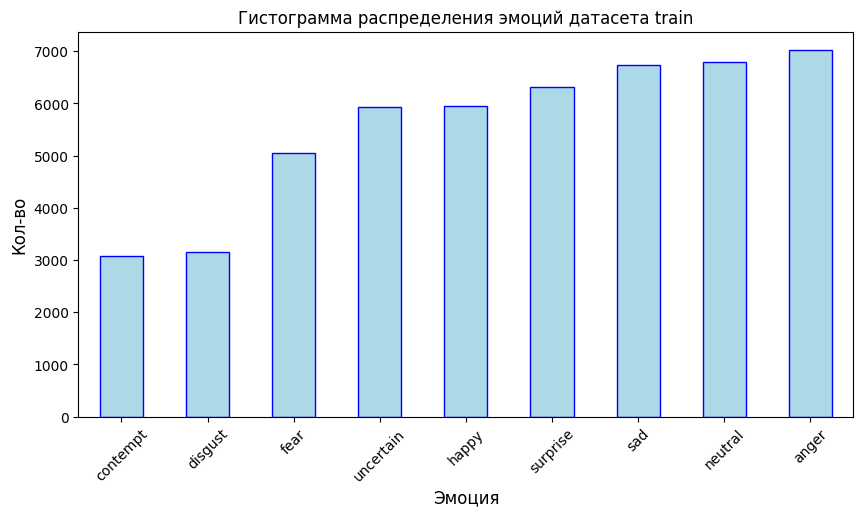

In [ ]:
# гистограмма распределения эмоций датасета train

df_train = pd.read_csv(BASE_DIR/'df_train.csv', sep=',', index_col='index')
df_train_group = df_train.groupby('emotion').agg({'filename': 'count'}).sort_values('filename', ascending = True)
df_train_group['emotion'] = df_train_group.index

ax = df_train_group[['emotion','filename']].plot(kind='bar', title ="Гистограмма распределения эмоций датасета train",
                                                      figsize=(10, 5), legend=False, rot = 45,
                                                      fontsize = 10, color = 'lightblue',
                                                      edgecolor = 'blue',linewidth = 1)
ax.set_xlabel("Эмоция", fontsize=12)
ax.set_ylabel("Кол-во", fontsize=12)

plt.show()

In [ ]:
# Создание датафрейма из набора test

folder_images = PATH_TEST
size_images = dict()

for dirpath, _, filenames in os.walk(folder_images):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            weight = os.path.getsize(image)
            width, heigth = img.size
            size_images[path_image] = {'weight': weight, 'width': width, 'heigth': heigth}

df_test = pd.DataFrame(size_images).T
df_test['notsquare'] = abs(df_test['heigth'] - df_test['width'])
df_test['image_path'] = df_test.index

# сохранение полученного датасета в csv

df_test.to_csv(BASE_DIR/'df_test.csv', sep=',', index_label='index')


In [ ]:
df_test

,weight,width,heigth,notsquare,image_path
0.jpg,8759,300,300,0,0.jpg
1.jpg,27949,547,547,0,1.jpg
10.jpg,10043,254,254,0,10.jpg
100.jpg,73889,902,902,0,100.jpg
1000.jpg,8226,234,234,0,1000.jpg
...,...,...,...,...,...
995.jpg,54272,531,531,0,995.jpg
996.jpg,8453,214,214,0,996.jpg
997.jpg,33380,509,509,0,997.jpg
998.jpg,25757,566,566,0,998.jpg


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0.jpg to 999.jpg
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   weight      5000 non-null   int64 
 1   width       5000 non-null   int64 
 2   heigth      5000 non-null   int64 
 3   notsquare   5000 non-null   int64 
 4   image_path  5000 non-null   object
dtypes: int64(4), object(1)
memory usage: 234.4+ KB


In [ ]:
# Удаление дубликатов

df_clean = df_train[~df_train.duplicated(subset = ['hash'], keep = 'first')].copy()
df_clean = df_clean.groupby('hash').agg({'emotion': 'nunique', 'filename' : 'nunique'})
assert sum(set(df_clean.emotion.tolist())) == 1
assert sum(set(df_clean.filename.tolist())) == 1
print('Дубликаты изображений удалены успешно. Удалено', 50046 - df_clean.shape[0],'записей о файлах.\n')
df_train = df_train.loc[~df_train.duplicated(subset = ['hash'], keep = 'first')]
df_train.reset_index(drop=True, inplace=True)
df_train.drop(['hash'], axis=1, inplace=True)
df_train

Дубликаты изображений удалены успешно. Удалено 736 записей о файлах.



<ipython-input-18-3044d6b16a3e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['hash'], axis=1, inplace=True)


,weight,width,heigth,emotion,filename,notsquare
0,2849,183,183,anger,0.jpg,0
1,20164,489,489,anger,06666.jpg,0
2,69752,749,749,anger,1.jpg,0
3,10299,261,261,anger,10.jpg,0
4,9250,234,234,anger,100.jpg,0
...,...,...,...,...,...,...
49305,5697,224,224,uncertain,995.jpg,0
49306,9378,228,228,uncertain,996.jpg,0
49307,37836,773,773,uncertain,997.jpg,0
49308,13117,283,283,uncertain,998.jpg,0


In [ ]:
# добавление столбца image_path

path_row = []
for row in df_train.itertuples():
    image_path = row[4] + str('/') + row[5]
    path_row.append(image_path)

column_values = pd.Series(path_row)
df_train.insert(loc=6, column='image_path', value=column_values)

In [ ]:
# сохранение полученного датасета в csv

df_train.to_csv(BASE_DIR/'df_train.csv', sep=',', index_label='index')

# 2. Препроцессинг

2.1 Разделение датасета на обучающую и валидационную выборки

In [5]:
# загрузка Train.csv из kaggle

df = pd.read_csv("train.csv", sep=',', index_col=0)

In [6]:
df.head(3)

,image_path,emotion
0,./train/anger/0.jpg,anger
1,./train/anger/1.jpg,anger
2,./train/anger/10.jpg,anger


In [7]:
# Загрузка датасетов train и test

df_train = pd.read_csv(BASE_DIR / 'df_train.csv', sep=',', index_col='index')
df_test = pd.read_csv(BASE_DIR / 'df_test.csv', sep=',', index_col='index')

In [8]:
def stratified_split_ds(data, validation_split=0.2, seed=42):
    """Stratified split of dataframe base on column 'emotion'."""
    rnd_seed = np.random.RandomState(seed=seed)
    val_indices = []
    for category in data['emotion'].unique():
        sub_df = data[data['emotion'] == category]
        sub_val_len = int(sub_df.shape[0] * validation_split)
        cat_val_idx = rnd_seed.choice(sub_df.index, size=sub_val_len, replace=False)
        val_indices.extend(list(cat_val_idx))

    return data.drop(val_indices, axis=0), data.loc[val_indices,:]

df_train_v1, df_test_v1 = stratified_split_ds(df_train)
df_train_v1.to_csv(BASE_DIR / 'df_train_v1.csv', sep=',', index_label='index')
df_test_v1.to_csv(BASE_DIR / 'df_test_v1.csv', sep=',', index_label='index')
print('-------------------')
print(f'Train dataset size: {df_train_v1.shape[0]}')
print(f'Test dataset size: {df_test_v1.shape[0]}')

-------------------
Train dataset size: 39451
Test dataset size: 9859


In [9]:
df_train_v1 = pd.read_csv(BASE_DIR/'df_train_v1.csv', sep=',', index_col='index')
df_test_v1 = pd.read_csv(BASE_DIR/'df_test_v1.csv', sep=',', index_col='index')

In [10]:
df_train_v1

,weight,width,heigth,emotion,filename,notsquare,image_path
index,,,,,,,
0,2849,183,183,anger,0.jpg,0,anger/0.jpg
1,20164,489,489,anger,06666.jpg,0,anger/06666.jpg
2,69752,749,749,anger,1.jpg,0,anger/1.jpg
3,10299,261,261,anger,10.jpg,0,anger/10.jpg
4,9250,234,234,anger,100.jpg,0,anger/100.jpg
...,...,...,...,...,...,...,...
49305,5697,224,224,uncertain,995.jpg,0,uncertain/995.jpg
49306,9378,228,228,uncertain,996.jpg,0,uncertain/996.jpg
49307,37836,773,773,uncertain,997.jpg,0,uncertain/997.jpg


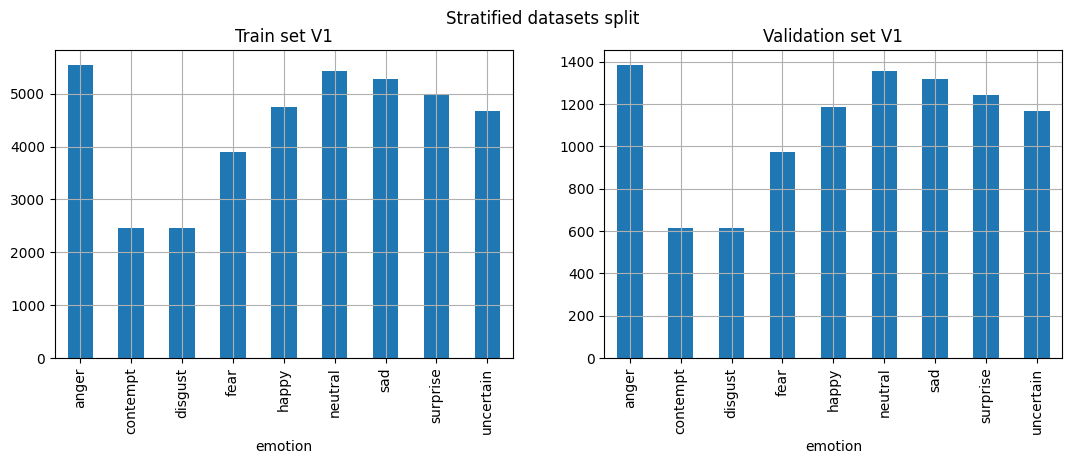

In [11]:
plt.figure(figsize=(13,4))
plt.suptitle('Stratified datasets split')
plt.subplot(1, 2, 1)
df_train_v1.groupby('emotion')['image_path'].count().plot.bar()
plt.grid()
plt.title('Train set V1')
plt.subplot(1, 2, 2)
df_test_v1.groupby('emotion')['image_path'].count().plot.bar()
plt.title('Validation set V1')
plt.grid()
plt.show()

2.2 Выбор модели и обучение

За основу решено взять BiT-M r50x1 [модель](https://https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html) (архитектура ResNet-50, веса обученны на ImageNet-21k). Плюс Hyperrule fine-tuning.

In [11]:
def load_BiT_dataset(batch_size, image_size):
    """
    Create image generators for train and test data with specified parameters.
    """
    train_df = pd.read_csv(BASE_DIR/f'df_train_v1.csv', sep=',', index_col='index')
    test_df = pd.read_csv(BASE_DIR/f'df_test_v1.csv', sep=',', index_col='index')

    train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=15,
                                     width_shift_range=.05,
                                     height_shift_range=.05,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     brightness_range=(0.5,1.5),
                                     shear_range=0.2,
                                     zoom_range=.1)

    train_data_gen = train_generator.flow_from_dataframe(dataframe=train_df,
                                                x_col='image_path',
                                                y_col='emotion',
                                                target_size=(image_size, image_size),
                                                batch_size=batch_size,
                                                class_mode='sparse',
                                                directory=str(PATH_TRAIN),
                                                shuffle=True,
                                                interpolation='nearest',
                                                validate_filenames=False
                                                )
    val_generator = ImageDataGenerator(rescale=1./255)

    val_data_gen = val_generator.flow_from_dataframe(dataframe=test_df,
                                                         directory=str(PATH_TRAIN),
                                                         x_col='image_path',
                                                         y_col='emotion',
                                                         target_size=(image_size, image_size),
                                                         batch_size=batch_size,
                                                         class_mode='sparse',
                                                         shuffle=False,
                                                         interpolation='nearest',
                                                         validate_filenames=False
                                                        )

    return train_data_gen, val_data_gen

In [12]:
train_data_gen, val_data_gen  = load_BiT_dataset(batch_size=64, image_size=224)

Found 39451 non-validated image filenames belonging to 9 classes.
Found 9859 non-validated image filenames belonging to 9 classes.


In [13]:
N_CLASSES = len(train_data_gen.class_indices)
BATCH_SIZE = 64
IMG_SIZE = 224

In [18]:
cpt_path = str(BASE_DIR  / 'model_emotion/checkpoint_best_BiT_weigts.hdf5')

# LearningRateScheduler
def scheduler(epoch, lr):
   if epoch < 5:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

# BiT HyperRule
model_emotion = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3), name='input'),
            hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=True),
            tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='output', kernel_initializer='zeros')
        ])

my_callbacks = [PlotLossesCallback(),
                tf.keras.callbacks.ModelCheckpoint(cpt_path,
                                                   monitor='val_sparse_categorical_accuracy',
                                                   verbose=1,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   save_freq='epoch',
                                                   mode='max'),
                tf.keras.callbacks.LearningRateScheduler(scheduler)]

model_emotion.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
# Обучение

EPOCHS = 10
history = model_emotion.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=my_callbacks)

In [20]:
emotion_mapping = dict(enumerate(df['emotion'].unique()))

In [21]:
# Сохранение лучшего чекпоинта

model_emotion.save(BASE_DIR  / 'model_emotion/checkpoint_best_BiT')
model_emotion.load_weights(BASE_DIR  / 'model_emotion/checkpoint_best_BiT_weigts.hdf5')
loss, acc = model_emotion.evaluate(val_data_gen)

155/155 [==============================] - 2741s 18s/step - loss: 1.2999 - sparse_categorical_accuracy: 0.5363


  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  0%|          | 1/5000 [00:03<4:30:58,  3.25s/it]

1/1 [==============================] - 0s 37ms/step


  0%|          | 2/5000 [00:03<2:13:30,  1.60s/it]

1/1 [==============================] - 0s 33ms/step


  0%|          | 3/5000 [00:04<1:27:15,  1.05s/it]

1/1 [==============================] - 0s 35ms/step


  0%|          | 4/5000 [00:04<1:05:17,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 5/5000 [00:04<53:23,  1.56it/s]  

1/1 [==============================] - 0s 30ms/step


  0%|          | 6/5000 [00:05<45:30,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 7/5000 [00:05<43:55,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 8/5000 [00:06<40:53,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 9/5000 [00:06<39:22,  2.11it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 10/5000 [00:06<38:14,  2.18it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 11/5000 [00:07<37:07,  2.24it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 12/5000 [00:07<36:38,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 13/5000 [00:08<36:33,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 14/5000 [00:08<36:55,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 15/5000 [00:09<34:03,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 16/5000 [00:09<35:32,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 17/5000 [00:09<35:38,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 18/5000 [00:10<36:11,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 19/5000 [00:10<37:19,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 20/5000 [00:11<36:09,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 21/5000 [00:11<33:32,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 22/5000 [00:12<34:50,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 23/5000 [00:12<34:09,  2.43it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 24/5000 [00:12<33:35,  2.47it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 25/5000 [00:13<35:10,  2.36it/s]

1/1 [==============================] - 0s 51ms/step


  1%|          | 26/5000 [00:13<32:44,  2.53it/s]

1/1 [==============================] - 0s 61ms/step


  1%|          | 27/5000 [00:14<32:52,  2.52it/s]

1/1 [==============================] - 0s 52ms/step


  1%|          | 28/5000 [00:14<36:51,  2.25it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 29/5000 [00:15<36:44,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 30/5000 [00:15<33:34,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 31/5000 [00:15<37:01,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 32/5000 [00:16<37:53,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 33/5000 [00:16<36:38,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 34/5000 [00:17<36:31,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 35/5000 [00:17<33:31,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 36/5000 [00:17<33:15,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 37/5000 [00:18<33:09,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 38/5000 [00:18<31:27,  2.63it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 39/5000 [00:19<32:50,  2.52it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 40/5000 [00:19<33:35,  2.46it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 41/5000 [00:20<35:30,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 42/5000 [00:20<33:49,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 43/5000 [00:20<31:42,  2.61it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 44/5000 [00:21<30:25,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 45/5000 [00:21<32:19,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 46/5000 [00:21<31:19,  2.64it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 47/5000 [00:22<32:45,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 48/5000 [00:22<33:20,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 49/5000 [00:23<34:13,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 50/5000 [00:23<33:51,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 51/5000 [00:23<34:48,  2.37it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 52/5000 [00:24<33:21,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 53/5000 [00:24<34:04,  2.42it/s]

1/1 [==============================] - 0s 68ms/step


  1%|          | 54/5000 [00:25<41:02,  2.01it/s]

1/1 [==============================] - 0s 51ms/step


  1%|          | 55/5000 [00:25<39:00,  2.11it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 56/5000 [00:26<37:44,  2.18it/s]

1/1 [==============================] - 0s 51ms/step


  1%|          | 57/5000 [00:26<35:21,  2.33it/s]

1/1 [==============================] - 0s 60ms/step


  1%|          | 58/5000 [00:27<35:32,  2.32it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 59/5000 [00:27<36:06,  2.28it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 60/5000 [00:27<35:22,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 61/5000 [00:28<34:21,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 62/5000 [00:28<34:51,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 63/5000 [00:29<33:30,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 64/5000 [00:29<31:40,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 65/5000 [00:29<32:18,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 66/5000 [00:30<31:49,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 67/5000 [00:30<32:13,  2.55it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 68/5000 [00:31<33:47,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 69/5000 [00:31<34:31,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 70/5000 [00:31<32:20,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 71/5000 [00:32<34:43,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 72/5000 [00:32<35:03,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 73/5000 [00:33<32:12,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 74/5000 [00:33<32:51,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 75/5000 [00:33<32:37,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 76/5000 [00:34<34:02,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 77/5000 [00:34<35:26,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 78/5000 [00:35<33:05,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 79/5000 [00:35<33:42,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 80/5000 [00:36<35:32,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 81/5000 [00:36<35:37,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 82/5000 [00:37<34:45,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 83/5000 [00:37<33:13,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 84/5000 [00:37<32:53,  2.49it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 85/5000 [00:38<32:14,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 86/5000 [00:38<30:32,  2.68it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 87/5000 [00:38<32:26,  2.52it/s]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 88/5000 [00:39<31:48,  2.57it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 89/5000 [00:39<30:51,  2.65it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 90/5000 [00:40<31:59,  2.56it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 91/5000 [00:40<33:33,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 92/5000 [00:40<33:42,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 93/5000 [00:41<33:30,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 94/5000 [00:41<34:38,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 95/5000 [00:42<36:03,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 96/5000 [00:42<36:04,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 97/5000 [00:43<35:20,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 98/5000 [00:43<35:52,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 99/5000 [00:43<35:18,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 100/5000 [00:44<42:09,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 101/5000 [00:45<41:49,  1.95it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 102/5000 [00:45<36:41,  2.22it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 103/5000 [00:45<37:19,  2.19it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 104/5000 [00:46<36:12,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 105/5000 [00:46<35:15,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 106/5000 [00:47<35:47,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 107/5000 [00:47<32:59,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 108/5000 [00:48<33:29,  2.43it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 109/5000 [00:48<33:25,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 110/5000 [00:48<33:23,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 111/5000 [00:49<34:33,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 112/5000 [00:49<32:39,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 113/5000 [00:49<28:42,  2.84it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 114/5000 [00:50<30:50,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 115/5000 [00:50<28:30,  2.86it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 116/5000 [00:51<30:50,  2.64it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 117/5000 [00:51<30:29,  2.67it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 118/5000 [00:51<32:12,  2.53it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 119/5000 [00:52<32:52,  2.47it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 120/5000 [00:52<33:57,  2.40it/s]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 121/5000 [00:53<35:51,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 122/5000 [00:53<33:26,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 123/5000 [00:53<32:24,  2.51it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 124/5000 [00:54<32:24,  2.51it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▎         | 125/5000 [00:54<32:52,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 126/5000 [00:55<33:34,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 127/5000 [00:55<31:17,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 128/5000 [00:55<33:07,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 129/5000 [00:56<33:20,  2.43it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 130/5000 [00:56<33:20,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 131/5000 [00:57<33:08,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 132/5000 [00:57<33:17,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 133/5000 [00:58<36:10,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 134/5000 [00:58<35:11,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 135/5000 [00:58<35:49,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 136/5000 [00:59<36:10,  2.24it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 137/5000 [00:59<37:02,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 138/5000 [01:00<35:29,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 139/5000 [01:00<34:31,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 140/5000 [01:01<35:39,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 141/5000 [01:01<32:31,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 142/5000 [01:02<35:00,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 143/5000 [01:02<35:53,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 144/5000 [01:02<36:02,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 145/5000 [01:03<35:41,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 146/5000 [01:03<35:51,  2.26it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 147/5000 [01:04<34:07,  2.37it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 148/5000 [01:04<34:03,  2.37it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 149/5000 [01:04<31:52,  2.54it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 150/5000 [01:05<33:27,  2.42it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 151/5000 [01:05<33:30,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 152/5000 [01:06<30:21,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 153/5000 [01:06<31:10,  2.59it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 154/5000 [01:06<30:10,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 155/5000 [01:07<31:05,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 156/5000 [01:07<31:51,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 157/5000 [01:08<33:58,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 158/5000 [01:08<31:44,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 159/5000 [01:08<33:15,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 160/5000 [01:09<32:45,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 161/5000 [01:09<32:16,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 162/5000 [01:10<33:02,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 163/5000 [01:10<33:14,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 164/5000 [01:10<30:02,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 165/5000 [01:11<30:34,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 166/5000 [01:11<32:41,  2.46it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 167/5000 [01:12<32:54,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 168/5000 [01:12<29:29,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 169/5000 [01:12<30:14,  2.66it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 170/5000 [01:13<32:11,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 171/5000 [01:13<32:54,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 172/5000 [01:14<33:24,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 173/5000 [01:14<34:54,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 174/5000 [01:14<33:47,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 175/5000 [01:15<34:08,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▎         | 176/5000 [01:15<35:26,  2.27it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 177/5000 [01:16<42:08,  1.91it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▎         | 178/5000 [01:16<38:03,  2.11it/s]

1/1 [==============================] - 0s 51ms/step


  4%|▎         | 179/5000 [01:17<36:40,  2.19it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▎         | 180/5000 [01:17<37:54,  2.12it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▎         | 181/5000 [01:18<37:08,  2.16it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▎         | 182/5000 [01:18<34:14,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 183/5000 [01:19<33:56,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▎         | 184/5000 [01:19<33:48,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 185/5000 [01:19<32:49,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 186/5000 [01:20<32:47,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 187/5000 [01:20<34:34,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 188/5000 [01:21<34:34,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 189/5000 [01:21<33:21,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 190/5000 [01:21<32:09,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 191/5000 [01:22<32:02,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 192/5000 [01:22<33:30,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 193/5000 [01:23<33:14,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 194/5000 [01:23<31:40,  2.53it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 195/5000 [01:24<32:57,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 196/5000 [01:24<33:44,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 197/5000 [01:24<33:59,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 198/5000 [01:25<33:50,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 199/5000 [01:25<34:12,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 200/5000 [01:26<34:03,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 201/5000 [01:26<34:58,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 202/5000 [01:27<35:31,  2.25it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 203/5000 [01:27<35:54,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 204/5000 [01:28<36:02,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 205/5000 [01:28<34:02,  2.35it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 206/5000 [01:28<34:52,  2.29it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 207/5000 [01:29<35:39,  2.24it/s]

1/1 [==============================] - 0s 55ms/step


  4%|▍         | 208/5000 [01:29<36:04,  2.21it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 209/5000 [01:30<35:59,  2.22it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 210/5000 [01:30<36:20,  2.20it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 211/5000 [01:31<33:44,  2.36it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 212/5000 [01:31<31:41,  2.52it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 213/5000 [01:31<31:32,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 214/5000 [01:32<31:05,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 215/5000 [01:32<30:12,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 216/5000 [01:32<29:50,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 217/5000 [01:33<31:03,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 218/5000 [01:33<29:46,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 219/5000 [01:33<28:44,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 220/5000 [01:34<29:24,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 221/5000 [01:34<31:03,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 222/5000 [01:35<31:52,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 223/5000 [01:35<29:22,  2.71it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 224/5000 [01:35<30:50,  2.58it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 225/5000 [01:36<31:24,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 226/5000 [01:36<30:35,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 227/5000 [01:37<30:31,  2.61it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 228/5000 [01:37<29:25,  2.70it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 229/5000 [01:37<30:23,  2.62it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 230/5000 [01:38<30:44,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 231/5000 [01:38<33:17,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 232/5000 [01:39<33:02,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 233/5000 [01:39<32:41,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 234/5000 [01:39<32:44,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 235/5000 [01:40<31:57,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 236/5000 [01:40<31:56,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 237/5000 [01:41<31:38,  2.51it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▍         | 238/5000 [01:41<31:49,  2.49it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 239/5000 [01:41<31:13,  2.54it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 240/5000 [01:42<33:47,  2.35it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▍         | 241/5000 [01:42<35:24,  2.24it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 242/5000 [01:43<32:46,  2.42it/s]

1/1 [==============================] - 0s 51ms/step


  5%|▍         | 243/5000 [01:43<30:11,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 244/5000 [01:43<31:56,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 245/5000 [01:44<29:41,  2.67it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 246/5000 [01:44<30:01,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 247/5000 [01:44<28:08,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 248/5000 [01:45<28:41,  2.76it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 249/5000 [01:45<34:33,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 250/5000 [01:46<31:45,  2.49it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 251/5000 [01:46<32:46,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 252/5000 [01:47<31:26,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 253/5000 [01:47<32:02,  2.47it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 254/5000 [01:47<30:31,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 255/5000 [01:48<31:01,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 256/5000 [01:48<29:53,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 257/5000 [01:49<32:53,  2.40it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▌         | 258/5000 [01:49<33:22,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 259/5000 [01:49<30:23,  2.60it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 260/5000 [01:50<33:46,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 261/5000 [01:50<33:49,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 262/5000 [01:51<32:33,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 263/5000 [01:51<33:13,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 264/5000 [01:52<33:00,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 265/5000 [01:52<29:18,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 266/5000 [01:52<29:16,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 267/5000 [01:53<28:34,  2.76it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 268/5000 [01:53<31:21,  2.52it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 269/5000 [01:53<32:54,  2.40it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▌         | 270/5000 [01:54<30:22,  2.60it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 271/5000 [01:54<30:46,  2.56it/s]

1/1 [==============================] - 0s 51ms/step


  5%|▌         | 272/5000 [01:55<33:25,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 273/5000 [01:55<33:19,  2.36it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▌         | 274/5000 [01:56<33:07,  2.38it/s]

1/1 [==============================] - 0s 57ms/step


  6%|▌         | 275/5000 [01:56<34:35,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 276/5000 [01:57<36:10,  2.18it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 277/5000 [01:57<32:17,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 278/5000 [01:57<30:47,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 279/5000 [01:58<31:29,  2.50it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 280/5000 [01:58<33:28,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 281/5000 [01:58<33:49,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 282/5000 [01:59<32:25,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 283/5000 [01:59<32:33,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 284/5000 [02:00<34:11,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 285/5000 [02:00<31:37,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 286/5000 [02:00<31:40,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 287/5000 [02:01<32:01,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 288/5000 [02:01<31:53,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 289/5000 [02:02<32:25,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 290/5000 [02:02<29:36,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 291/5000 [02:02<27:20,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 292/5000 [02:03<29:03,  2.70it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 293/5000 [02:03<30:08,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 294/5000 [02:04<29:44,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 295/5000 [02:04<31:24,  2.50it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 296/5000 [02:04<30:56,  2.53it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 297/5000 [02:05<31:52,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 298/5000 [02:05<32:19,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 299/5000 [02:06<31:37,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 300/5000 [02:06<29:08,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 301/5000 [02:06<27:40,  2.83it/s]

1/1 [==============================] - 0s 57ms/step


  6%|▌         | 302/5000 [02:07<28:17,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 303/5000 [02:07<29:42,  2.64it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 304/5000 [02:07<30:14,  2.59it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 305/5000 [02:08<33:01,  2.37it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 306/5000 [02:08<34:38,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 307/5000 [02:09<33:51,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 308/5000 [02:09<36:20,  2.15it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 309/5000 [02:10<31:34,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 310/5000 [02:10<31:51,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 311/5000 [02:10<32:52,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 312/5000 [02:11<32:28,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 313/5000 [02:11<30:33,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 314/5000 [02:12<31:46,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 315/5000 [02:12<30:17,  2.58it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 316/5000 [02:12<30:19,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 317/5000 [02:13<32:02,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 318/5000 [02:13<32:03,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 319/5000 [02:14<32:16,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 320/5000 [02:14<32:15,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 321/5000 [02:14<30:30,  2.56it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▋         | 322/5000 [02:15<31:02,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 323/5000 [02:15<30:29,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 324/5000 [02:16<36:58,  2.11it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 325/5000 [02:16<35:13,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 326/5000 [02:17<34:12,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 327/5000 [02:17<34:08,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 328/5000 [02:17<31:23,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 329/5000 [02:18<31:54,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 330/5000 [02:18<33:19,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 331/5000 [02:19<31:57,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 332/5000 [02:19<31:52,  2.44it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 333/5000 [02:20<32:11,  2.42it/s]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 334/5000 [02:20<30:02,  2.59it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 335/5000 [02:20<30:17,  2.57it/s]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 336/5000 [02:21<34:59,  2.22it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 337/5000 [02:21<35:01,  2.22it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 338/5000 [02:22<34:12,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 339/5000 [02:22<33:36,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 340/5000 [02:23<33:17,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 341/5000 [02:23<32:46,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 342/5000 [02:23<33:27,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 343/5000 [02:24<32:18,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 344/5000 [02:24<32:12,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 345/5000 [02:25<33:10,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 346/5000 [02:25<32:30,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 347/5000 [02:25<29:11,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 348/5000 [02:26<29:15,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 349/5000 [02:26<30:43,  2.52it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 350/5000 [02:27<30:44,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 351/5000 [02:27<30:40,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 352/5000 [02:27<30:11,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 353/5000 [02:28<30:00,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 354/5000 [02:28<31:42,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 355/5000 [02:29<30:26,  2.54it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 356/5000 [02:29<32:02,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 357/5000 [02:29<32:31,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 358/5000 [02:30<32:21,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 359/5000 [02:30<34:10,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 360/5000 [02:31<31:15,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 361/5000 [02:31<31:22,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 362/5000 [02:32<32:04,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 363/5000 [02:32<29:40,  2.60it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 364/5000 [02:32<30:47,  2.51it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 365/5000 [02:33<31:00,  2.49it/s]

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 366/5000 [02:33<28:36,  2.70it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 367/5000 [02:33<31:05,  2.48it/s]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 368/5000 [02:34<31:16,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 369/5000 [02:34<31:32,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 370/5000 [02:35<29:55,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 371/5000 [02:35<28:19,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 372/5000 [02:35<28:43,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 373/5000 [02:36<28:44,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 374/5000 [02:36<26:09,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 375/5000 [02:36<26:59,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 376/5000 [02:37<28:02,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 377/5000 [02:37<27:40,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 378/5000 [02:38<29:56,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 379/5000 [02:38<28:09,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 380/5000 [02:39<38:49,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 381/5000 [02:39<36:53,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 382/5000 [02:40<37:31,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 383/5000 [02:40<36:55,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 384/5000 [02:40<35:10,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 385/5000 [02:41<34:50,  2.21it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 386/5000 [02:41<31:51,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 387/5000 [02:42<34:00,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 388/5000 [02:42<30:39,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 389/5000 [02:42<30:28,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 390/5000 [02:43<31:27,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 391/5000 [02:43<31:00,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 392/5000 [02:44<31:21,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 393/5000 [02:44<30:40,  2.50it/s]

1/1 [==============================] - 0s 52ms/step


  8%|▊         | 394/5000 [02:44<28:39,  2.68it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 395/5000 [02:45<31:32,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 396/5000 [02:45<29:07,  2.63it/s]

1/1 [==============================] - 0s 51ms/step


  8%|▊         | 397/5000 [02:46<28:48,  2.66it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 398/5000 [02:46<30:43,  2.50it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 399/5000 [02:46<31:21,  2.45it/s]

1/1 [==============================] - 0s 51ms/step


  8%|▊         | 400/5000 [02:47<31:46,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 401/5000 [02:47<31:16,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 402/5000 [02:48<31:07,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 403/5000 [02:48<31:24,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 404/5000 [02:49<32:10,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 405/5000 [02:49<32:23,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 406/5000 [02:49<29:50,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 407/5000 [02:50<30:43,  2.49it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 408/5000 [02:50<30:34,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 409/5000 [02:50<30:15,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 410/5000 [02:51<28:04,  2.73it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 411/5000 [02:51<26:29,  2.89it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 412/5000 [02:51<28:06,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 413/5000 [02:52<28:30,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 414/5000 [02:52<30:13,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 415/5000 [02:53<31:20,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 416/5000 [02:53<30:58,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 417/5000 [02:54<30:07,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 418/5000 [02:54<31:15,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 419/5000 [02:54<30:29,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 420/5000 [02:55<31:28,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 421/5000 [02:55<31:12,  2.45it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 422/5000 [02:56<32:30,  2.35it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 423/5000 [02:56<32:22,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 424/5000 [02:56<31:14,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 425/5000 [02:57<29:29,  2.59it/s]

1/1 [==============================] - 0s 56ms/step


  9%|▊         | 426/5000 [02:57<31:02,  2.46it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▊         | 427/5000 [02:58<30:43,  2.48it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▊         | 428/5000 [02:58<36:44,  2.07it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▊         | 429/5000 [02:59<34:47,  2.19it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▊         | 430/5000 [02:59<32:25,  2.35it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▊         | 431/5000 [03:00<33:19,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 432/5000 [03:00<31:50,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 433/5000 [03:00<31:06,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 434/5000 [03:01<30:48,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 435/5000 [03:01<31:31,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 436/5000 [03:02<31:02,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 437/5000 [03:02<32:30,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 438/5000 [03:02<32:11,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 439/5000 [03:03<31:16,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 440/5000 [03:03<31:35,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 441/5000 [03:04<29:14,  2.60it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 442/5000 [03:04<31:08,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 443/5000 [03:04<31:09,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 444/5000 [03:05<28:29,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 445/5000 [03:05<28:01,  2.71it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 446/5000 [03:05<28:38,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 447/5000 [03:06<27:55,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 448/5000 [03:06<26:24,  2.87it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 449/5000 [03:06<27:39,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 450/5000 [03:07<28:26,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 451/5000 [03:07<29:48,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 452/5000 [03:08<31:04,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 453/5000 [03:08<31:26,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 454/5000 [03:08<28:27,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 455/5000 [03:09<25:46,  2.94it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 456/5000 [03:09<27:35,  2.74it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 457/5000 [03:10<28:03,  2.70it/s]

1/1 [==============================] - 0s 53ms/step


  9%|▉         | 458/5000 [03:10<28:56,  2.62it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 459/5000 [03:10<29:58,  2.53it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 460/5000 [03:11<29:47,  2.54it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 461/5000 [03:11<30:29,  2.48it/s]

1/1 [==============================] - 0s 52ms/step


  9%|▉         | 462/5000 [03:12<34:00,  2.22it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 463/5000 [03:12<34:39,  2.18it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 464/5000 [03:13<31:52,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 465/5000 [03:13<30:29,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 466/5000 [03:13<31:18,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 467/5000 [03:14<33:03,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 468/5000 [03:14<32:37,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 469/5000 [03:15<31:17,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 470/5000 [03:15<29:48,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 471/5000 [03:15<27:32,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 472/5000 [03:16<26:20,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 473/5000 [03:16<29:14,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 474/5000 [03:17<30:09,  2.50it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 475/5000 [03:17<31:00,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 476/5000 [03:17<31:14,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 477/5000 [03:18<28:15,  2.67it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 478/5000 [03:18<28:53,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 479/5000 [03:18<26:23,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 480/5000 [03:19<27:16,  2.76it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 481/5000 [03:19<27:42,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 482/5000 [03:20<28:41,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 483/5000 [03:20<28:37,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 484/5000 [03:20<29:52,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 485/5000 [03:21<29:25,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 486/5000 [03:21<30:35,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 487/5000 [03:21<28:18,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 488/5000 [03:22<29:57,  2.51it/s]

1/1 [==============================] - 0s 51ms/step


 10%|▉         | 489/5000 [03:22<30:01,  2.50it/s]

1/1 [==============================] - 0s 52ms/step


 10%|▉         | 490/5000 [03:23<30:34,  2.46it/s]

1/1 [==============================] - 0s 50ms/step


 10%|▉         | 491/5000 [03:23<31:43,  2.37it/s]

1/1 [==============================] - 0s 48ms/step


 10%|▉         | 492/5000 [03:23<28:39,  2.62it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 493/5000 [03:24<29:39,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 494/5000 [03:24<29:53,  2.51it/s]

1/1 [==============================] - 0s 57ms/step


 10%|▉         | 495/5000 [03:25<31:18,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 496/5000 [03:25<31:09,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 497/5000 [03:26<30:48,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 498/5000 [03:26<31:09,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 499/5000 [03:26<31:50,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 500/5000 [03:27<30:38,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 501/5000 [03:27<30:41,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 502/5000 [03:28<31:15,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 503/5000 [03:28<31:27,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 504/5000 [03:29<31:59,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 505/5000 [03:29<32:34,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 506/5000 [03:29<31:24,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 507/5000 [03:30<31:39,  2.37it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 508/5000 [03:30<29:08,  2.57it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 509/5000 [03:30<28:56,  2.59it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 510/5000 [03:31<30:03,  2.49it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 511/5000 [03:31<32:04,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 512/5000 [03:32<32:00,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 513/5000 [03:32<31:05,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 514/5000 [03:33<32:10,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 515/5000 [03:33<32:21,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 516/5000 [03:33<30:19,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 517/5000 [03:34<31:01,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 518/5000 [03:34<31:21,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 519/5000 [03:35<28:37,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 520/5000 [03:35<30:30,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 521/5000 [03:36<30:56,  2.41it/s]

1/1 [==============================] - 0s 48ms/step


 10%|█         | 522/5000 [03:36<29:14,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 523/5000 [03:36<30:08,  2.48it/s]

1/1 [==============================] - 0s 52ms/step


 10%|█         | 524/5000 [03:37<30:27,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 525/5000 [03:37<32:56,  2.26it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█         | 526/5000 [03:38<31:59,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 527/5000 [03:38<31:57,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 528/5000 [03:38<30:47,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 529/5000 [03:39<31:54,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 530/5000 [03:39<32:16,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 531/5000 [03:40<29:56,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 532/5000 [03:40<28:11,  2.64it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 533/5000 [03:40<29:42,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 534/5000 [03:41<29:39,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 535/5000 [03:41<30:51,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 536/5000 [03:42<32:02,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 537/5000 [03:42<33:33,  2.22it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 538/5000 [03:43<30:54,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 539/5000 [03:43<31:17,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 540/5000 [03:43<30:53,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 541/5000 [03:44<31:31,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 542/5000 [03:44<30:51,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 543/5000 [03:45<30:26,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 544/5000 [03:45<29:54,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 545/5000 [03:45<27:57,  2.66it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 546/5000 [03:46<28:44,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 547/5000 [03:46<26:44,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 548/5000 [03:46<27:19,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 549/5000 [03:47<26:20,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 550/5000 [03:47<25:44,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 551/5000 [03:48<28:07,  2.64it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█         | 552/5000 [03:48<29:40,  2.50it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█         | 553/5000 [03:49<32:46,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


 11%|█         | 554/5000 [03:49<32:05,  2.31it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█         | 555/5000 [03:49<32:04,  2.31it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 556/5000 [03:50<34:26,  2.15it/s]

1/1 [==============================] - 0s 56ms/step


 11%|█         | 557/5000 [03:50<33:53,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 558/5000 [03:51<32:49,  2.26it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 559/5000 [03:51<32:53,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 560/5000 [03:52<31:10,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 561/5000 [03:52<30:19,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 562/5000 [03:52<30:47,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 563/5000 [03:53<31:01,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 564/5000 [03:53<31:15,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 565/5000 [03:54<28:24,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 566/5000 [03:54<27:38,  2.67it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 567/5000 [03:54<30:50,  2.40it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 568/5000 [03:55<27:23,  2.70it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 569/5000 [03:55<28:35,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 570/5000 [03:56<28:10,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 571/5000 [03:56<28:10,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 572/5000 [03:56<26:25,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 573/5000 [03:57<28:03,  2.63it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 574/5000 [03:57<26:41,  2.76it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 575/5000 [03:57<26:29,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 576/5000 [03:58<25:13,  2.92it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 577/5000 [03:58<26:12,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 578/5000 [03:58<27:31,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 579/5000 [03:59<27:34,  2.67it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 580/5000 [03:59<30:08,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 581/5000 [04:00<29:30,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 582/5000 [04:00<29:13,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 583/5000 [04:01<31:14,  2.36it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 584/5000 [04:01<32:54,  2.24it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 585/5000 [04:01<32:46,  2.25it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 586/5000 [04:02<29:56,  2.46it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 587/5000 [04:02<30:51,  2.38it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 588/5000 [04:03<29:04,  2.53it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 589/5000 [04:03<29:03,  2.53it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 590/5000 [04:03<29:21,  2.50it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 591/5000 [04:04<30:14,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 592/5000 [04:04<28:41,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 593/5000 [04:04<26:45,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 594/5000 [04:05<28:03,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 595/5000 [04:05<26:29,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 596/5000 [04:06<28:31,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 597/5000 [04:06<29:52,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 598/5000 [04:06<27:38,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 599/5000 [04:07<28:57,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 600/5000 [04:07<26:52,  2.73it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 601/5000 [04:08<26:19,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 602/5000 [04:08<26:56,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 603/5000 [04:08<25:16,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 604/5000 [04:09<26:56,  2.72it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 605/5000 [04:09<29:42,  2.47it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 606/5000 [04:10<29:49,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 607/5000 [04:10<31:32,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 608/5000 [04:10<31:59,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 609/5000 [04:11<31:48,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 610/5000 [04:11<31:24,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 611/5000 [04:12<31:13,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 612/5000 [04:12<30:57,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 613/5000 [04:12<28:04,  2.60it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 614/5000 [04:13<28:48,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 615/5000 [04:13<29:59,  2.44it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 616/5000 [04:14<29:56,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 617/5000 [04:14<28:15,  2.59it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 618/5000 [04:14<25:52,  2.82it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 619/5000 [04:15<28:13,  2.59it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 620/5000 [04:15<29:52,  2.44it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▏        | 621/5000 [04:16<30:45,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 622/5000 [04:16<30:02,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 623/5000 [04:16<29:30,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 624/5000 [04:17<29:34,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▎        | 625/5000 [04:17<31:43,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 626/5000 [04:18<31:23,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 627/5000 [04:18<30:43,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 628/5000 [04:19<31:37,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 629/5000 [04:19<39:19,  1.85it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 630/5000 [04:20<36:13,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 631/5000 [04:20<32:42,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 632/5000 [04:21<33:15,  2.19it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 633/5000 [04:21<32:23,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 634/5000 [04:22<32:25,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 635/5000 [04:22<29:47,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 636/5000 [04:22<29:45,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 637/5000 [04:23<31:02,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 638/5000 [04:23<30:35,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 639/5000 [04:23<29:07,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 640/5000 [04:24<28:58,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 641/5000 [04:24<29:53,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 642/5000 [04:25<30:17,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 643/5000 [04:25<30:08,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 644/5000 [04:26<31:13,  2.32it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 645/5000 [04:26<31:04,  2.34it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 646/5000 [04:26<31:04,  2.34it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 647/5000 [04:27<31:00,  2.34it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 648/5000 [04:27<29:42,  2.44it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 649/5000 [04:28<27:50,  2.60it/s]

1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 650/5000 [04:28<30:46,  2.36it/s]

1/1 [==============================] - 0s 53ms/step


 13%|█▎        | 651/5000 [04:29<31:41,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 652/5000 [04:29<32:33,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 653/5000 [04:29<32:22,  2.24it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 654/5000 [04:30<30:02,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 655/5000 [04:30<27:20,  2.65it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 656/5000 [04:31<28:47,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 657/5000 [04:31<29:06,  2.49it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 658/5000 [04:31<29:12,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 659/5000 [04:32<29:50,  2.42it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 660/5000 [04:32<28:31,  2.54it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 661/5000 [04:32<26:17,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 662/5000 [04:33<26:41,  2.71it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 663/5000 [04:33<27:07,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 664/5000 [04:34<29:44,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 665/5000 [04:34<28:00,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 666/5000 [04:35<30:26,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 667/5000 [04:35<31:05,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 668/5000 [04:35<29:44,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 669/5000 [04:36<29:33,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 670/5000 [04:36<29:25,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 671/5000 [04:37<30:01,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 672/5000 [04:37<29:43,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 673/5000 [04:37<29:36,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 674/5000 [04:38<30:03,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 675/5000 [04:38<29:29,  2.44it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▎        | 676/5000 [04:39<31:18,  2.30it/s]

1/1 [==============================] - 0s 53ms/step


 14%|█▎        | 677/5000 [04:39<31:51,  2.26it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▎        | 678/5000 [04:40<31:51,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▎        | 679/5000 [04:40<29:44,  2.42it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▎        | 680/5000 [04:41<32:05,  2.24it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▎        | 681/5000 [04:41<29:45,  2.42it/s]

1/1 [==============================] - 0s 51ms/step


 14%|█▎        | 682/5000 [04:41<30:21,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▎        | 683/5000 [04:42<28:52,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 684/5000 [04:42<29:32,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 685/5000 [04:43<29:38,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 686/5000 [04:43<28:41,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 687/5000 [04:43<29:08,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 688/5000 [04:44<26:55,  2.67it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 689/5000 [04:44<26:18,  2.73it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 690/5000 [04:44<27:31,  2.61it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 691/5000 [04:45<29:26,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 692/5000 [04:45<30:45,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 693/5000 [04:46<30:39,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 694/5000 [04:46<27:31,  2.61it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 695/5000 [04:46<28:10,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 696/5000 [04:47<30:02,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 697/5000 [04:47<28:33,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 698/5000 [04:48<29:50,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 699/5000 [04:48<31:25,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 700/5000 [04:49<29:46,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 701/5000 [04:49<28:14,  2.54it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 702/5000 [04:49<29:05,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 703/5000 [04:50<28:54,  2.48it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 704/5000 [04:50<29:13,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 705/5000 [04:51<29:51,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 706/5000 [04:51<29:19,  2.44it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 707/5000 [04:51<30:18,  2.36it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 708/5000 [04:52<30:25,  2.35it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 709/5000 [04:52<30:33,  2.34it/s]

1/1 [==============================] - 0s 49ms/step


 14%|█▍        | 710/5000 [04:53<31:05,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 711/5000 [04:53<31:47,  2.25it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 712/5000 [04:54<29:45,  2.40it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 713/5000 [04:54<28:09,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 714/5000 [04:54<28:51,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 715/5000 [04:55<29:18,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 716/5000 [04:55<28:51,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 717/5000 [04:56<28:49,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 718/5000 [04:56<30:50,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 719/5000 [04:56<29:45,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 720/5000 [04:57<29:24,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 721/5000 [04:57<27:30,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 722/5000 [04:58<29:04,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 723/5000 [04:58<29:06,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 724/5000 [04:59<30:44,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 725/5000 [04:59<30:30,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 726/5000 [04:59<27:43,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 727/5000 [05:00<29:17,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 728/5000 [05:00<29:43,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 729/5000 [05:00<27:41,  2.57it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 730/5000 [05:01<30:47,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 731/5000 [05:01<31:22,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 732/5000 [05:02<31:51,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 733/5000 [05:02<32:04,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 734/5000 [05:03<31:10,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 735/5000 [05:03<30:32,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 736/5000 [05:04<31:11,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 737/5000 [05:04<30:29,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 15%|█▍        | 738/5000 [05:04<30:04,  2.36it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 739/5000 [05:05<30:17,  2.34it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 740/5000 [05:05<30:57,  2.29it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 741/5000 [05:06<31:26,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 742/5000 [05:06<30:20,  2.34it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 743/5000 [05:07<30:24,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 744/5000 [05:07<30:32,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 745/5000 [05:07<29:10,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 746/5000 [05:08<29:39,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 747/5000 [05:08<29:26,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 748/5000 [05:09<29:57,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 749/5000 [05:09<29:45,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 750/5000 [05:09<28:20,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 751/5000 [05:10<29:02,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 752/5000 [05:10<29:21,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 753/5000 [05:11<31:58,  2.21it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 754/5000 [05:11<30:55,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 755/5000 [05:12<30:54,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 756/5000 [05:12<32:09,  2.20it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 757/5000 [05:13<31:43,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 758/5000 [05:13<30:56,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 759/5000 [05:13<27:55,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 760/5000 [05:14<29:39,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 761/5000 [05:14<29:16,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 762/5000 [05:15<30:26,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 763/5000 [05:15<30:41,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 764/5000 [05:16<35:34,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 765/5000 [05:16<33:03,  2.14it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 766/5000 [05:17<32:44,  2.16it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 767/5000 [05:17<31:44,  2.22it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 768/5000 [05:17<28:25,  2.48it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 769/5000 [05:18<28:19,  2.49it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 770/5000 [05:18<30:58,  2.28it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 771/5000 [05:19<28:38,  2.46it/s]

1/1 [==============================] - 0s 61ms/step


 15%|█▌        | 772/5000 [05:19<29:40,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 773/5000 [05:20<30:33,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 774/5000 [05:20<30:17,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 775/5000 [05:20<27:22,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 776/5000 [05:21<27:57,  2.52it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 777/5000 [05:21<28:56,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 778/5000 [05:21<27:24,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 779/5000 [05:22<28:48,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 780/5000 [05:22<27:53,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 781/5000 [05:23<26:12,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 782/5000 [05:23<28:18,  2.48it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 783/5000 [05:23<28:02,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 784/5000 [05:24<30:00,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 785/5000 [05:24<30:00,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 786/5000 [05:25<29:44,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 787/5000 [05:25<29:18,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 788/5000 [05:26<31:05,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 789/5000 [05:26<30:01,  2.34it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 790/5000 [05:26<29:00,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 791/5000 [05:27<29:01,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 792/5000 [05:27<27:59,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 793/5000 [05:28<27:57,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 794/5000 [05:28<30:11,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 795/5000 [05:28<27:07,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 796/5000 [05:29<28:05,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 797/5000 [05:29<26:09,  2.68it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 798/5000 [05:30<27:12,  2.57it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 799/5000 [05:30<28:13,  2.48it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 800/5000 [05:30<28:50,  2.43it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 801/5000 [05:31<27:02,  2.59it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 802/5000 [05:31<28:30,  2.45it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 803/5000 [05:32<29:33,  2.37it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 804/5000 [05:32<30:31,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 805/5000 [05:33<29:55,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 806/5000 [05:33<30:03,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 807/5000 [05:33<28:24,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 808/5000 [05:34<30:29,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 809/5000 [05:34<31:10,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 810/5000 [05:35<29:31,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 811/5000 [05:35<26:33,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 812/5000 [05:35<27:03,  2.58it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 813/5000 [05:36<25:52,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 814/5000 [05:36<24:36,  2.84it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 815/5000 [05:37<32:43,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 816/5000 [05:37<30:02,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 817/5000 [05:38<29:13,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 818/5000 [05:38<26:48,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 819/5000 [05:38<25:51,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 820/5000 [05:39<26:29,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 821/5000 [05:39<27:43,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 822/5000 [05:39<28:32,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 823/5000 [05:40<28:50,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 824/5000 [05:40<29:28,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 825/5000 [05:41<28:27,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 826/5000 [05:41<28:18,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 827/5000 [05:42<28:38,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 828/5000 [05:42<27:27,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 829/5000 [05:42<27:20,  2.54it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 830/5000 [05:43<27:42,  2.51it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 831/5000 [05:43<29:12,  2.38it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 832/5000 [05:44<28:52,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 833/5000 [05:44<31:37,  2.20it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 834/5000 [05:45<31:18,  2.22it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 835/5000 [05:45<31:26,  2.21it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 836/5000 [05:45<27:30,  2.52it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 837/5000 [05:46<28:10,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 838/5000 [05:46<24:40,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 839/5000 [05:46<24:55,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 840/5000 [05:47<26:57,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 841/5000 [05:47<27:32,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 842/5000 [05:48<26:44,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 843/5000 [05:48<27:32,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 844/5000 [05:48<27:43,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 845/5000 [05:49<28:21,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 846/5000 [05:49<27:59,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 847/5000 [05:50<28:40,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 848/5000 [05:50<29:07,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 849/5000 [05:50<26:52,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 850/5000 [05:51<25:15,  2.74it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 851/5000 [05:51<25:48,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 852/5000 [05:51<26:14,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 853/5000 [05:52<27:26,  2.52it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 854/5000 [05:52<26:07,  2.64it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 855/5000 [05:53<27:15,  2.53it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 856/5000 [05:53<29:28,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 857/5000 [05:54<29:39,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 858/5000 [05:54<30:09,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 859/5000 [05:55<30:28,  2.26it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 860/5000 [05:55<27:58,  2.47it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 861/5000 [05:55<28:42,  2.40it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 862/5000 [05:56<28:17,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 863/5000 [05:56<31:21,  2.20it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 864/5000 [05:57<35:57,  1.92it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 865/5000 [05:57<34:02,  2.02it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 866/5000 [05:58<30:11,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 867/5000 [05:58<29:51,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 868/5000 [05:58<28:44,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 869/5000 [05:59<28:05,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 870/5000 [06:00<35:39,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 871/5000 [06:00<36:55,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 872/5000 [06:01<34:06,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 873/5000 [06:01<29:42,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 874/5000 [06:01<32:21,  2.13it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 875/5000 [06:02<30:16,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 876/5000 [06:02<29:44,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 877/5000 [06:03<30:04,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 878/5000 [06:03<29:34,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 879/5000 [06:04<29:44,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 880/5000 [06:04<28:52,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 881/5000 [06:04<28:51,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 882/5000 [06:05<27:53,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 883/5000 [06:05<27:23,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 884/5000 [06:06<27:54,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 885/5000 [06:06<27:00,  2.54it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 886/5000 [06:06<25:21,  2.70it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 887/5000 [06:07<24:12,  2.83it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 888/5000 [06:07<26:02,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 889/5000 [06:07<25:50,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 890/5000 [06:08<26:15,  2.61it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 891/5000 [06:08<25:54,  2.64it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 892/5000 [06:09<26:49,  2.55it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 893/5000 [06:09<28:22,  2.41it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 894/5000 [06:09<29:08,  2.35it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 895/5000 [06:10<26:10,  2.61it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 896/5000 [06:10<28:30,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 897/5000 [06:11<27:34,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 898/5000 [06:11<28:34,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 899/5000 [06:12<29:27,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 900/5000 [06:12<29:42,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 901/5000 [06:12<30:20,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 902/5000 [06:13<28:02,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 903/5000 [06:13<31:27,  2.17it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 904/5000 [06:14<29:41,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 905/5000 [06:14<31:05,  2.19it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 906/5000 [06:15<30:21,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 907/5000 [06:15<28:53,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 908/5000 [06:15<28:22,  2.40it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 909/5000 [06:16<28:36,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 910/5000 [06:16<26:10,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 911/5000 [06:17<26:38,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 912/5000 [06:17<27:18,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 913/5000 [06:17<27:27,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 914/5000 [06:18<28:31,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 915/5000 [06:18<29:00,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 916/5000 [06:19<30:38,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 917/5000 [06:19<29:48,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 918/5000 [06:20<28:32,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 919/5000 [06:20<26:19,  2.58it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 920/5000 [06:20<26:18,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 921/5000 [06:21<24:41,  2.75it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 922/5000 [06:21<26:27,  2.57it/s]

1/1 [==============================] - 0s 65ms/step


 18%|█▊        | 923/5000 [06:21<27:58,  2.43it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 924/5000 [06:22<26:05,  2.60it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 925/5000 [06:22<26:37,  2.55it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▊        | 926/5000 [06:23<27:55,  2.43it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▊        | 927/5000 [06:23<28:03,  2.42it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 928/5000 [06:23<26:08,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 929/5000 [06:24<23:34,  2.88it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 930/5000 [06:24<28:26,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 931/5000 [06:25<28:08,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 932/5000 [06:25<27:33,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 933/5000 [06:25<27:17,  2.48it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 934/5000 [06:26<24:43,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 935/5000 [06:26<24:39,  2.75it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 936/5000 [06:26<25:41,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 937/5000 [06:27<26:26,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 938/5000 [06:27<28:14,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 939/5000 [06:28<28:06,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 940/5000 [06:28<27:58,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 941/5000 [06:29<30:47,  2.20it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 942/5000 [06:29<29:59,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 943/5000 [06:30<29:58,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 944/5000 [06:30<29:04,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 945/5000 [06:30<27:33,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 946/5000 [06:31<27:42,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 947/5000 [06:31<24:49,  2.72it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 948/5000 [06:31<23:39,  2.86it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 949/5000 [06:32<25:10,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 950/5000 [06:32<27:00,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 951/5000 [06:33<26:28,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 952/5000 [06:33<26:44,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 953/5000 [06:33<26:07,  2.58it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 954/5000 [06:34<27:46,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 955/5000 [06:34<28:15,  2.39it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 956/5000 [06:35<28:56,  2.33it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 957/5000 [06:35<28:27,  2.37it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 958/5000 [06:36<28:28,  2.37it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 959/5000 [06:36<28:23,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 960/5000 [06:36<27:00,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 961/5000 [06:37<27:40,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 962/5000 [06:37<30:21,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 963/5000 [06:38<31:04,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 964/5000 [06:38<30:11,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 965/5000 [06:39<26:41,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 966/5000 [06:39<26:22,  2.55it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 967/5000 [06:39<24:57,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 968/5000 [06:40<28:18,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 969/5000 [06:40<27:34,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 970/5000 [06:40<26:19,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 971/5000 [06:41<27:44,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 972/5000 [06:41<27:40,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 973/5000 [06:42<24:56,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 974/5000 [06:42<23:18,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 975/5000 [06:42<23:15,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 976/5000 [06:43<23:40,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 977/5000 [06:43<23:03,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 978/5000 [06:43<26:07,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 979/5000 [06:44<27:03,  2.48it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 980/5000 [06:44<26:26,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 981/5000 [06:45<26:24,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 982/5000 [06:45<24:00,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 983/5000 [06:45<23:06,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 984/5000 [06:46<22:45,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 985/5000 [06:46<23:55,  2.80it/s]

1/1 [==============================] - 0s 49ms/step


 20%|█▉        | 986/5000 [06:46<25:53,  2.58it/s]

1/1 [==============================] - 0s 52ms/step


 20%|█▉        | 987/5000 [06:47<25:00,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 20%|█▉        | 988/5000 [06:47<27:12,  2.46it/s]

1/1 [==============================] - 0s 53ms/step


 20%|█▉        | 989/5000 [06:48<27:22,  2.44it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 990/5000 [06:48<28:20,  2.36it/s]

1/1 [==============================] - 0s 60ms/step


 20%|█▉        | 991/5000 [06:49<29:24,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 992/5000 [06:49<28:08,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 993/5000 [06:49<26:28,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 994/5000 [06:50<26:19,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 995/5000 [06:50<26:26,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 996/5000 [06:51<27:39,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 997/5000 [06:51<28:13,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 998/5000 [06:51<27:44,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 999/5000 [06:52<28:30,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1000/5000 [06:52<29:00,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1001/5000 [06:53<28:12,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1002/5000 [06:53<25:58,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1003/5000 [06:53<25:25,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1004/5000 [06:54<24:03,  2.77it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1005/5000 [06:54<23:18,  2.86it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1006/5000 [06:54<24:49,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1007/5000 [06:55<26:19,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1008/5000 [06:55<24:57,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1009/5000 [06:56<23:47,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1010/5000 [06:56<25:24,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1011/5000 [06:56<26:01,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1012/5000 [06:57<27:29,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 1013/5000 [06:57<27:10,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 1014/5000 [06:58<27:38,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1015/5000 [06:58<28:26,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 1016/5000 [06:59<27:06,  2.45it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██        | 1017/5000 [06:59<28:17,  2.35it/s]

1/1 [==============================] - 0s 46ms/step


 20%|██        | 1018/5000 [06:59<28:06,  2.36it/s]

1/1 [==============================] - 0s 51ms/step


 20%|██        | 1019/5000 [07:00<27:31,  2.41it/s]

1/1 [==============================] - 0s 47ms/step


 20%|██        | 1020/5000 [07:00<27:45,  2.39it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 1021/5000 [07:01<27:47,  2.39it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 1022/5000 [07:01<28:44,  2.31it/s]

1/1 [==============================] - 0s 55ms/step


 20%|██        | 1023/5000 [07:01<26:26,  2.51it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 1024/5000 [07:02<27:20,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1025/5000 [07:02<26:51,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1026/5000 [07:03<27:00,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1027/5000 [07:03<27:05,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1028/5000 [07:04<28:10,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1029/5000 [07:04<27:30,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1030/5000 [07:04<28:33,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1031/5000 [07:05<27:48,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1032/5000 [07:05<28:14,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1033/5000 [07:06<29:39,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1034/5000 [07:06<27:30,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1035/5000 [07:07<27:38,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1036/5000 [07:07<27:18,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1037/5000 [07:07<27:55,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1038/5000 [07:08<28:52,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1039/5000 [07:08<28:44,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1040/5000 [07:09<29:54,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1041/5000 [07:09<30:19,  2.18it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1042/5000 [07:10<29:02,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1043/5000 [07:10<28:22,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1044/5000 [07:10<26:21,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1045/5000 [07:11<29:25,  2.24it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1046/5000 [07:11<27:57,  2.36it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██        | 1047/5000 [07:12<29:14,  2.25it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 1048/5000 [07:12<27:43,  2.38it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 1049/5000 [07:13<28:16,  2.33it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 1050/5000 [07:13<27:45,  2.37it/s]

1/1 [==============================] - 0s 50ms/step


 21%|██        | 1051/5000 [07:13<26:11,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 1052/5000 [07:14<25:44,  2.56it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 1053/5000 [07:14<28:38,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1054/5000 [07:15<28:51,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1055/5000 [07:15<26:46,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1056/5000 [07:15<25:00,  2.63it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1057/5000 [07:16<26:17,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1058/5000 [07:16<27:20,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1059/5000 [07:17<24:25,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1060/5000 [07:17<25:04,  2.62it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1061/5000 [07:17<24:13,  2.71it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1062/5000 [07:18<25:38,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 1063/5000 [07:18<27:46,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1064/5000 [07:19<27:04,  2.42it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1065/5000 [07:19<26:48,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 1066/5000 [07:19<26:35,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 1067/5000 [07:20<27:16,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 1068/5000 [07:20<27:51,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 1069/5000 [07:21<25:00,  2.62it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██▏       | 1070/5000 [07:21<24:03,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 1071/5000 [07:21<25:50,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 1072/5000 [07:22<25:50,  2.53it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 1073/5000 [07:22<27:17,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 1074/5000 [07:23<29:20,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1075/5000 [07:23<29:30,  2.22it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1076/5000 [07:24<30:01,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1077/5000 [07:24<28:30,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1078/5000 [07:24<28:19,  2.31it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1079/5000 [07:25<30:08,  2.17it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 1080/5000 [07:25<29:32,  2.21it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 1081/5000 [07:26<27:25,  2.38it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 1082/5000 [07:26<28:34,  2.29it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 1083/5000 [07:27<26:27,  2.47it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1084/5000 [07:27<27:17,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1085/5000 [07:28<28:45,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1086/5000 [07:28<28:01,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1087/5000 [07:28<27:31,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1088/5000 [07:29<24:52,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1089/5000 [07:29<24:01,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1090/5000 [07:29<24:41,  2.64it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1091/5000 [07:30<25:36,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1092/5000 [07:30<26:48,  2.43it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1093/5000 [07:31<25:37,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1094/5000 [07:31<26:41,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1095/5000 [07:31<26:57,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1096/5000 [07:32<27:29,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1097/5000 [07:32<25:21,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1098/5000 [07:33<24:18,  2.68it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1099/5000 [07:33<23:07,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1100/5000 [07:33<24:26,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1101/5000 [07:34<25:15,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1102/5000 [07:34<24:09,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1103/5000 [07:35<27:16,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1104/5000 [07:35<27:26,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1105/5000 [07:35<27:44,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1106/5000 [07:36<24:33,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1107/5000 [07:36<26:05,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1108/5000 [07:37<27:11,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1109/5000 [07:37<27:09,  2.39it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 1110/5000 [07:37<27:03,  2.40it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1111/5000 [07:38<28:08,  2.30it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1112/5000 [07:38<26:52,  2.41it/s]

1/1 [==============================] - 0s 64ms/step


 22%|██▏       | 1113/5000 [07:39<25:08,  2.58it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1114/5000 [07:39<25:55,  2.50it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1115/5000 [07:40<26:50,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1116/5000 [07:40<34:22,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1117/5000 [07:41<32:03,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1118/5000 [07:41<31:30,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1119/5000 [07:42<29:48,  2.17it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1120/5000 [07:42<28:25,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1121/5000 [07:42<27:08,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1122/5000 [07:43<25:09,  2.57it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1123/5000 [07:43<23:09,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1124/5000 [07:43<24:22,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▎       | 1125/5000 [07:44<23:07,  2.79it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1126/5000 [07:44<23:34,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1127/5000 [07:45<24:48,  2.60it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1128/5000 [07:45<24:16,  2.66it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1129/5000 [07:45<24:27,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1130/5000 [07:46<23:04,  2.79it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1131/5000 [07:46<23:53,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1132/5000 [07:46<23:58,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1133/5000 [07:47<25:05,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1134/5000 [07:47<23:05,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1135/5000 [07:47<24:36,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1136/5000 [07:48<24:22,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1137/5000 [07:48<25:34,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1138/5000 [07:49<23:41,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1139/5000 [07:49<24:40,  2.61it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1140/5000 [07:49<25:25,  2.53it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 1141/5000 [07:50<29:33,  2.18it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 1142/5000 [07:50<27:00,  2.38it/s]

1/1 [==============================] - 0s 64ms/step


 23%|██▎       | 1143/5000 [07:51<27:56,  2.30it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 1144/5000 [07:51<28:12,  2.28it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1145/5000 [07:52<29:18,  2.19it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 1146/5000 [07:52<26:28,  2.43it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1147/5000 [07:52<25:16,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1148/5000 [07:53<25:51,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1149/5000 [07:53<25:27,  2.52it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1150/5000 [07:54<26:04,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1151/5000 [07:54<24:42,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1152/5000 [07:54<25:50,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1153/5000 [07:55<26:13,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1154/5000 [07:55<25:08,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1155/5000 [07:56<24:27,  2.62it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1156/5000 [07:56<25:09,  2.55it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 1157/5000 [07:56<25:30,  2.51it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1158/5000 [07:57<27:59,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1159/5000 [07:57<27:47,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1160/5000 [07:58<27:44,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1161/5000 [07:58<27:21,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1162/5000 [07:59<28:10,  2.27it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1163/5000 [07:59<28:39,  2.23it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1164/5000 [07:59<25:44,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1165/5000 [08:00<25:37,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1166/5000 [08:00<25:56,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1167/5000 [08:01<24:04,  2.65it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 1168/5000 [08:01<23:52,  2.68it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1169/5000 [08:01<22:59,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1170/5000 [08:02<23:32,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1171/5000 [08:02<25:19,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1172/5000 [08:03<25:06,  2.54it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1173/5000 [08:03<25:12,  2.53it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1174/5000 [08:03<24:18,  2.62it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▎       | 1175/5000 [08:04<25:50,  2.47it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▎       | 1176/5000 [08:04<26:56,  2.37it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▎       | 1177/5000 [08:05<27:31,  2.31it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▎       | 1178/5000 [08:05<26:28,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▎       | 1179/5000 [08:05<26:13,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1180/5000 [08:06<25:56,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 1181/5000 [08:06<26:48,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 1182/5000 [08:07<25:56,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 1183/5000 [08:07<25:29,  2.49it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 1184/5000 [08:07<25:59,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1185/5000 [08:08<25:29,  2.49it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 1186/5000 [08:08<25:09,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 1187/5000 [08:09<24:37,  2.58it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1188/5000 [08:09<25:10,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1189/5000 [08:09<25:39,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1190/5000 [08:10<26:25,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1191/5000 [08:10<26:59,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1192/5000 [08:11<26:54,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1193/5000 [08:11<27:13,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1194/5000 [08:12<27:44,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1195/5000 [08:12<27:08,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1196/5000 [08:12<26:47,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1197/5000 [08:13<26:20,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1198/5000 [08:14<32:03,  1.98it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1199/5000 [08:14<30:32,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1200/5000 [08:14<28:38,  2.21it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1201/5000 [08:15<27:43,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1202/5000 [08:15<27:29,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1203/5000 [08:16<25:42,  2.46it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1204/5000 [08:16<25:42,  2.46it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 1205/5000 [08:16<25:43,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 1206/5000 [08:17<26:00,  2.43it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1207/5000 [08:17<26:12,  2.41it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1208/5000 [08:18<25:31,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 1209/5000 [08:18<23:46,  2.66it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1210/5000 [08:18<24:11,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1211/5000 [08:19<21:51,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1212/5000 [08:19<23:11,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1213/5000 [08:19<22:54,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1214/5000 [08:20<22:33,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1215/5000 [08:20<23:46,  2.65it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1216/5000 [08:21<25:43,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1217/5000 [08:21<24:08,  2.61it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1218/5000 [08:21<23:45,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1219/5000 [08:22<25:24,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1220/5000 [08:22<24:59,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 1221/5000 [08:23<25:05,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1222/5000 [08:23<25:10,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1223/5000 [08:23<25:15,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1224/5000 [08:24<24:53,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1225/5000 [08:24<25:36,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1226/5000 [08:25<25:21,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 1227/5000 [08:25<25:53,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1228/5000 [08:25<25:41,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1229/5000 [08:26<23:01,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1230/5000 [08:26<23:14,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1231/5000 [08:26<24:28,  2.57it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1232/5000 [08:27<25:14,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1233/5000 [08:27<24:24,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1234/5000 [08:28<26:03,  2.41it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 1235/5000 [08:28<25:09,  2.49it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 1236/5000 [08:29<29:49,  2.10it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 1237/5000 [08:29<26:38,  2.35it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 1238/5000 [08:29<26:23,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 1239/5000 [08:30<26:51,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 1240/5000 [08:30<26:48,  2.34it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 1241/5000 [08:31<26:41,  2.35it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▍       | 1242/5000 [08:31<26:46,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1243/5000 [08:32<26:24,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1244/5000 [08:32<27:09,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1245/5000 [08:32<25:16,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1246/5000 [08:33<23:18,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1247/5000 [08:33<23:48,  2.63it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1248/5000 [08:34<24:25,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 1249/5000 [08:34<22:34,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1250/5000 [08:34<23:19,  2.68it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 1251/5000 [08:35<23:32,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1252/5000 [08:35<24:10,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1253/5000 [08:35<26:02,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1254/5000 [08:36<27:03,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1255/5000 [08:36<24:23,  2.56it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1256/5000 [08:37<24:18,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1257/5000 [08:37<25:03,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1258/5000 [08:37<25:35,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1259/5000 [08:38<24:33,  2.54it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1260/5000 [08:38<25:15,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1261/5000 [08:39<25:00,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 1262/5000 [08:39<23:23,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 1263/5000 [08:39<25:20,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 1264/5000 [08:40<22:39,  2.75it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 1265/5000 [08:40<23:40,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1266/5000 [08:41<24:25,  2.55it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 1267/5000 [08:41<24:56,  2.49it/s]

1/1 [==============================] - 0s 65ms/step


 25%|██▌       | 1268/5000 [08:41<25:55,  2.40it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 1269/5000 [08:42<25:31,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 1270/5000 [08:42<24:39,  2.52it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 1271/5000 [08:43<26:08,  2.38it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 1272/5000 [08:43<25:40,  2.42it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 1273/5000 [08:44<26:33,  2.34it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 1274/5000 [08:44<27:25,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1275/5000 [08:44<27:52,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1276/5000 [08:45<25:50,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1277/5000 [08:45<25:22,  2.45it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 1278/5000 [08:46<25:26,  2.44it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 1279/5000 [08:46<26:36,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1280/5000 [08:47<27:02,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1281/5000 [08:47<27:04,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1282/5000 [08:47<28:07,  2.20it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1283/5000 [08:48<26:39,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1284/5000 [08:48<27:10,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1285/5000 [08:49<27:43,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1286/5000 [08:49<27:12,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1287/5000 [08:50<26:41,  2.32it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 1288/5000 [08:50<26:43,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1289/5000 [08:50<25:58,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 1290/5000 [08:51<26:25,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1291/5000 [08:51<24:40,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 1292/5000 [08:52<26:05,  2.37it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1293/5000 [08:52<25:45,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1294/5000 [08:53<27:17,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1295/5000 [08:53<27:08,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1296/5000 [08:53<26:03,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1297/5000 [08:54<26:15,  2.35it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 1298/5000 [08:54<27:09,  2.27it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 1299/5000 [08:55<26:30,  2.33it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 1300/5000 [08:55<26:43,  2.31it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▌       | 1301/5000 [08:56<26:16,  2.35it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 1302/5000 [08:56<26:44,  2.30it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 1303/5000 [08:56<25:11,  2.45it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 1304/5000 [08:57<25:15,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1305/5000 [08:57<28:24,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1306/5000 [08:58<28:18,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 1307/5000 [08:58<29:22,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1308/5000 [08:59<28:36,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1309/5000 [08:59<27:19,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1310/5000 [09:00<27:27,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1311/5000 [09:00<26:50,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1312/5000 [09:01<28:32,  2.15it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 1313/5000 [09:01<28:18,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 1314/5000 [09:01<27:21,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 1315/5000 [09:02<25:10,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 1316/5000 [09:02<25:24,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 1317/5000 [09:03<24:56,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 1318/5000 [09:03<23:36,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 1319/5000 [09:03<24:39,  2.49it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 1320/5000 [09:04<24:18,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 1321/5000 [09:04<22:20,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 1322/5000 [09:04<21:34,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 1323/5000 [09:05<22:13,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 1324/5000 [09:05<23:06,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 1325/5000 [09:06<23:18,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 1326/5000 [09:06<24:24,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1327/5000 [09:06<25:20,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1328/5000 [09:07<24:25,  2.51it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 1329/5000 [09:07<26:41,  2.29it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 1330/5000 [09:08<26:53,  2.27it/s]

1/1 [==============================] - 0s 63ms/step


 27%|██▋       | 1331/5000 [09:08<24:54,  2.46it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 1332/5000 [09:08<24:49,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 1333/5000 [09:09<25:23,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 1334/5000 [09:09<23:33,  2.59it/s]

1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 1335/5000 [09:10<22:34,  2.71it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1336/5000 [09:10<23:42,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1337/5000 [09:10<21:37,  2.82it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 1338/5000 [09:11<20:32,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1339/5000 [09:11<23:19,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1340/5000 [09:12<28:44,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1341/5000 [09:12<30:02,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1342/5000 [09:13<27:58,  2.18it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1343/5000 [09:13<26:42,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1344/5000 [09:14<26:52,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1345/5000 [09:14<26:39,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1346/5000 [09:14<24:14,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1347/5000 [09:15<24:40,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1348/5000 [09:15<26:38,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1349/5000 [09:16<27:36,  2.20it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1350/5000 [09:16<26:17,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1351/5000 [09:16<25:59,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1352/5000 [09:17<25:59,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1353/5000 [09:17<24:56,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1354/5000 [09:18<24:03,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1355/5000 [09:18<23:05,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1356/5000 [09:19<31:41,  1.92it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1357/5000 [09:19<31:17,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1358/5000 [09:20<28:11,  2.15it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 1359/5000 [09:20<26:38,  2.28it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 1360/5000 [09:21<31:09,  1.95it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 1361/5000 [09:21<30:13,  2.01it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 1362/5000 [09:22<29:05,  2.08it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 1363/5000 [09:22<28:20,  2.14it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 1364/5000 [09:22<26:13,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1365/5000 [09:23<24:24,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1366/5000 [09:23<25:14,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1367/5000 [09:24<24:48,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 1368/5000 [09:24<25:41,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1369/5000 [09:24<24:09,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1370/5000 [09:25<24:37,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1371/5000 [09:25<24:50,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1372/5000 [09:26<24:35,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1373/5000 [09:26<24:27,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1374/5000 [09:26<24:34,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1375/5000 [09:27<25:09,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1376/5000 [09:27<25:44,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1377/5000 [09:28<26:00,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1378/5000 [09:28<24:39,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1379/5000 [09:29<24:05,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1380/5000 [09:29<22:55,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1381/5000 [09:29<23:15,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1382/5000 [09:30<26:14,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1383/5000 [09:30<25:05,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1384/5000 [09:31<26:03,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1385/5000 [09:31<25:18,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1386/5000 [09:31<25:46,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1387/5000 [09:32<25:25,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1388/5000 [09:32<26:33,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 1389/5000 [09:33<25:43,  2.34it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 1390/5000 [09:33<25:41,  2.34it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 1391/5000 [09:34<26:01,  2.31it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 1392/5000 [09:34<26:48,  2.24it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 1393/5000 [09:35<26:27,  2.27it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 1394/5000 [09:35<26:07,  2.30it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 1395/5000 [09:35<24:49,  2.42it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 1396/5000 [09:36<27:31,  2.18it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1397/5000 [09:36<26:24,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1398/5000 [09:37<25:33,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1399/5000 [09:37<24:03,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1400/5000 [09:37<23:43,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1401/5000 [09:38<23:43,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1402/5000 [09:38<22:36,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1403/5000 [09:39<23:49,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1404/5000 [09:39<23:00,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1405/5000 [09:39<23:00,  2.60it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1406/5000 [09:40<21:33,  2.78it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1407/5000 [09:40<23:01,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1408/5000 [09:40<21:48,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1409/5000 [09:41<23:05,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1410/5000 [09:41<23:29,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1411/5000 [09:42<23:36,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1412/5000 [09:42<24:05,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1413/5000 [09:43<28:02,  2.13it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 1414/5000 [09:43<25:22,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1415/5000 [09:43<23:24,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1416/5000 [09:44<22:56,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1417/5000 [09:44<22:22,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1418/5000 [09:44<22:27,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1419/5000 [09:45<23:12,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1420/5000 [09:45<23:39,  2.52it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 1421/5000 [09:46<24:01,  2.48it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 1422/5000 [09:46<25:24,  2.35it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 1423/5000 [09:47<25:50,  2.31it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 1424/5000 [09:47<24:07,  2.47it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 1425/5000 [09:47<25:21,  2.35it/s]

1/1 [==============================] - 0s 61ms/step


 29%|██▊       | 1426/5000 [09:48<23:42,  2.51it/s]

1/1 [==============================] - 0s 62ms/step


 29%|██▊       | 1427/5000 [09:48<24:17,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 1428/5000 [09:49<24:24,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 1429/5000 [09:49<23:55,  2.49it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 1430/5000 [09:49<24:32,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 1431/5000 [09:50<23:59,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▊       | 1432/5000 [09:50<24:01,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 1433/5000 [09:50<21:24,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▊       | 1434/5000 [09:51<20:49,  2.85it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 1435/5000 [09:51<22:06,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 1436/5000 [09:52<21:35,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 1437/5000 [09:52<22:58,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1438/5000 [09:52<22:31,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1439/5000 [09:53<22:48,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1440/5000 [09:53<22:14,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1441/5000 [09:54<23:37,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1442/5000 [09:54<22:13,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1443/5000 [09:54<20:32,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1444/5000 [09:54<19:59,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1445/5000 [09:55<21:19,  2.78it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1446/5000 [09:55<22:09,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1447/5000 [09:56<21:56,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1448/5000 [09:56<20:41,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1449/5000 [09:56<23:18,  2.54it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1450/5000 [09:57<25:21,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1451/5000 [09:57<25:12,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1452/5000 [09:58<25:37,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1453/5000 [09:58<25:05,  2.36it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 1454/5000 [09:59<25:35,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 1455/5000 [09:59<26:46,  2.21it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 1456/5000 [10:00<25:06,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 1457/5000 [10:00<27:32,  2.14it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 1458/5000 [10:01<26:47,  2.20it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 1459/5000 [10:01<24:22,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 1460/5000 [10:01<24:34,  2.40it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1461/5000 [10:02<25:34,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1462/5000 [10:02<25:11,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1463/5000 [10:03<25:07,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1464/5000 [10:03<25:07,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 1465/5000 [10:03<24:33,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 1466/5000 [10:04<25:03,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1467/5000 [10:04<24:49,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1468/5000 [10:05<23:37,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1469/5000 [10:05<24:05,  2.44it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1470/5000 [10:05<24:57,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1471/5000 [10:06<24:49,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 1472/5000 [10:06<26:33,  2.21it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1473/5000 [10:07<26:05,  2.25it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1474/5000 [10:07<26:04,  2.25it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 1475/5000 [10:08<26:34,  2.21it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 1476/5000 [10:08<26:47,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1477/5000 [10:09<24:41,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1478/5000 [10:09<25:15,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 1479/5000 [10:09<24:51,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 1480/5000 [10:10<24:25,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 1481/5000 [10:10<22:24,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1482/5000 [10:11<28:55,  2.03it/s]

1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 1483/5000 [10:11<25:43,  2.28it/s]

1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 1484/5000 [10:12<26:02,  2.25it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 1485/5000 [10:12<24:19,  2.41it/s]

1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 1486/5000 [10:12<25:20,  2.31it/s]

1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 1487/5000 [10:13<25:51,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


 30%|██▉       | 1488/5000 [10:13<25:54,  2.26it/s]

1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 1489/5000 [10:14<27:38,  2.12it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 1490/5000 [10:14<26:41,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1491/5000 [10:15<24:48,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 1492/5000 [10:15<25:43,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1493/5000 [10:16<25:28,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 1494/5000 [10:16<23:03,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 1495/5000 [10:16<21:45,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 1496/5000 [10:17<22:48,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 1497/5000 [10:17<23:57,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 1498/5000 [10:18<24:34,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 1499/5000 [10:18<26:05,  2.24it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 1500/5000 [10:19<29:41,  1.96it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 1501/5000 [10:19<28:19,  2.06it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 1502/5000 [10:20<27:51,  2.09it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███       | 1503/5000 [10:20<27:29,  2.12it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 1504/5000 [10:20<24:44,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███       | 1505/5000 [10:21<27:01,  2.16it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 1506/5000 [10:21<26:30,  2.20it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 1507/5000 [10:22<24:16,  2.40it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 1508/5000 [10:22<24:08,  2.41it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 1509/5000 [10:23<24:16,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 1510/5000 [10:23<24:59,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 1511/5000 [10:24<26:48,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 1512/5000 [10:24<25:27,  2.28it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 1513/5000 [10:24<25:07,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 1514/5000 [10:25<25:07,  2.31it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███       | 1515/5000 [10:25<23:36,  2.46it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███       | 1516/5000 [10:25<22:59,  2.53it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███       | 1517/5000 [10:26<22:11,  2.62it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 1518/5000 [10:26<23:10,  2.50it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 1519/5000 [10:27<23:01,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 1520/5000 [10:27<25:09,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 1521/5000 [10:28<24:45,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 1522/5000 [10:28<24:55,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 1523/5000 [10:28<24:41,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 1524/5000 [10:29<22:37,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 1525/5000 [10:29<23:35,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1526/5000 [10:30<24:04,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 1527/5000 [10:30<24:40,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 1528/5000 [10:30<23:22,  2.48it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 1529/5000 [10:31<24:18,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 1530/5000 [10:31<22:44,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 1531/5000 [10:32<23:15,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 1532/5000 [10:32<23:13,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 1533/5000 [10:32<22:58,  2.51it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 1534/5000 [10:33<28:45,  2.01it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1535/5000 [10:34<27:39,  2.09it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1536/5000 [10:34<26:35,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 1537/5000 [10:34<26:02,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 1538/5000 [10:35<26:10,  2.20it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1539/5000 [10:35<27:07,  2.13it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 1540/5000 [10:36<26:43,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 1541/5000 [10:36<27:06,  2.13it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 1542/5000 [10:37<25:52,  2.23it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███       | 1543/5000 [10:37<26:29,  2.18it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 1544/5000 [10:38<24:05,  2.39it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 1545/5000 [10:38<25:17,  2.28it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 1546/5000 [10:39<25:58,  2.22it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 1547/5000 [10:39<26:36,  2.16it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███       | 1548/5000 [10:39<24:51,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1549/5000 [10:40<25:03,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1550/5000 [10:40<24:38,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 1551/5000 [10:41<25:25,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 1552/5000 [10:41<26:54,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 1553/5000 [10:42<26:36,  2.16it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1554/5000 [10:42<25:41,  2.23it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 1555/5000 [10:43<24:54,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 1556/5000 [10:43<22:56,  2.50it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 1557/5000 [10:43<23:24,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1558/5000 [10:44<22:58,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 1559/5000 [10:44<22:54,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1560/5000 [10:44<23:23,  2.45it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 1561/5000 [10:45<23:28,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 1562/5000 [10:45<24:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 1563/5000 [10:46<24:16,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 1564/5000 [10:46<23:44,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 1565/5000 [10:47<24:12,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 1566/5000 [10:47<25:32,  2.24it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 1567/5000 [10:48<26:26,  2.16it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 1568/5000 [10:48<25:13,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 1569/5000 [10:48<23:49,  2.40it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 1570/5000 [10:49<24:04,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███▏      | 1571/5000 [10:49<25:11,  2.27it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███▏      | 1572/5000 [10:50<25:03,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███▏      | 1573/5000 [10:50<30:29,  1.87it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███▏      | 1574/5000 [10:51<29:50,  1.91it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 1575/5000 [10:51<28:08,  2.03it/s]

1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 1576/5000 [10:52<24:59,  2.28it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 1577/5000 [10:52<24:58,  2.28it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 1578/5000 [10:52<23:59,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1579/5000 [10:53<23:32,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1580/5000 [10:53<22:31,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1581/5000 [10:54<22:19,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1582/5000 [10:54<23:04,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1583/5000 [10:55<24:02,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1584/5000 [10:55<22:06,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1585/5000 [10:55<23:13,  2.45it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 1586/5000 [10:56<23:07,  2.46it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 1587/5000 [10:56<24:00,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1588/5000 [10:57<24:21,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1589/5000 [10:57<23:49,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 1590/5000 [10:57<22:38,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1591/5000 [10:58<22:55,  2.48it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1592/5000 [10:58<23:06,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1593/5000 [10:59<23:28,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 1594/5000 [10:59<22:12,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1595/5000 [10:59<22:35,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1596/5000 [11:00<22:18,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1597/5000 [11:00<22:46,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1598/5000 [11:01<22:57,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1599/5000 [11:01<24:05,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1600/5000 [11:01<21:57,  2.58it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1601/5000 [11:02<22:31,  2.52it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 1602/5000 [11:02<24:23,  2.32it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 1603/5000 [11:03<24:44,  2.29it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 1604/5000 [11:03<24:40,  2.29it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 1605/5000 [11:04<24:32,  2.31it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 1606/5000 [11:04<24:45,  2.29it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 1607/5000 [11:05<25:26,  2.22it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 1608/5000 [11:05<23:51,  2.37it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 1609/5000 [11:05<23:56,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1610/5000 [11:06<22:25,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1611/5000 [11:06<23:34,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1612/5000 [11:07<24:44,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1613/5000 [11:07<23:57,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1614/5000 [11:07<21:58,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1615/5000 [11:08<21:11,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1616/5000 [11:08<22:18,  2.53it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 1617/5000 [11:09<23:05,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1618/5000 [11:09<26:16,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1619/5000 [11:09<23:45,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1620/5000 [11:10<23:27,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1621/5000 [11:10<24:00,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 1622/5000 [11:11<24:59,  2.25it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1623/5000 [11:11<22:21,  2.52it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1624/5000 [11:11<22:11,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▎      | 1625/5000 [11:12<23:08,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 1626/5000 [11:12<23:16,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1627/5000 [11:13<24:55,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1628/5000 [11:13<23:09,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 1629/5000 [11:14<22:17,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1630/5000 [11:14<22:39,  2.48it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1631/5000 [11:14<22:56,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 1632/5000 [11:15<23:03,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1633/5000 [11:15<23:22,  2.40it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 1634/5000 [11:16<23:27,  2.39it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 1635/5000 [11:16<22:22,  2.51it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 1636/5000 [11:16<23:09,  2.42it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 1637/5000 [11:17<24:55,  2.25it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 1638/5000 [11:17<23:54,  2.34it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 1639/5000 [11:18<24:19,  2.30it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 1640/5000 [11:18<24:09,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1641/5000 [11:19<23:33,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1642/5000 [11:19<23:41,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1643/5000 [11:19<22:28,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1644/5000 [11:20<23:02,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1645/5000 [11:20<24:46,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1646/5000 [11:21<24:43,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1647/5000 [11:21<24:06,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 1648/5000 [11:22<24:00,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1649/5000 [11:22<23:55,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1650/5000 [11:22<24:22,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 1651/5000 [11:23<24:33,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1652/5000 [11:23<23:55,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1653/5000 [11:24<23:49,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1654/5000 [11:24<23:38,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1655/5000 [11:25<24:12,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1656/5000 [11:25<24:58,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1657/5000 [11:26<24:31,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1658/5000 [11:26<23:47,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1659/5000 [11:26<23:27,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 1660/5000 [11:27<23:56,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1661/5000 [11:27<23:32,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1662/5000 [11:28<23:43,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1663/5000 [11:28<22:24,  2.48it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 1664/5000 [11:28<22:41,  2.45it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 1665/5000 [11:29<23:21,  2.38it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 1666/5000 [11:29<23:37,  2.35it/s]

1/1 [==============================] - 0s 67ms/step


 33%|███▎      | 1667/5000 [11:30<24:19,  2.28it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 1668/5000 [11:30<24:40,  2.25it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 1669/5000 [11:31<25:10,  2.21it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 1670/5000 [11:31<24:23,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 1671/5000 [11:32<24:43,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1672/5000 [11:32<25:55,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1673/5000 [11:32<24:55,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1674/5000 [11:33<21:58,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 1675/5000 [11:33<22:35,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 1676/5000 [11:34<22:45,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 1677/5000 [11:34<23:16,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 1678/5000 [11:35<23:51,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 1679/5000 [11:35<23:38,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 1680/5000 [11:35<22:06,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 1681/5000 [11:36<22:18,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 1682/5000 [11:36<21:08,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 1683/5000 [11:36<22:34,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 1684/5000 [11:37<23:26,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 1685/5000 [11:37<23:20,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 1686/5000 [11:38<23:35,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 1687/5000 [11:38<21:27,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 1688/5000 [11:38<21:06,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1689/5000 [11:39<21:53,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 1690/5000 [11:39<20:35,  2.68it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 1691/5000 [11:40<21:25,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1692/5000 [11:40<21:54,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 1693/5000 [11:40<21:53,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1694/5000 [11:41<22:09,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 1695/5000 [11:41<22:13,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 1696/5000 [11:42<20:44,  2.66it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 1697/5000 [11:42<23:05,  2.38it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 1698/5000 [11:43<23:22,  2.35it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 1699/5000 [11:43<24:31,  2.24it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 1700/5000 [11:43<24:07,  2.28it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 1701/5000 [11:44<24:23,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 1702/5000 [11:44<24:09,  2.27it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1703/5000 [11:45<25:01,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 1704/5000 [11:45<22:50,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 1705/5000 [11:45<21:34,  2.55it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1706/5000 [11:46<20:44,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 1707/5000 [11:46<19:25,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1708/5000 [11:47<21:03,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1709/5000 [11:47<19:58,  2.75it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1710/5000 [11:47<19:23,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1711/5000 [11:48<20:01,  2.74it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1712/5000 [11:48<20:29,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1713/5000 [11:48<22:04,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 1714/5000 [11:49<22:08,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 1715/5000 [11:49<22:31,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 1716/5000 [11:50<22:07,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1717/5000 [11:50<22:08,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1718/5000 [11:51<22:13,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1719/5000 [11:51<20:26,  2.68it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 1720/5000 [11:51<21:12,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1721/5000 [11:52<21:51,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1722/5000 [11:52<21:47,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1723/5000 [11:52<20:56,  2.61it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 1724/5000 [11:53<21:12,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 1725/5000 [11:53<21:54,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 1726/5000 [11:54<22:50,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1727/5000 [11:54<23:06,  2.36it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▍      | 1728/5000 [11:55<23:08,  2.36it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▍      | 1729/5000 [11:55<23:57,  2.28it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 1730/5000 [11:55<21:55,  2.49it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▍      | 1731/5000 [11:56<22:11,  2.45it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 1732/5000 [11:56<23:06,  2.36it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 1733/5000 [11:57<21:24,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 1734/5000 [11:57<23:39,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 1735/5000 [11:57<23:05,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 1736/5000 [11:58<21:21,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 1737/5000 [11:58<21:18,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 1738/5000 [11:59<22:50,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 1739/5000 [11:59<22:48,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 1740/5000 [12:00<22:48,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 1741/5000 [12:00<22:21,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1742/5000 [12:00<21:06,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 1743/5000 [12:01<21:25,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 1744/5000 [12:01<22:07,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 1745/5000 [12:01<21:18,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 1746/5000 [12:02<25:44,  2.11it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 1747/5000 [12:02<23:43,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 1748/5000 [12:03<24:08,  2.24it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 1749/5000 [12:03<23:55,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 1750/5000 [12:04<23:15,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 1751/5000 [12:04<23:50,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 1752/5000 [12:05<21:43,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 1753/5000 [12:05<22:34,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1754/5000 [12:05<20:55,  2.59it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1755/5000 [12:06<20:37,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 1756/5000 [12:06<20:03,  2.70it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 1757/5000 [12:06<20:22,  2.65it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 1758/5000 [12:07<18:51,  2.86it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 1759/5000 [12:07<20:20,  2.65it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 1760/5000 [12:08<19:59,  2.70it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 1761/5000 [12:08<18:53,  2.86it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 1762/5000 [12:08<20:11,  2.67it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 1763/5000 [12:09<20:28,  2.64it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 1764/5000 [12:09<21:35,  2.50it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 1765/5000 [12:10<21:50,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 1766/5000 [12:10<22:15,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1767/5000 [12:10<22:10,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 1768/5000 [12:11<23:42,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 1769/5000 [12:11<21:26,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 1770/5000 [12:12<23:14,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 1771/5000 [12:12<21:03,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1772/5000 [12:12<21:37,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 1773/5000 [12:13<27:47,  1.94it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 1774/5000 [12:14<26:01,  2.07it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1775/5000 [12:14<24:13,  2.22it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1776/5000 [12:14<21:29,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1777/5000 [12:15<22:27,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1778/5000 [12:15<21:24,  2.51it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1779/5000 [12:15<21:58,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1780/5000 [12:16<20:52,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 1781/5000 [12:16<20:06,  2.67it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1782/5000 [12:17<21:27,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1783/5000 [12:17<22:36,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1784/5000 [12:18<23:36,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 1785/5000 [12:18<23:34,  2.27it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 1786/5000 [12:19<25:06,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1787/5000 [12:19<24:35,  2.18it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1788/5000 [12:19<23:53,  2.24it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 1789/5000 [12:20<29:41,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 1790/5000 [12:21<27:58,  1.91it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 1791/5000 [12:21<27:27,  1.95it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 1792/5000 [12:22<27:07,  1.97it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 1793/5000 [12:22<26:14,  2.04it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 1794/5000 [12:22<24:12,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 1795/5000 [12:23<23:48,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 1796/5000 [12:23<23:22,  2.28it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1797/5000 [12:24<22:11,  2.40it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 1798/5000 [12:24<21:31,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 1799/5000 [12:24<21:50,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 1800/5000 [12:25<23:19,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1801/5000 [12:25<23:41,  2.25it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1802/5000 [12:26<24:22,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 1803/5000 [12:26<23:59,  2.22it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1804/5000 [12:27<22:16,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 1805/5000 [12:27<22:03,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1806/5000 [12:28<23:10,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1807/5000 [12:28<22:38,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1808/5000 [12:28<22:44,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1809/5000 [12:29<23:11,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 1810/5000 [12:29<23:08,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 1811/5000 [12:30<22:51,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 1812/5000 [12:30<22:18,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 1813/5000 [12:30<20:35,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 1814/5000 [12:31<21:10,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 1815/5000 [12:31<21:17,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 1816/5000 [12:32<21:12,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 1817/5000 [12:32<22:13,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 1818/5000 [12:32<21:13,  2.50it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▋      | 1819/5000 [12:33<20:13,  2.62it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▋      | 1820/5000 [12:33<20:49,  2.54it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▋      | 1821/5000 [12:34<20:55,  2.53it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███▋      | 1822/5000 [12:34<21:15,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▋      | 1823/5000 [12:34<19:50,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▋      | 1824/5000 [12:35<20:40,  2.56it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▋      | 1825/5000 [12:35<21:09,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1826/5000 [12:36<22:42,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1827/5000 [12:36<21:57,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1828/5000 [12:36<20:49,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1829/5000 [12:37<22:12,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1830/5000 [12:37<20:57,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1831/5000 [12:38<19:18,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1832/5000 [12:38<19:25,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1833/5000 [12:38<20:04,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1834/5000 [12:39<20:47,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1835/5000 [12:39<20:28,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1836/5000 [12:40<20:25,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1837/5000 [12:40<20:08,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1838/5000 [12:40<20:24,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1839/5000 [12:41<20:53,  2.52it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1840/5000 [12:41<21:27,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1841/5000 [12:42<21:38,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1842/5000 [12:42<21:22,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1843/5000 [12:42<23:20,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1844/5000 [12:43<23:41,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1845/5000 [12:43<21:30,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1846/5000 [12:44<21:19,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1847/5000 [12:44<21:57,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1848/5000 [12:45<21:57,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 1849/5000 [12:45<22:53,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1850/5000 [12:45<22:26,  2.34it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 1851/5000 [12:46<22:32,  2.33it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 1852/5000 [12:46<21:54,  2.40it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 1853/5000 [12:47<20:23,  2.57it/s]

1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 1854/5000 [12:47<19:19,  2.71it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 1855/5000 [12:47<18:31,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 1856/5000 [12:48<20:55,  2.50it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 1857/5000 [12:48<19:29,  2.69it/s]

1/1 [==============================] - 0s 72ms/step


 37%|███▋      | 1858/5000 [12:49<22:05,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1859/5000 [12:49<21:41,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1860/5000 [12:49<21:59,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1861/5000 [12:50<20:02,  2.61it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1862/5000 [12:50<20:27,  2.56it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1863/5000 [12:51<21:36,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1864/5000 [12:51<21:52,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1865/5000 [12:51<22:07,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1866/5000 [12:52<21:58,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1867/5000 [12:52<20:49,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1868/5000 [12:53<21:39,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1869/5000 [12:53<21:24,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1870/5000 [12:53<21:36,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1871/5000 [12:54<21:35,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 1872/5000 [12:54<19:42,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1873/5000 [12:55<19:58,  2.61it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1874/5000 [12:55<20:01,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1875/5000 [12:55<19:10,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1876/5000 [12:56<18:13,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1877/5000 [12:56<18:24,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1878/5000 [12:56<19:00,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1879/5000 [12:57<19:41,  2.64it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1880/5000 [12:57<19:50,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1881/5000 [12:58<19:54,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1882/5000 [12:58<20:31,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1883/5000 [12:58<21:02,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 1884/5000 [12:59<21:46,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 1885/5000 [12:59<21:45,  2.39it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 1886/5000 [13:00<22:07,  2.35it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 1887/5000 [13:00<22:03,  2.35it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 1888/5000 [13:00<20:27,  2.53it/s]

1/1 [==============================] - 0s 72ms/step


 38%|███▊      | 1889/5000 [13:01<19:58,  2.59it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 1890/5000 [13:01<20:17,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1891/5000 [13:02<20:12,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1892/5000 [13:02<19:54,  2.60it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1893/5000 [13:02<18:32,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1894/5000 [13:03<19:17,  2.68it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1895/5000 [13:03<20:30,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1896/5000 [13:03<18:36,  2.78it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1897/5000 [13:04<19:22,  2.67it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1898/5000 [13:05<25:06,  2.06it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1899/5000 [13:05<23:57,  2.16it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1900/5000 [13:05<23:02,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1901/5000 [13:06<22:44,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1902/5000 [13:06<20:54,  2.47it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1903/5000 [13:06<20:00,  2.58it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1904/5000 [13:07<18:57,  2.72it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1905/5000 [13:07<20:01,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 1906/5000 [13:08<19:12,  2.68it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1907/5000 [13:08<19:36,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1908/5000 [13:08<18:51,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1909/5000 [13:09<19:29,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1910/5000 [13:09<18:40,  2.76it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1911/5000 [13:09<19:07,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 1912/5000 [13:10<19:01,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1913/5000 [13:10<19:53,  2.59it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1914/5000 [13:11<20:25,  2.52it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1915/5000 [13:11<21:00,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1916/5000 [13:11<19:59,  2.57it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 1917/5000 [13:12<20:11,  2.55it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 1918/5000 [13:12<20:03,  2.56it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 1919/5000 [13:13<19:33,  2.62it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 1920/5000 [13:13<20:05,  2.56it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 1921/5000 [13:13<20:22,  2.52it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 1922/5000 [13:14<20:33,  2.50it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 1923/5000 [13:14<21:04,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1924/5000 [13:15<21:48,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1925/5000 [13:15<20:18,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 1926/5000 [13:15<21:07,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 1927/5000 [13:16<21:08,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 1928/5000 [13:16<21:53,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 1929/5000 [13:17<19:46,  2.59it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 1930/5000 [13:17<18:24,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 1931/5000 [13:17<19:07,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 1932/5000 [13:18<19:23,  2.64it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 1933/5000 [13:18<20:11,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 1934/5000 [13:19<20:19,  2.52it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 1935/5000 [13:19<20:53,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 1936/5000 [13:19<21:17,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 1937/5000 [13:20<21:09,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1938/5000 [13:20<21:15,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1939/5000 [13:21<21:57,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1940/5000 [13:21<20:48,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 1941/5000 [13:22<20:59,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1942/5000 [13:22<21:20,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1943/5000 [13:22<21:32,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1944/5000 [13:23<21:28,  2.37it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 1945/5000 [13:23<21:12,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1946/5000 [13:24<20:32,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 1947/5000 [13:24<21:22,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1948/5000 [13:24<21:20,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 1949/5000 [13:25<22:55,  2.22it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 1950/5000 [13:25<22:23,  2.27it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 1951/5000 [13:26<21:46,  2.33it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 1952/5000 [13:26<22:20,  2.27it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 1953/5000 [13:27<21:29,  2.36it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 1954/5000 [13:27<22:16,  2.28it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 1955/5000 [13:28<21:52,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 1956/5000 [13:28<21:55,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 1957/5000 [13:28<21:18,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1958/5000 [13:29<19:19,  2.62it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 1959/5000 [13:29<19:26,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1960/5000 [13:29<19:52,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1961/5000 [13:30<20:07,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1962/5000 [13:30<19:31,  2.59it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1963/5000 [13:31<18:54,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1964/5000 [13:31<17:40,  2.86it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 1965/5000 [13:31<18:49,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 1966/5000 [13:32<21:40,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1967/5000 [13:32<22:17,  2.27it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1968/5000 [13:33<22:44,  2.22it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1969/5000 [13:33<21:53,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1970/5000 [13:34<21:23,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1971/5000 [13:34<20:52,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1972/5000 [13:34<20:11,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1973/5000 [13:35<19:01,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1974/5000 [13:35<20:01,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 1975/5000 [13:35<19:36,  2.57it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 1976/5000 [13:36<19:39,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 1977/5000 [13:36<21:07,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 1978/5000 [13:37<21:14,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 1979/5000 [13:37<21:30,  2.34it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███▉      | 1980/5000 [13:38<22:09,  2.27it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███▉      | 1981/5000 [13:38<22:29,  2.24it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███▉      | 1982/5000 [13:38<21:00,  2.39it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███▉      | 1983/5000 [13:39<20:51,  2.41it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███▉      | 1984/5000 [13:39<21:31,  2.34it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 1985/5000 [13:40<21:12,  2.37it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 1986/5000 [13:40<19:50,  2.53it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 1987/5000 [13:41<20:05,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 1988/5000 [13:41<20:41,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 1989/5000 [13:41<20:39,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 1990/5000 [13:42<21:30,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 1991/5000 [13:42<21:51,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 1992/5000 [13:43<21:42,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 1993/5000 [13:43<21:17,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 1994/5000 [13:44<21:10,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 1995/5000 [13:44<19:53,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 1996/5000 [13:44<20:52,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 1997/5000 [13:45<20:29,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 1998/5000 [13:45<20:19,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 1999/5000 [13:46<20:41,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 2000/5000 [13:46<20:32,  2.43it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2001/5000 [13:46<19:55,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2002/5000 [13:47<18:17,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 2003/5000 [13:47<18:58,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 2004/5000 [13:47<19:16,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 2005/5000 [13:48<19:46,  2.52it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 2006/5000 [13:49<25:23,  1.96it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 2007/5000 [13:49<24:00,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 2008/5000 [13:49<22:13,  2.24it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2009/5000 [13:50<20:08,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2010/5000 [13:50<19:09,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2011/5000 [13:50<18:26,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 2012/5000 [13:51<19:46,  2.52it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 2013/5000 [13:51<20:30,  2.43it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 2014/5000 [13:52<18:32,  2.68it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 2015/5000 [13:52<19:15,  2.58it/s]

1/1 [==============================] - 0s 69ms/step


 40%|████      | 2016/5000 [13:52<20:12,  2.46it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 2017/5000 [13:53<18:37,  2.67it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 2018/5000 [13:53<19:34,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 2019/5000 [13:54<20:27,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2020/5000 [13:54<20:18,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 2021/5000 [13:54<20:20,  2.44it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 2022/5000 [13:55<20:43,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 2023/5000 [13:55<19:10,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2024/5000 [13:56<18:56,  2.62it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 2025/5000 [13:56<21:55,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 2026/5000 [13:57<21:34,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 2027/5000 [13:57<21:50,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 2028/5000 [13:57<20:44,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2029/5000 [13:58<20:31,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 2030/5000 [13:58<20:39,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2031/5000 [13:59<20:03,  2.47it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 2032/5000 [13:59<19:21,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2033/5000 [13:59<19:40,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2034/5000 [14:00<19:30,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 2035/5000 [14:00<20:30,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2036/5000 [14:00<18:13,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2037/5000 [14:01<19:16,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 2038/5000 [14:01<19:26,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2039/5000 [14:02<19:38,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 2040/5000 [14:02<19:56,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2041/5000 [14:02<19:01,  2.59it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 2042/5000 [14:03<19:36,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2043/5000 [14:03<19:14,  2.56it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 2044/5000 [14:04<18:05,  2.72it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 2045/5000 [14:04<17:49,  2.76it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 2046/5000 [14:04<17:11,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 2047/5000 [14:05<17:53,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 2048/5000 [14:05<18:54,  2.60it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 2049/5000 [14:06<19:11,  2.56it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 2050/5000 [14:06<19:11,  2.56it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 2051/5000 [14:06<19:44,  2.49it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 2052/5000 [14:07<18:37,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2053/5000 [14:07<19:42,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 2054/5000 [14:08<19:42,  2.49it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2055/5000 [14:08<20:25,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2056/5000 [14:09<23:38,  2.08it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 2057/5000 [14:09<24:23,  2.01it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 2058/5000 [14:09<21:30,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 2059/5000 [14:10<22:04,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2060/5000 [14:10<21:23,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2061/5000 [14:11<20:55,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2062/5000 [14:11<20:54,  2.34it/s]

1/1 [==============================] - 0s 66ms/step


 41%|████▏     | 2063/5000 [14:14<1:01:12,  1.25s/it]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 2064/5000 [14:15<49:02,  1.00s/it]  

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 2065/5000 [14:15<41:13,  1.19it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 2066/5000 [14:16<34:37,  1.41it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████▏     | 2067/5000 [14:16<30:14,  1.62it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 2068/5000 [14:16<27:47,  1.76it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████▏     | 2069/5000 [14:17<26:19,  1.86it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████▏     | 2070/5000 [14:17<25:00,  1.95it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████▏     | 2071/5000 [14:18<24:12,  2.02it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████▏     | 2072/5000 [14:18<23:01,  2.12it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████▏     | 2073/5000 [14:19<23:06,  2.11it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████▏     | 2074/5000 [14:19<22:27,  2.17it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████▏     | 2075/5000 [14:20<22:26,  2.17it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2076/5000 [14:20<20:54,  2.33it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2077/5000 [14:20<20:44,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 2078/5000 [14:21<21:14,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 2079/5000 [14:21<21:57,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2080/5000 [14:22<21:36,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2081/5000 [14:22<20:19,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2082/5000 [14:23<21:19,  2.28it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2083/5000 [14:23<21:16,  2.28it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 2084/5000 [14:24<21:36,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2085/5000 [14:24<20:50,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2086/5000 [14:24<20:53,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2087/5000 [14:25<22:12,  2.19it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 2088/5000 [14:25<21:05,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2089/5000 [14:26<19:56,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 2090/5000 [14:26<20:01,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2091/5000 [14:26<18:37,  2.60it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 2092/5000 [14:27<19:59,  2.42it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 2093/5000 [14:27<18:47,  2.58it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 2094/5000 [14:28<18:53,  2.56it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2095/5000 [14:28<19:06,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2096/5000 [14:28<20:15,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2097/5000 [14:29<19:55,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2098/5000 [14:29<18:34,  2.60it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2099/5000 [14:30<18:20,  2.64it/s]

1/1 [==============================] - 0s 69ms/step


 42%|████▏     | 2100/5000 [14:30<18:10,  2.66it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 2101/5000 [14:30<18:54,  2.56it/s]

1/1 [==============================] - 0s 64ms/step


 42%|████▏     | 2102/5000 [14:31<19:17,  2.50it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 2103/5000 [14:31<18:08,  2.66it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 2104/5000 [14:31<18:43,  2.58it/s]

1/1 [==============================] - 0s 68ms/step


 42%|████▏     | 2105/5000 [14:32<20:33,  2.35it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████▏     | 2106/5000 [14:32<20:34,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2107/5000 [14:33<20:14,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2108/5000 [14:33<20:30,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 2109/5000 [14:34<21:17,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 2110/5000 [14:34<21:01,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2111/5000 [14:35<21:29,  2.24it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 2112/5000 [14:35<21:17,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2113/5000 [14:36<23:22,  2.06it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 2114/5000 [14:36<22:25,  2.14it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 2115/5000 [14:37<22:11,  2.17it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2116/5000 [14:37<21:43,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 2117/5000 [14:37<20:52,  2.30it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 2118/5000 [14:38<20:40,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2119/5000 [14:38<20:43,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 2120/5000 [14:39<19:37,  2.45it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 2121/5000 [14:39<19:19,  2.48it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 2122/5000 [14:39<19:09,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 2123/5000 [14:40<22:00,  2.18it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 2124/5000 [14:40<21:04,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▎     | 2125/5000 [14:41<21:02,  2.28it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 2126/5000 [14:41<21:11,  2.26it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 2127/5000 [14:42<21:59,  2.18it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 2128/5000 [14:42<22:45,  2.10it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 2129/5000 [14:43<21:46,  2.20it/s]

1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 2130/5000 [14:43<21:36,  2.21it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 2131/5000 [14:44<21:30,  2.22it/s]

1/1 [==============================] - 0s 66ms/step


 43%|████▎     | 2132/5000 [14:44<21:33,  2.22it/s]

1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 2133/5000 [14:44<21:06,  2.26it/s]

1/1 [==============================] - 0s 79ms/step


 43%|████▎     | 2134/5000 [14:45<21:18,  2.24it/s]

1/1 [==============================] - 0s 68ms/step


 43%|████▎     | 2135/5000 [14:45<21:58,  2.17it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 2136/5000 [14:46<21:42,  2.20it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 2137/5000 [14:46<19:25,  2.46it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 2138/5000 [14:47<20:34,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2139/5000 [14:47<20:55,  2.28it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2140/5000 [14:48<22:49,  2.09it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2141/5000 [14:48<21:48,  2.19it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 2142/5000 [14:48<21:44,  2.19it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 2143/5000 [14:49<20:58,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2144/5000 [14:49<20:38,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2145/5000 [14:50<20:05,  2.37it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 2146/5000 [14:50<20:01,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 2147/5000 [14:50<19:44,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 2148/5000 [14:51<18:12,  2.61it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2149/5000 [14:51<18:59,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2150/5000 [14:52<17:19,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 2151/5000 [14:52<18:09,  2.62it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 2152/5000 [14:52<18:43,  2.53it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 2153/5000 [14:53<17:17,  2.75it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2154/5000 [14:53<17:54,  2.65it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 2155/5000 [14:53<16:43,  2.84it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2156/5000 [14:54<17:46,  2.67it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2157/5000 [14:54<17:55,  2.64it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 2158/5000 [14:55<17:59,  2.63it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 2159/5000 [14:55<17:31,  2.70it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2160/5000 [14:55<18:54,  2.50it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 2161/5000 [14:56<19:58,  2.37it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 2162/5000 [14:56<20:29,  2.31it/s]

1/1 [==============================] - 0s 62ms/step


 43%|████▎     | 2163/5000 [14:57<20:31,  2.30it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 2164/5000 [14:57<20:42,  2.28it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 2165/5000 [14:58<21:11,  2.23it/s]

1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 2166/5000 [14:58<21:30,  2.20it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2167/5000 [14:59<21:19,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2168/5000 [14:59<21:05,  2.24it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2169/5000 [14:59<20:00,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2170/5000 [15:00<20:03,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2171/5000 [15:00<19:30,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2172/5000 [15:01<19:43,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2173/5000 [15:01<18:58,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 2174/5000 [15:01<18:26,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2175/5000 [15:02<18:46,  2.51it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 2176/5000 [15:02<22:21,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 2177/5000 [15:03<21:36,  2.18it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 2178/5000 [15:03<21:05,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2179/5000 [15:04<21:02,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2180/5000 [15:04<20:26,  2.30it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 2181/5000 [15:04<19:26,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 2182/5000 [15:05<17:27,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 2183/5000 [15:05<17:54,  2.62it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2184/5000 [15:06<18:15,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2185/5000 [15:06<19:42,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 2186/5000 [15:07<20:11,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 2187/5000 [15:07<20:19,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2188/5000 [15:07<19:55,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 2189/5000 [15:08<19:49,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2190/5000 [15:08<17:21,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2191/5000 [15:08<16:55,  2.77it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 2192/5000 [15:09<17:32,  2.67it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 2193/5000 [15:09<18:00,  2.60it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 2194/5000 [15:10<18:16,  2.56it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 2195/5000 [15:10<19:36,  2.38it/s]

1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 2196/5000 [15:10<17:37,  2.65it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 2197/5000 [15:11<18:24,  2.54it/s]

1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 2198/5000 [15:11<18:39,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 2199/5000 [15:12<19:26,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2200/5000 [15:12<18:00,  2.59it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 2201/5000 [15:12<17:20,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2202/5000 [15:13<17:44,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2203/5000 [15:13<18:20,  2.54it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2204/5000 [15:14<18:53,  2.47it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 2205/5000 [15:14<19:41,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2206/5000 [15:14<17:37,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 2207/5000 [15:15<18:26,  2.52it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 2208/5000 [15:15<18:22,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2209/5000 [15:16<18:55,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 2210/5000 [15:16<18:55,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 2211/5000 [15:16<19:46,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2212/5000 [15:17<17:55,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2213/5000 [15:17<18:26,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2214/5000 [15:18<18:34,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2215/5000 [15:18<18:02,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2216/5000 [15:18<19:07,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2217/5000 [15:19<18:46,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2218/5000 [15:19<18:53,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2219/5000 [15:20<19:28,  2.38it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 2220/5000 [15:20<19:34,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2221/5000 [15:20<18:09,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2222/5000 [15:21<18:21,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2223/5000 [15:21<18:43,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2224/5000 [15:22<17:17,  2.68it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 2225/5000 [15:22<17:37,  2.62it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▍     | 2226/5000 [15:22<18:21,  2.52it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▍     | 2227/5000 [15:23<18:46,  2.46it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 2228/5000 [15:23<19:18,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 2229/5000 [15:24<17:49,  2.59it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 2230/5000 [15:24<16:08,  2.86it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 2231/5000 [15:24<17:03,  2.71it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 2232/5000 [15:25<17:33,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 2233/5000 [15:25<18:40,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2234/5000 [15:26<18:39,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 2235/5000 [15:26<18:49,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 2236/5000 [15:26<18:15,  2.52it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 2237/5000 [15:27<18:44,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2238/5000 [15:27<19:12,  2.40it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 2239/5000 [15:28<18:25,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 2240/5000 [15:28<18:17,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2241/5000 [15:28<18:29,  2.49it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 2242/5000 [15:29<18:06,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2243/5000 [15:29<18:08,  2.53it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 2244/5000 [15:29<17:33,  2.62it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2245/5000 [15:30<18:36,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 2246/5000 [15:30<18:32,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 2247/5000 [15:31<18:48,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 2248/5000 [15:31<18:49,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 2249/5000 [15:32<18:30,  2.48it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 2250/5000 [15:32<17:02,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 2251/5000 [15:32<17:24,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 2252/5000 [15:33<17:27,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 2253/5000 [15:33<18:26,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 2254/5000 [15:33<17:24,  2.63it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 2255/5000 [15:34<17:48,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 2256/5000 [15:34<19:03,  2.40it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 2257/5000 [15:35<19:20,  2.36it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 2258/5000 [15:35<18:35,  2.46it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 2259/5000 [15:36<18:42,  2.44it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 2260/5000 [15:36<20:10,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 2261/5000 [15:36<18:37,  2.45it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 2262/5000 [15:37<17:18,  2.64it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 2263/5000 [15:37<16:10,  2.82it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 2264/5000 [15:37<17:07,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 2265/5000 [15:38<17:52,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 2266/5000 [15:38<18:17,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 2267/5000 [15:39<18:29,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 2268/5000 [15:39<19:06,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 2269/5000 [15:39<18:11,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 2270/5000 [15:40<16:09,  2.82it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 2271/5000 [15:40<17:07,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 2272/5000 [15:41<18:00,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 2273/5000 [15:41<18:20,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 2274/5000 [15:41<17:28,  2.60it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 2275/5000 [15:42<18:31,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2276/5000 [15:42<18:39,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 2277/5000 [15:43<19:11,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 2278/5000 [15:43<19:34,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2279/5000 [15:44<20:04,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2280/5000 [15:44<18:07,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 2281/5000 [15:44<18:07,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 2282/5000 [15:45<17:06,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2283/5000 [15:45<17:40,  2.56it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 2284/5000 [15:45<18:17,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 2285/5000 [15:46<18:41,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2286/5000 [15:46<18:06,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2287/5000 [15:47<18:04,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2288/5000 [15:47<18:45,  2.41it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 2289/5000 [15:48<18:50,  2.40it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 2290/5000 [15:48<19:30,  2.32it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 2291/5000 [15:48<19:46,  2.28it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 2292/5000 [15:49<18:18,  2.47it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 2293/5000 [15:49<19:28,  2.32it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 2294/5000 [15:50<19:38,  2.30it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 2295/5000 [15:50<20:34,  2.19it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2296/5000 [15:51<20:15,  2.23it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2297/5000 [15:51<18:24,  2.45it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 2298/5000 [15:51<17:01,  2.65it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 2299/5000 [15:52<17:57,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2300/5000 [15:52<18:28,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2301/5000 [15:53<19:29,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 2302/5000 [15:53<19:35,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2303/5000 [15:53<17:52,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2304/5000 [15:54<17:07,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 2305/5000 [15:54<16:48,  2.67it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 2306/5000 [15:55<17:50,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2307/5000 [15:55<18:17,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2308/5000 [15:55<16:56,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2309/5000 [15:56<17:52,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 2310/5000 [15:56<17:09,  2.61it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 2311/5000 [15:57<18:07,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2312/5000 [15:57<18:59,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 2313/5000 [15:57<16:43,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 2314/5000 [15:58<17:15,  2.59it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 2315/5000 [15:58<17:54,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 2316/5000 [15:59<18:16,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 2317/5000 [15:59<17:41,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 2318/5000 [15:59<18:44,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 2319/5000 [16:00<19:43,  2.27it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 2320/5000 [16:00<18:41,  2.39it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▋     | 2321/5000 [16:01<18:27,  2.42it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▋     | 2322/5000 [16:01<18:51,  2.37it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▋     | 2323/5000 [16:01<17:45,  2.51it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▋     | 2324/5000 [16:02<18:45,  2.38it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▋     | 2325/5000 [16:02<20:02,  2.22it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 2326/5000 [16:03<24:48,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2327/5000 [16:04<23:38,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2328/5000 [16:04<22:15,  2.00it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 2329/5000 [16:05<20:53,  2.13it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2330/5000 [16:05<20:29,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2331/5000 [16:05<19:32,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2332/5000 [16:06<20:07,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2333/5000 [16:06<20:07,  2.21it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2334/5000 [16:07<18:10,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2335/5000 [16:07<17:18,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2336/5000 [16:07<18:06,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2337/5000 [16:08<16:46,  2.64it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2338/5000 [16:08<17:29,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2339/5000 [16:09<18:58,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2340/5000 [16:09<19:07,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2341/5000 [16:10<20:19,  2.18it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2342/5000 [16:10<19:50,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2343/5000 [16:11<21:58,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2344/5000 [16:11<22:13,  1.99it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2345/5000 [16:12<22:06,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2346/5000 [16:12<21:30,  2.06it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2347/5000 [16:12<18:54,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2348/5000 [16:13<19:37,  2.25it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2349/5000 [16:13<19:20,  2.28it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 2350/5000 [16:14<20:36,  2.14it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 2351/5000 [16:14<18:57,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 2352/5000 [16:15<20:09,  2.19it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 2353/5000 [16:15<18:50,  2.34it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 2354/5000 [16:16<19:28,  2.26it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 2355/5000 [16:16<19:30,  2.26it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 2356/5000 [16:16<19:00,  2.32it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2357/5000 [16:17<18:19,  2.40it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2358/5000 [16:17<19:35,  2.25it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2359/5000 [16:18<20:17,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2360/5000 [16:18<20:02,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2361/5000 [16:19<19:29,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2362/5000 [16:19<19:25,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2363/5000 [16:20<19:19,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2364/5000 [16:20<18:41,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2365/5000 [16:20<17:20,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2366/5000 [16:21<17:59,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2367/5000 [16:21<17:47,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2368/5000 [16:22<18:37,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2369/5000 [16:22<17:04,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2370/5000 [16:22<18:24,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2371/5000 [16:23<18:51,  2.32it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 2372/5000 [16:23<18:55,  2.31it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 2373/5000 [16:24<17:29,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2374/5000 [16:24<17:58,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 2375/5000 [16:24<17:48,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2376/5000 [16:25<16:34,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2377/5000 [16:25<16:13,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 2378/5000 [16:25<16:52,  2.59it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2379/5000 [16:26<17:15,  2.53it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2380/5000 [16:26<17:35,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 2381/5000 [16:27<18:10,  2.40it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 2382/5000 [16:27<17:52,  2.44it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 2383/5000 [16:28<17:21,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 2384/5000 [16:28<18:36,  2.34it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 2385/5000 [16:28<18:46,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 2386/5000 [16:29<17:40,  2.46it/s]

1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 2387/5000 [16:29<18:32,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 2388/5000 [16:30<18:13,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 2389/5000 [16:30<18:01,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 2390/5000 [16:31<18:24,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 2391/5000 [16:31<19:16,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 2392/5000 [16:31<19:10,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 2393/5000 [16:32<16:59,  2.56it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 2394/5000 [16:32<16:54,  2.57it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 2395/5000 [16:33<17:03,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2396/5000 [16:33<19:15,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 2397/5000 [16:33<19:00,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 2398/5000 [16:34<18:10,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 2399/5000 [16:34<17:48,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2400/5000 [16:35<17:27,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 2401/5000 [16:35<17:35,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 2402/5000 [16:35<17:34,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 2403/5000 [16:36<18:02,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 2404/5000 [16:36<17:39,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 2405/5000 [16:37<18:05,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 2406/5000 [16:37<17:03,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2407/5000 [16:37<17:09,  2.52it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2408/5000 [16:38<17:41,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 2409/5000 [16:38<17:42,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2410/5000 [16:39<16:47,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 2411/5000 [16:39<17:21,  2.49it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 2412/5000 [16:40<17:41,  2.44it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 2413/5000 [16:40<16:11,  2.66it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 2414/5000 [16:40<17:03,  2.53it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 2415/5000 [16:41<17:59,  2.40it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 2416/5000 [16:41<18:17,  2.36it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 2417/5000 [16:42<17:17,  2.49it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 2418/5000 [16:42<17:41,  2.43it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 2419/5000 [16:42<17:20,  2.48it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 2420/5000 [16:43<18:15,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 2421/5000 [16:43<18:59,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 2422/5000 [16:44<19:15,  2.23it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 2423/5000 [16:44<18:32,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 2424/5000 [16:45<17:35,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 2425/5000 [16:45<17:44,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 2426/5000 [16:45<18:07,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 2427/5000 [16:46<17:19,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 2428/5000 [16:46<15:58,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 2429/5000 [16:47<17:17,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 2430/5000 [16:47<17:48,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 2431/5000 [16:47<16:26,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 2432/5000 [16:48<20:13,  2.12it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 2433/5000 [16:49<22:54,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 2434/5000 [16:49<20:18,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 2435/5000 [16:49<18:14,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 2436/5000 [16:50<16:53,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 2437/5000 [16:50<15:59,  2.67it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2438/5000 [16:50<15:35,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 2439/5000 [16:51<16:30,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2440/5000 [16:51<16:32,  2.58it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2441/5000 [16:52<17:32,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2442/5000 [16:52<16:58,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2443/5000 [16:52<17:35,  2.42it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 2444/5000 [16:53<18:07,  2.35it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 2445/5000 [16:53<18:34,  2.29it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 2446/5000 [16:54<18:31,  2.30it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 2447/5000 [16:54<21:53,  1.94it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 2448/5000 [16:55<20:02,  2.12it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 2449/5000 [16:55<19:55,  2.13it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 2450/5000 [16:56<19:46,  2.15it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2451/5000 [16:56<19:36,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 2452/5000 [16:57<19:31,  2.18it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2453/5000 [16:57<19:30,  2.18it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 2454/5000 [16:57<17:08,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2455/5000 [16:58<16:37,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2456/5000 [16:58<17:19,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 2457/5000 [16:59<17:50,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2458/5000 [16:59<18:02,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 2459/5000 [17:00<18:21,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 2460/5000 [17:00<18:23,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2461/5000 [17:00<17:21,  2.44it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 2462/5000 [17:01<23:17,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 2463/5000 [17:02<21:57,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 2464/5000 [17:02<19:18,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 2465/5000 [17:02<18:58,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 2466/5000 [17:03<17:25,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2467/5000 [17:03<18:10,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2468/5000 [17:03<16:46,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2469/5000 [17:04<17:44,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2470/5000 [17:04<16:29,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2471/5000 [17:05<16:51,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 2472/5000 [17:05<16:49,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 2473/5000 [17:05<15:46,  2.67it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 2474/5000 [17:06<16:35,  2.54it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 2475/5000 [17:06<16:57,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 2476/5000 [17:07<17:38,  2.38it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 2477/5000 [17:07<17:53,  2.35it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 2478/5000 [17:08<17:35,  2.39it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 2479/5000 [17:08<17:46,  2.36it/s]

1/1 [==============================] - 0s 53ms/step


 50%|████▉     | 2480/5000 [17:08<16:48,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 2481/5000 [17:09<15:01,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 2482/5000 [17:09<16:08,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 2483/5000 [17:10<16:53,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 2484/5000 [17:10<16:54,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 2485/5000 [17:10<17:15,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 2486/5000 [17:11<18:02,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 2487/5000 [17:11<16:24,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 2488/5000 [17:12<16:36,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 2489/5000 [17:12<16:44,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 2490/5000 [17:12<17:04,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 2491/5000 [17:13<17:35,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 2492/5000 [17:13<16:08,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 2493/5000 [17:14<16:33,  2.52it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 2494/5000 [17:14<17:13,  2.42it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 2495/5000 [17:14<16:43,  2.50it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 2496/5000 [17:15<17:07,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 2497/5000 [17:15<17:49,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 2498/5000 [17:16<17:49,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 2499/5000 [17:16<17:26,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 2500/5000 [17:17<17:25,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 2501/5000 [17:17<17:39,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 2502/5000 [17:17<15:51,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 2503/5000 [17:18<15:37,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 2504/5000 [17:18<16:00,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 2505/5000 [17:18<15:10,  2.74it/s]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 2506/5000 [17:19<15:48,  2.63it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 2507/5000 [17:19<15:25,  2.69it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 2508/5000 [17:19<15:38,  2.66it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 2509/5000 [17:20<16:40,  2.49it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 2510/5000 [17:20<17:05,  2.43it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 2511/5000 [17:21<17:09,  2.42it/s]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 2512/5000 [17:21<17:46,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 2513/5000 [17:22<17:42,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 2514/5000 [17:22<18:37,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 2515/5000 [17:22<17:06,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 2516/5000 [17:23<15:53,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 2517/5000 [17:23<16:21,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 2518/5000 [17:24<16:45,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 2519/5000 [17:24<17:04,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 2520/5000 [17:24<16:32,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 2521/5000 [17:25<16:27,  2.51it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 2522/5000 [17:25<16:06,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 2523/5000 [17:26<17:21,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 2524/5000 [17:26<17:24,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 2525/5000 [17:27<18:02,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 2526/5000 [17:27<19:19,  2.13it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 2527/5000 [17:28<21:50,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 2528/5000 [17:28<20:53,  1.97it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 2529/5000 [17:29<19:48,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 2530/5000 [17:29<18:49,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 2531/5000 [17:30<18:51,  2.18it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 2532/5000 [17:30<16:39,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 2533/5000 [17:30<17:00,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2534/5000 [17:31<17:01,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 2535/5000 [17:31<17:13,  2.39it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 2536/5000 [17:32<18:05,  2.27it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 2537/5000 [17:32<16:42,  2.46it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 2538/5000 [17:32<17:50,  2.30it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████     | 2539/5000 [17:33<17:58,  2.28it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 2540/5000 [17:33<16:56,  2.42it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 2541/5000 [17:34<17:38,  2.32it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 2542/5000 [17:34<16:55,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 2543/5000 [17:34<16:36,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2544/5000 [17:35<19:14,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2545/5000 [17:35<17:02,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 2546/5000 [17:36<18:14,  2.24it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 2547/5000 [17:36<17:42,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 2548/5000 [17:37<16:35,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 2549/5000 [17:37<17:05,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 2550/5000 [17:38<17:17,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 2551/5000 [17:38<17:18,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 2552/5000 [17:38<17:11,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 2553/5000 [17:39<15:56,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2554/5000 [17:39<16:40,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 2555/5000 [17:40<16:29,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 2556/5000 [17:40<16:47,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2557/5000 [17:40<17:02,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 2558/5000 [17:41<17:20,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 2559/5000 [17:41<17:21,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 2560/5000 [17:42<17:04,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2561/5000 [17:42<18:11,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2562/5000 [17:43<17:47,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 2563/5000 [17:43<17:34,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 2564/5000 [17:43<16:28,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 2565/5000 [17:44<15:38,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 2566/5000 [17:44<15:42,  2.58it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 2567/5000 [17:45<18:11,  2.23it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████▏    | 2568/5000 [17:45<18:27,  2.20it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████▏    | 2569/5000 [17:46<21:48,  1.86it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 2570/5000 [17:46<19:43,  2.05it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████▏    | 2571/5000 [17:47<19:11,  2.11it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 2572/5000 [17:47<17:37,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 2573/5000 [17:47<16:51,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 2574/5000 [17:48<17:09,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2575/5000 [17:48<17:11,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 2576/5000 [17:49<17:32,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 2577/5000 [17:49<17:43,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 2578/5000 [17:50<17:29,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 2579/5000 [17:50<18:03,  2.23it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 2580/5000 [17:50<16:30,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2581/5000 [17:51<16:47,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 2582/5000 [17:51<16:48,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 2583/5000 [17:52<17:08,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 2584/5000 [17:52<16:38,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 2585/5000 [17:53<17:32,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2586/5000 [17:53<17:35,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2587/5000 [17:53<16:58,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2588/5000 [17:54<15:55,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 2589/5000 [17:54<14:51,  2.70it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 2590/5000 [17:55<15:49,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 2591/5000 [17:55<17:40,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 2592/5000 [17:55<16:33,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2593/5000 [17:56<16:28,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 2594/5000 [17:56<16:59,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2595/5000 [17:57<17:58,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2596/5000 [17:57<16:25,  2.44it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 2597/5000 [17:57<16:06,  2.49it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 2598/5000 [17:58<17:08,  2.34it/s]

1/1 [==============================] - 0s 80ms/step


 52%|█████▏    | 2599/5000 [17:59<18:28,  2.17it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 2600/5000 [17:59<18:41,  2.14it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 2601/5000 [17:59<18:29,  2.16it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 2602/5000 [18:00<18:39,  2.14it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 2603/5000 [18:01<21:16,  1.88it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2604/5000 [18:01<20:07,  1.98it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 2605/5000 [18:01<19:09,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 2606/5000 [18:02<19:01,  2.10it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2607/5000 [18:02<18:49,  2.12it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 2608/5000 [18:03<18:21,  2.17it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2609/5000 [18:03<17:47,  2.24it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 2610/5000 [18:04<18:02,  2.21it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2611/5000 [18:04<17:58,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2612/5000 [18:05<17:34,  2.26it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 2613/5000 [18:05<17:32,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2614/5000 [18:06<20:35,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2615/5000 [18:06<18:54,  2.10it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2616/5000 [18:07<18:40,  2.13it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2617/5000 [18:07<18:22,  2.16it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2618/5000 [18:07<17:13,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 2619/5000 [18:08<17:20,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 2620/5000 [18:08<17:43,  2.24it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 2621/5000 [18:09<18:26,  2.15it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2622/5000 [18:09<18:30,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2623/5000 [18:10<18:11,  2.18it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 2624/5000 [18:10<17:25,  2.27it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▎    | 2625/5000 [18:10<16:02,  2.47it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 2626/5000 [18:11<16:17,  2.43it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 2627/5000 [18:11<17:56,  2.20it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 2628/5000 [18:12<18:55,  2.09it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 2629/5000 [18:12<18:10,  2.17it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 2630/5000 [18:13<17:51,  2.21it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 2631/5000 [18:13<16:31,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2632/5000 [18:13<15:29,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2633/5000 [18:14<16:50,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2634/5000 [18:14<17:12,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2635/5000 [18:15<16:51,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2636/5000 [18:15<16:36,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2637/5000 [18:16<15:06,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2638/5000 [18:16<14:05,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2639/5000 [18:16<15:05,  2.61it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 2640/5000 [18:17<15:29,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 2641/5000 [18:17<15:37,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2642/5000 [18:18<16:28,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 2643/5000 [18:18<16:29,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2644/5000 [18:18<16:22,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2645/5000 [18:19<16:10,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 2646/5000 [18:19<15:58,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2647/5000 [18:20<15:58,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2648/5000 [18:20<16:44,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2649/5000 [18:21<17:28,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 2650/5000 [18:21<17:28,  2.24it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2651/5000 [18:21<15:49,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2652/5000 [18:22<16:00,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 2653/5000 [18:22<14:56,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2654/5000 [18:22<14:36,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2655/5000 [18:23<15:02,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2656/5000 [18:23<14:15,  2.74it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 2657/5000 [18:24<15:02,  2.60it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 2658/5000 [18:24<15:47,  2.47it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 2659/5000 [18:24<16:02,  2.43it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 2660/5000 [18:25<16:08,  2.42it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 2661/5000 [18:25<16:28,  2.37it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 2662/5000 [18:26<15:30,  2.51it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 2663/5000 [18:26<15:21,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2664/5000 [18:26<15:43,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 2665/5000 [18:27<15:57,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 2666/5000 [18:27<16:26,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 2667/5000 [18:28<16:19,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2668/5000 [18:28<16:18,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2669/5000 [18:29<16:02,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2670/5000 [18:29<15:19,  2.53it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 2671/5000 [18:29<14:14,  2.73it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2672/5000 [18:30<14:31,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2673/5000 [18:30<15:16,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 2674/5000 [18:30<15:49,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 2675/5000 [18:31<15:53,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 2676/5000 [18:31<15:09,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 2677/5000 [18:32<15:09,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 2678/5000 [18:32<16:07,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 2679/5000 [18:32<15:23,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 2680/5000 [18:33<15:40,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 2681/5000 [18:33<16:10,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 2682/5000 [18:34<16:47,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 2683/5000 [18:34<17:01,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 2684/5000 [18:35<17:00,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 2685/5000 [18:35<16:34,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 2686/5000 [18:36<16:15,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 2687/5000 [18:36<14:53,  2.59it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 2688/5000 [18:36<13:55,  2.77it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 2689/5000 [18:37<14:02,  2.74it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 2690/5000 [18:37<13:33,  2.84it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 2691/5000 [18:37<13:32,  2.84it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 2692/5000 [18:38<13:11,  2.92it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 2693/5000 [18:38<14:40,  2.62it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 2694/5000 [18:38<14:11,  2.71it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 2695/5000 [18:39<14:55,  2.57it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 2696/5000 [18:39<14:30,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2697/5000 [18:40<15:15,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2698/5000 [18:40<14:58,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2699/5000 [18:40<15:42,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2700/5000 [18:41<14:35,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 2701/5000 [18:41<15:11,  2.52it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 2702/5000 [18:42<15:31,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2703/5000 [18:42<15:37,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 2704/5000 [18:42<16:19,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2705/5000 [18:43<16:10,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 2706/5000 [18:43<14:58,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2707/5000 [18:43<13:45,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 2708/5000 [18:44<15:09,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 2709/5000 [18:44<15:32,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2710/5000 [18:45<14:50,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 2711/5000 [18:45<15:34,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 2712/5000 [18:46<17:00,  2.24it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2713/5000 [18:46<16:18,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2714/5000 [18:47<16:19,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2715/5000 [18:47<16:51,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2716/5000 [18:47<16:55,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 2717/5000 [18:48<16:32,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2718/5000 [18:48<16:03,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2719/5000 [18:49<16:31,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2720/5000 [18:49<15:39,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 2721/5000 [18:50<16:50,  2.25it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 2722/5000 [18:50<16:44,  2.27it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 2723/5000 [18:50<16:43,  2.27it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 2724/5000 [18:51<15:49,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 2725/5000 [18:51<16:03,  2.36it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 2726/5000 [18:52<16:44,  2.26it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 2727/5000 [18:52<16:17,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 2728/5000 [18:53<16:14,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 2729/5000 [18:53<15:18,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 2730/5000 [18:53<16:27,  2.30it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 2731/5000 [18:54<15:32,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 2732/5000 [18:54<15:52,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 2733/5000 [18:55<16:08,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 2734/5000 [18:55<16:01,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 2735/5000 [18:55<15:39,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 2736/5000 [18:56<16:15,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 2737/5000 [18:56<16:02,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 2738/5000 [18:57<16:48,  2.24it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 2739/5000 [18:57<16:03,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 2740/5000 [18:58<15:06,  2.49it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 2741/5000 [18:58<16:04,  2.34it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 2742/5000 [18:59<16:32,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 2743/5000 [18:59<16:35,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 2744/5000 [18:59<16:37,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 2745/5000 [19:00<16:11,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 2746/5000 [19:00<16:32,  2.27it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 2747/5000 [19:01<15:25,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 2748/5000 [19:01<15:24,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 2749/5000 [19:02<16:53,  2.22it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2750/5000 [19:02<16:26,  2.28it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▌    | 2751/5000 [19:02<16:46,  2.24it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▌    | 2752/5000 [19:03<17:02,  2.20it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 2753/5000 [19:03<16:33,  2.26it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▌    | 2754/5000 [19:04<17:34,  2.13it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 2755/5000 [19:04<17:02,  2.20it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 2756/5000 [19:05<16:41,  2.24it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 2757/5000 [19:05<16:52,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 2758/5000 [19:06<16:29,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 2759/5000 [19:06<15:52,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 2760/5000 [19:06<15:42,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2761/5000 [19:07<15:41,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2762/5000 [19:07<16:38,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 2763/5000 [19:08<15:42,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 2764/5000 [19:08<15:00,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 2765/5000 [19:08<15:00,  2.48it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 2766/5000 [19:09<14:57,  2.49it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 2767/5000 [19:09<15:03,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2768/5000 [19:10<14:06,  2.64it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 2769/5000 [19:10<14:49,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2770/5000 [19:10<15:12,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 2771/5000 [19:11<15:48,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 2772/5000 [19:11<15:58,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2773/5000 [19:12<15:30,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 2774/5000 [19:12<15:33,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 2775/5000 [19:13<15:06,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 2776/5000 [19:13<16:15,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 2777/5000 [19:14<16:40,  2.22it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 2778/5000 [19:14<14:56,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 2779/5000 [19:14<13:23,  2.76it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 2780/5000 [19:15<14:02,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 2781/5000 [19:15<13:10,  2.81it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 2782/5000 [19:15<13:37,  2.71it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 2783/5000 [19:16<13:44,  2.69it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 2784/5000 [19:16<14:59,  2.46it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 2785/5000 [19:17<15:12,  2.43it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 2786/5000 [19:17<14:42,  2.51it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 2787/5000 [19:17<15:10,  2.43it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 2788/5000 [19:18<15:26,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 2789/5000 [19:18<15:36,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 2790/5000 [19:19<16:13,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 2791/5000 [19:19<15:23,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 2792/5000 [19:19<15:09,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 2793/5000 [19:20<15:19,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 2794/5000 [19:20<15:31,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 2795/5000 [19:21<15:37,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 2796/5000 [19:21<16:14,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 2797/5000 [19:22<15:11,  2.42it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 2798/5000 [19:22<17:46,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 2799/5000 [19:23<16:52,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 2800/5000 [19:23<16:46,  2.19it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 2801/5000 [19:24<16:36,  2.21it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 2802/5000 [19:24<16:32,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 2803/5000 [19:24<17:00,  2.15it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 2804/5000 [19:25<16:45,  2.18it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 2805/5000 [19:25<16:51,  2.17it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 2806/5000 [19:26<15:10,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 2807/5000 [19:26<15:17,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 2808/5000 [19:27<15:38,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 2809/5000 [19:27<15:24,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 2810/5000 [19:27<16:25,  2.22it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 2811/5000 [19:28<16:05,  2.27it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 2812/5000 [19:28<15:42,  2.32it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 2813/5000 [19:29<15:40,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▋    | 2814/5000 [19:29<15:36,  2.33it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▋    | 2815/5000 [19:30<16:28,  2.21it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▋    | 2816/5000 [19:30<14:45,  2.47it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 2817/5000 [19:30<14:55,  2.44it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▋    | 2818/5000 [19:31<14:14,  2.55it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▋    | 2819/5000 [19:31<14:23,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 2820/5000 [19:32<14:33,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 2821/5000 [19:32<14:54,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 2822/5000 [19:32<14:16,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 2823/5000 [19:33<14:06,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 2824/5000 [19:33<14:38,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 2825/5000 [19:33<13:13,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 2826/5000 [19:34<12:52,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 2827/5000 [19:34<13:29,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 2828/5000 [19:35<13:48,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2829/5000 [19:35<13:40,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2830/5000 [19:35<13:55,  2.60it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 2831/5000 [19:36<14:55,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 2832/5000 [19:36<14:02,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2833/5000 [19:37<14:26,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 2834/5000 [19:37<14:48,  2.44it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 2835/5000 [19:37<15:28,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 2836/5000 [19:38<15:05,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2837/5000 [19:38<15:10,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2838/5000 [19:39<15:30,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2839/5000 [19:39<15:48,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2840/5000 [19:40<15:23,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 2841/5000 [19:40<14:05,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2842/5000 [19:40<14:26,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 2843/5000 [19:41<15:18,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 2844/5000 [19:41<15:06,  2.38it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2845/5000 [19:42<15:01,  2.39it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 2846/5000 [19:42<16:16,  2.21it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 2847/5000 [19:43<16:21,  2.19it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 2848/5000 [19:43<16:25,  2.18it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 2849/5000 [19:44<16:21,  2.19it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 2850/5000 [19:44<15:59,  2.24it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2851/5000 [19:44<15:12,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2852/5000 [19:45<15:05,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2853/5000 [19:45<15:22,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2854/5000 [19:46<14:53,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 2855/5000 [19:46<15:46,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 2856/5000 [19:47<15:46,  2.27it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 2857/5000 [19:47<15:46,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2858/5000 [19:47<15:02,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2859/5000 [19:48<15:13,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2860/5000 [19:48<15:48,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2861/5000 [19:49<15:52,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2862/5000 [19:49<14:42,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 2863/5000 [19:49<13:55,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 2864/5000 [19:50<13:49,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2865/5000 [19:50<13:43,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 2866/5000 [19:51<13:57,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2867/5000 [19:51<14:31,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 2868/5000 [19:51<15:05,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 2869/5000 [19:52<14:58,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 2870/5000 [19:52<13:32,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2871/5000 [19:53<14:08,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2872/5000 [19:53<14:43,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 2873/5000 [19:54<15:03,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 2874/5000 [19:54<15:11,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▊    | 2875/5000 [19:54<14:22,  2.46it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 2876/5000 [19:55<14:38,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 2877/5000 [19:55<15:02,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 2878/5000 [19:56<15:14,  2.32it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 2879/5000 [19:56<15:51,  2.23it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 2880/5000 [19:57<14:55,  2.37it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 2881/5000 [19:57<13:42,  2.58it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 2882/5000 [19:57<13:04,  2.70it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 2883/5000 [19:58<14:09,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 2884/5000 [19:58<14:34,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2885/5000 [19:58<13:40,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 2886/5000 [19:59<14:03,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2887/5000 [19:59<14:17,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2888/5000 [20:00<13:17,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 2889/5000 [20:00<12:48,  2.75it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 2890/5000 [20:00<13:23,  2.63it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 2891/5000 [20:01<13:52,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2892/5000 [20:01<13:31,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2893/5000 [20:02<14:33,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 2894/5000 [20:02<14:53,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2895/5000 [20:03<15:49,  2.22it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 2896/5000 [20:03<16:01,  2.19it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2897/5000 [20:03<15:44,  2.23it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2898/5000 [20:04<15:25,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 2899/5000 [20:04<16:04,  2.18it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 2900/5000 [20:05<15:41,  2.23it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 2901/5000 [20:05<15:07,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2902/5000 [20:06<14:18,  2.44it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 2903/5000 [20:06<14:45,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 2904/5000 [20:06<14:58,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 2905/5000 [20:07<14:55,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2906/5000 [20:07<13:14,  2.64it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2907/5000 [20:08<13:21,  2.61it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 2908/5000 [20:08<14:15,  2.45it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 2909/5000 [20:08<14:21,  2.43it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 2910/5000 [20:09<14:59,  2.32it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 2911/5000 [20:09<15:30,  2.25it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 2912/5000 [20:10<15:31,  2.24it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 2913/5000 [20:10<14:50,  2.34it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 2914/5000 [20:11<14:41,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 2915/5000 [20:11<14:40,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2916/5000 [20:11<14:35,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2917/5000 [20:12<14:40,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2918/5000 [20:12<14:30,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 2919/5000 [20:13<14:42,  2.36it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 2920/5000 [20:13<14:27,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2921/5000 [20:13<13:57,  2.48it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 2922/5000 [20:14<14:53,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 2923/5000 [20:14<14:30,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 2924/5000 [20:15<15:14,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2925/5000 [20:15<15:43,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 2926/5000 [20:16<14:56,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 2927/5000 [20:16<16:11,  2.13it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 2928/5000 [20:17<16:06,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 2929/5000 [20:17<14:42,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 2930/5000 [20:18<15:26,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 2931/5000 [20:18<15:49,  2.18it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 2932/5000 [20:18<15:19,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 2933/5000 [20:19<15:34,  2.21it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 2934/5000 [20:19<15:15,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 2935/5000 [20:20<14:03,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 2936/5000 [20:20<14:17,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 2937/5000 [20:20<13:56,  2.47it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 2938/5000 [20:21<13:15,  2.59it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 2939/5000 [20:21<14:22,  2.39it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 2940/5000 [20:22<13:42,  2.51it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 2941/5000 [20:22<14:14,  2.41it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 2942/5000 [20:23<14:32,  2.36it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 2943/5000 [20:23<14:59,  2.29it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▉    | 2944/5000 [20:23<14:58,  2.29it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 2945/5000 [20:24<13:51,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2946/5000 [20:24<14:32,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 2947/5000 [20:25<14:57,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 2948/5000 [20:25<15:42,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 2949/5000 [20:26<16:12,  2.11it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2950/5000 [20:26<15:27,  2.21it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 2951/5000 [20:26<13:57,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2952/5000 [20:27<12:46,  2.67it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 2953/5000 [20:27<13:14,  2.58it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 2954/5000 [20:28<13:24,  2.54it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 2955/5000 [20:28<14:44,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 2956/5000 [20:29<14:56,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 2957/5000 [20:29<14:57,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 2958/5000 [20:29<14:49,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 2959/5000 [20:30<14:39,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 2960/5000 [20:30<15:09,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 2961/5000 [20:31<13:52,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 2962/5000 [20:31<14:14,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 2963/5000 [20:32<14:04,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 2964/5000 [20:32<12:53,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 2965/5000 [20:32<13:36,  2.49it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 2966/5000 [20:33<14:19,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 2967/5000 [20:33<14:06,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 2968/5000 [20:33<13:28,  2.51it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 2969/5000 [20:34<14:43,  2.30it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 2970/5000 [20:34<14:35,  2.32it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 2971/5000 [20:35<14:38,  2.31it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 2972/5000 [20:35<14:41,  2.30it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 2973/5000 [20:36<14:22,  2.35it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 2974/5000 [20:36<13:40,  2.47it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 2975/5000 [20:37<14:29,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 2976/5000 [20:37<14:56,  2.26it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 2977/5000 [20:37<14:38,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 2978/5000 [20:38<15:09,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 2979/5000 [20:38<14:54,  2.26it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 2980/5000 [20:39<13:47,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 2981/5000 [20:39<13:30,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 2982/5000 [20:39<13:11,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 2983/5000 [20:40<13:39,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 2984/5000 [20:40<13:46,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 2985/5000 [20:41<13:33,  2.48it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 2986/5000 [20:41<13:48,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 2987/5000 [20:41<13:01,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 2988/5000 [20:42<12:06,  2.77it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 2989/5000 [20:42<12:27,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 2990/5000 [20:42<11:50,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 2991/5000 [20:43<12:43,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 2992/5000 [20:43<11:57,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 2993/5000 [20:44<12:10,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 2994/5000 [20:44<13:00,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 2995/5000 [20:44<13:08,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 2996/5000 [20:45<12:52,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 2997/5000 [20:45<13:00,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 2998/5000 [20:46<13:23,  2.49it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 2999/5000 [20:46<13:25,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3000/5000 [20:46<12:23,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3001/5000 [20:47<12:28,  2.67it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 3002/5000 [20:47<12:54,  2.58it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 3003/5000 [20:48<13:00,  2.56it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 3004/5000 [20:48<13:26,  2.48it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 3005/5000 [20:48<13:55,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 3006/5000 [20:49<13:06,  2.53it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 3007/5000 [20:49<14:09,  2.35it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 3008/5000 [20:50<12:58,  2.56it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 3009/5000 [20:50<12:43,  2.61it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 3010/5000 [20:50<12:57,  2.56it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 3011/5000 [20:51<13:15,  2.50it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 3012/5000 [20:51<13:12,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 3013/5000 [20:52<14:56,  2.22it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 3014/5000 [20:52<14:35,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3015/5000 [20:53<14:59,  2.21it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3016/5000 [20:53<14:49,  2.23it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 3017/5000 [20:54<14:44,  2.24it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 3018/5000 [20:54<14:26,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 3019/5000 [20:54<14:39,  2.25it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 3020/5000 [20:55<13:35,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 3021/5000 [20:55<13:36,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 3022/5000 [20:55<12:55,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3023/5000 [20:56<13:01,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 3024/5000 [20:56<13:38,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3025/5000 [20:57<13:35,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3026/5000 [20:57<13:43,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3027/5000 [20:58<13:04,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3028/5000 [20:58<11:58,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3029/5000 [20:58<12:35,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 3030/5000 [20:59<13:40,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 3031/5000 [20:59<13:36,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3032/5000 [21:00<13:11,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 3033/5000 [21:00<13:26,  2.44it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 3034/5000 [21:00<14:03,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 3035/5000 [21:01<12:42,  2.58it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 3036/5000 [21:01<12:20,  2.65it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 3037/5000 [21:01<12:12,  2.68it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 3038/5000 [21:02<12:36,  2.59it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 3039/5000 [21:02<12:28,  2.62it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 3040/5000 [21:03<11:53,  2.75it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 3041/5000 [21:03<12:39,  2.58it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████    | 3042/5000 [21:03<13:04,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 3043/5000 [21:04<13:14,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3044/5000 [21:04<13:08,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 3045/5000 [21:05<15:16,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3046/5000 [21:05<14:36,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3047/5000 [21:06<14:28,  2.25it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 3048/5000 [21:06<13:04,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3049/5000 [21:06<12:53,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3050/5000 [21:07<13:18,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 3051/5000 [21:07<12:29,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 3052/5000 [21:08<13:02,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3053/5000 [21:08<11:54,  2.72it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 3054/5000 [21:08<11:46,  2.75it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 3055/5000 [21:09<12:16,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3056/5000 [21:09<12:51,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 3057/5000 [21:09<12:47,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 3058/5000 [21:10<13:34,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 3059/5000 [21:10<13:03,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 3060/5000 [21:11<13:00,  2.49it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 3061/5000 [21:11<13:22,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 3062/5000 [21:12<13:24,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 3063/5000 [21:12<14:11,  2.27it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 3064/5000 [21:12<13:46,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 3065/5000 [21:13<13:53,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 3066/5000 [21:13<13:40,  2.36it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████▏   | 3067/5000 [21:14<13:42,  2.35it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████▏   | 3068/5000 [21:14<13:37,  2.36it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████▏   | 3069/5000 [21:15<13:52,  2.32it/s]

1/1 [==============================] - 0s 70ms/step


 61%|██████▏   | 3070/5000 [21:15<13:55,  2.31it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████▏   | 3071/5000 [21:15<13:26,  2.39it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████▏   | 3072/5000 [21:16<13:31,  2.38it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████▏   | 3073/5000 [21:16<14:12,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 3074/5000 [21:17<12:41,  2.53it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3075/5000 [21:17<12:19,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3076/5000 [21:18<13:47,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3077/5000 [21:18<12:30,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3078/5000 [21:18<12:45,  2.51it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3079/5000 [21:19<13:00,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3080/5000 [21:19<13:14,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3081/5000 [21:20<13:19,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3082/5000 [21:20<13:30,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 3083/5000 [21:20<13:11,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 3084/5000 [21:21<13:01,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3085/5000 [21:21<12:45,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 3086/5000 [21:22<13:09,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3087/5000 [21:22<13:14,  2.41it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 3088/5000 [21:22<12:56,  2.46it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 3089/5000 [21:23<13:01,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 3090/5000 [21:23<13:00,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3091/5000 [21:24<13:36,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3092/5000 [21:24<13:13,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3093/5000 [21:24<13:12,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3094/5000 [21:25<13:40,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3095/5000 [21:25<13:51,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3096/5000 [21:26<14:43,  2.15it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3097/5000 [21:26<15:02,  2.11it/s]

1/1 [==============================] - 0s 97ms/step


 62%|██████▏   | 3098/5000 [21:27<15:03,  2.10it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 3099/5000 [21:27<14:35,  2.17it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 3100/5000 [21:28<14:04,  2.25it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 3101/5000 [21:28<13:42,  2.31it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 3102/5000 [21:29<13:30,  2.34it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 3103/5000 [21:29<13:41,  2.31it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 3104/5000 [21:29<14:00,  2.26it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 3105/5000 [21:30<13:54,  2.27it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3106/5000 [21:30<13:27,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 3107/5000 [21:31<13:09,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3108/5000 [21:31<13:30,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3109/5000 [21:32<13:20,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3110/5000 [21:32<13:27,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3111/5000 [21:32<13:06,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3112/5000 [21:33<13:40,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3113/5000 [21:33<13:38,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3114/5000 [21:34<13:21,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3115/5000 [21:34<13:22,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3116/5000 [21:34<12:13,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3117/5000 [21:35<12:19,  2.55it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 3118/5000 [21:35<12:25,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 3119/5000 [21:36<11:20,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3120/5000 [21:36<12:06,  2.59it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 3121/5000 [21:36<12:00,  2.61it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 3122/5000 [21:37<12:12,  2.57it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3123/5000 [21:37<12:24,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3124/5000 [21:38<12:23,  2.52it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▎   | 3125/5000 [21:38<13:10,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 3126/5000 [21:38<11:59,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3127/5000 [21:39<11:42,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3128/5000 [21:39<10:36,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 3129/5000 [21:39<10:24,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3130/5000 [21:40<10:58,  2.84it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3131/5000 [21:40<10:14,  3.04it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 3132/5000 [21:40<10:54,  2.85it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 3133/5000 [21:41<11:57,  2.60it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 3134/5000 [21:41<11:26,  2.72it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 3135/5000 [21:42<12:27,  2.50it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 3136/5000 [21:42<11:39,  2.67it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 3137/5000 [21:42<11:36,  2.68it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 3138/5000 [21:43<13:23,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 3139/5000 [21:43<13:30,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3140/5000 [21:44<14:34,  2.13it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 3141/5000 [21:44<14:15,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 3142/5000 [21:45<14:17,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 3143/5000 [21:45<14:12,  2.18it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3144/5000 [21:46<12:51,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 3145/5000 [21:46<13:36,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3146/5000 [21:46<13:36,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 3147/5000 [21:47<13:29,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3148/5000 [21:47<13:27,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3149/5000 [21:48<13:33,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3150/5000 [21:48<13:50,  2.23it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3151/5000 [21:49<12:28,  2.47it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 3152/5000 [21:49<13:02,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 3153/5000 [21:49<13:18,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 3154/5000 [21:50<13:08,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3155/5000 [21:50<12:13,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3156/5000 [21:51<12:02,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 3157/5000 [21:51<12:05,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 3158/5000 [21:51<12:22,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3159/5000 [21:52<12:50,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 3160/5000 [21:52<12:10,  2.52it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 3161/5000 [21:53<12:39,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3162/5000 [21:53<13:08,  2.33it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 3163/5000 [21:54<12:59,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 3164/5000 [21:54<13:15,  2.31it/s]

1/1 [==============================] - 0s 73ms/step


 63%|██████▎   | 3165/5000 [21:54<13:35,  2.25it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 3166/5000 [21:55<13:52,  2.20it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 3167/5000 [21:55<13:38,  2.24it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 3168/5000 [21:56<13:06,  2.33it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 3169/5000 [21:56<13:04,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3170/5000 [21:57<12:57,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3171/5000 [21:57<13:32,  2.25it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 3172/5000 [21:57<13:09,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3173/5000 [21:58<12:02,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3174/5000 [21:58<12:34,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 3175/5000 [21:59<13:04,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 3176/5000 [21:59<13:04,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 3177/5000 [21:59<12:02,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 3178/5000 [22:00<11:08,  2.73it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 3179/5000 [22:00<12:41,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 3180/5000 [22:01<12:33,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 3181/5000 [22:01<12:21,  2.45it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 3182/5000 [22:02<12:40,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 3183/5000 [22:02<12:44,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 3184/5000 [22:02<12:58,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 3185/5000 [22:03<12:15,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 3186/5000 [22:03<12:50,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 3187/5000 [22:04<12:55,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 3188/5000 [22:04<12:41,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 3189/5000 [22:04<12:01,  2.51it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 3190/5000 [22:05<12:18,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3191/5000 [22:05<12:34,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 3192/5000 [22:06<12:04,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 3193/5000 [22:06<12:47,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 3194/5000 [22:07<12:46,  2.36it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 3195/5000 [22:07<12:24,  2.42it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 3196/5000 [22:07<12:40,  2.37it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 3197/5000 [22:08<11:49,  2.54it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 3198/5000 [22:08<12:02,  2.50it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 3199/5000 [22:09<12:24,  2.42it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 3200/5000 [22:09<12:59,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 3201/5000 [22:09<12:52,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3202/5000 [22:10<13:02,  2.30it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 3203/5000 [22:10<13:14,  2.26it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 3204/5000 [22:11<12:47,  2.34it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 3205/5000 [22:11<14:00,  2.14it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 3206/5000 [22:12<13:47,  2.17it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 3207/5000 [22:12<13:26,  2.22it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 3208/5000 [22:13<13:23,  2.23it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 3209/5000 [22:13<12:58,  2.30it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 3210/5000 [22:14<13:32,  2.20it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 3211/5000 [22:14<14:51,  2.01it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 3212/5000 [22:15<14:29,  2.06it/s]

1/1 [==============================] - 0s 69ms/step


 64%|██████▍   | 3213/5000 [22:15<13:08,  2.27it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 3214/5000 [22:15<13:15,  2.24it/s]

1/1 [==============================] - 0s 66ms/step


 64%|██████▍   | 3215/5000 [22:16<12:30,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3216/5000 [22:16<12:24,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 3217/5000 [22:17<12:26,  2.39it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 3218/5000 [22:17<12:21,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 3219/5000 [22:17<12:49,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3220/5000 [22:18<12:07,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3221/5000 [22:19<14:53,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 3222/5000 [22:19<14:20,  2.07it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 3223/5000 [22:19<13:45,  2.15it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 3224/5000 [22:20<13:28,  2.20it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 3225/5000 [22:20<13:23,  2.21it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 3226/5000 [22:21<13:13,  2.24it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 3227/5000 [22:21<12:10,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 3228/5000 [22:21<11:44,  2.51it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 3229/5000 [22:22<12:27,  2.37it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 3230/5000 [22:22<12:57,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3231/5000 [22:23<12:13,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 3232/5000 [22:23<12:28,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 3233/5000 [22:24<12:22,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3234/5000 [22:24<11:21,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3235/5000 [22:24<11:05,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 3236/5000 [22:25<11:40,  2.52it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 3237/5000 [22:25<12:39,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 3238/5000 [22:26<13:04,  2.25it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 3239/5000 [22:26<13:47,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 3240/5000 [22:27<13:03,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3241/5000 [22:27<13:09,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 3242/5000 [22:27<13:03,  2.24it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 3243/5000 [22:28<12:52,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3244/5000 [22:28<12:46,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 3245/5000 [22:29<11:37,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3246/5000 [22:29<10:54,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3247/5000 [22:29<11:33,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3248/5000 [22:30<11:40,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3249/5000 [22:30<11:53,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 3250/5000 [22:31<11:57,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 3251/5000 [22:31<10:58,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3252/5000 [22:31<10:39,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 3253/5000 [22:32<10:27,  2.78it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 3254/5000 [22:32<10:45,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3255/5000 [22:32<11:18,  2.57it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 3256/5000 [22:33<13:20,  2.18it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 3257/5000 [22:34<13:06,  2.22it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▌   | 3258/5000 [22:34<13:05,  2.22it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 3259/5000 [22:34<12:12,  2.38it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 3260/5000 [22:35<12:12,  2.38it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 3261/5000 [22:35<11:32,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 3262/5000 [22:36<11:44,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 3263/5000 [22:36<12:13,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 3264/5000 [22:36<12:33,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3265/5000 [22:37<12:29,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 3266/5000 [22:37<13:02,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 3267/5000 [22:38<11:23,  2.54it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 3268/5000 [22:38<11:36,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 3269/5000 [22:38<11:40,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 3270/5000 [22:39<11:40,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 3271/5000 [22:39<10:49,  2.66it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 3272/5000 [22:40<10:21,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3273/5000 [22:40<11:15,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3274/5000 [22:40<10:56,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 3275/5000 [22:41<11:04,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3276/5000 [22:41<10:21,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3277/5000 [22:41<10:42,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3278/5000 [22:42<10:54,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3279/5000 [22:42<11:22,  2.52it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 3280/5000 [22:43<11:32,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3281/5000 [22:43<12:03,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 3282/5000 [22:44<12:00,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 3283/5000 [22:44<12:27,  2.30it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 3284/5000 [22:44<12:02,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3285/5000 [22:45<11:39,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3286/5000 [22:45<11:39,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 3287/5000 [22:46<11:40,  2.45it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 3288/5000 [22:46<14:05,  2.02it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 3289/5000 [22:47<13:35,  2.10it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 3290/5000 [22:47<13:14,  2.15it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 3291/5000 [22:48<13:20,  2.13it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 3292/5000 [22:48<13:25,  2.12it/s]

1/1 [==============================] - 0s 73ms/step


 66%|██████▌   | 3293/5000 [22:49<13:05,  2.17it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3294/5000 [22:49<11:52,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3295/5000 [22:49<11:41,  2.43it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 3296/5000 [22:50<12:22,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3297/5000 [22:50<10:54,  2.60it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3298/5000 [22:50<11:18,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 3299/5000 [22:51<11:15,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 3300/5000 [22:51<11:00,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3301/5000 [22:52<11:11,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3302/5000 [22:52<11:09,  2.54it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 3303/5000 [22:52<11:01,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3304/5000 [22:53<11:31,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 3305/5000 [22:53<10:31,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3306/5000 [22:54<10:55,  2.58it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 3307/5000 [22:54<10:52,  2.60it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 3308/5000 [22:54<11:10,  2.52it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 3309/5000 [22:55<11:34,  2.44it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3310/5000 [22:55<11:50,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3311/5000 [22:56<13:18,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3312/5000 [22:56<12:34,  2.24it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 3313/5000 [22:57<15:22,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 3314/5000 [22:57<13:22,  2.10it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 3315/5000 [22:58<11:45,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 3316/5000 [22:58<11:51,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 3317/5000 [22:58<11:29,  2.44it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▋   | 3318/5000 [22:59<11:39,  2.40it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▋   | 3319/5000 [22:59<11:01,  2.54it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▋   | 3320/5000 [23:00<11:32,  2.42it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 3321/5000 [23:00<11:28,  2.44it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▋   | 3322/5000 [23:01<11:46,  2.38it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▋   | 3323/5000 [23:01<11:55,  2.34it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▋   | 3324/5000 [23:01<11:47,  2.37it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 3325/5000 [23:02<11:20,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 3326/5000 [23:02<11:18,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 3327/5000 [23:02<10:44,  2.60it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 3328/5000 [23:03<10:11,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 3329/5000 [23:03<10:36,  2.63it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 3330/5000 [23:04<11:29,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3331/5000 [23:04<11:10,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 3332/5000 [23:04<11:00,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 3333/5000 [23:05<11:13,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 3334/5000 [23:05<11:25,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 3335/5000 [23:06<11:42,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 3336/5000 [23:06<11:28,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 3337/5000 [23:07<11:26,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3338/5000 [23:07<10:48,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3339/5000 [23:07<11:03,  2.50it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 3340/5000 [23:08<11:24,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 3341/5000 [23:08<11:43,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 3342/5000 [23:09<11:37,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3343/5000 [23:09<11:29,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3344/5000 [23:09<11:27,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 3345/5000 [23:10<11:10,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 3346/5000 [23:10<11:02,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 3347/5000 [23:11<10:59,  2.51it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 3348/5000 [23:11<11:00,  2.50it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 3349/5000 [23:11<10:57,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3350/5000 [23:12<10:59,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 3351/5000 [23:12<11:22,  2.42it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 3352/5000 [23:13<11:04,  2.48it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 3353/5000 [23:13<10:53,  2.52it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 3354/5000 [23:13<10:14,  2.68it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 3355/5000 [23:14<10:44,  2.55it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 3356/5000 [23:14<11:07,  2.46it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 3357/5000 [23:15<11:17,  2.42it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 3358/5000 [23:15<12:17,  2.23it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 3359/5000 [23:16<11:50,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 3360/5000 [23:16<10:51,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 3361/5000 [23:16<11:18,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3362/5000 [23:17<10:42,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 3363/5000 [23:17<11:03,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 3364/5000 [23:18<10:58,  2.48it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 3365/5000 [23:18<10:26,  2.61it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 3366/5000 [23:18<10:25,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3367/5000 [23:19<10:38,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 3368/5000 [23:19<10:58,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3369/5000 [23:19<10:48,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3370/5000 [23:20<09:50,  2.76it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 3371/5000 [23:20<09:25,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 3372/5000 [23:20<10:11,  2.66it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 3373/5000 [23:21<10:38,  2.55it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 3374/5000 [23:21<10:02,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 3375/5000 [23:22<09:43,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3376/5000 [23:22<10:18,  2.63it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3377/5000 [23:22<09:37,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3378/5000 [23:23<10:15,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 3379/5000 [23:23<10:28,  2.58it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 3380/5000 [23:24<10:42,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 3381/5000 [23:24<11:17,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 3382/5000 [23:24<11:09,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3383/5000 [23:25<11:20,  2.37it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 3384/5000 [23:25<12:33,  2.15it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 3385/5000 [23:26<12:10,  2.21it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 3386/5000 [23:26<12:11,  2.21it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 3387/5000 [23:27<11:10,  2.41it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 3388/5000 [23:27<11:08,  2.41it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 3389/5000 [23:28<11:33,  2.32it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 3390/5000 [23:28<10:41,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 3391/5000 [23:28<10:59,  2.44it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 3392/5000 [23:29<10:48,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 3393/5000 [23:29<11:09,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3394/5000 [23:29<10:04,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3395/5000 [23:30<10:31,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 3396/5000 [23:30<09:38,  2.77it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 3397/5000 [23:31<10:47,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 3398/5000 [23:31<11:07,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 3399/5000 [23:32<11:29,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3400/5000 [23:32<13:17,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 3401/5000 [23:33<12:33,  2.12it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 3402/5000 [23:33<12:09,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 3403/5000 [23:33<11:14,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 3404/5000 [23:34<11:13,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3405/5000 [23:34<11:02,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 3406/5000 [23:35<10:54,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3407/5000 [23:35<11:03,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 3408/5000 [23:35<11:24,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 3409/5000 [23:36<11:24,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 3410/5000 [23:36<11:01,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 3411/5000 [23:37<10:22,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 3412/5000 [23:37<10:47,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 3413/5000 [23:37<10:53,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 3414/5000 [23:38<10:44,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 3415/5000 [23:38<10:59,  2.40it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 3416/5000 [23:39<11:03,  2.39it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 3417/5000 [23:39<11:03,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 3418/5000 [23:40<10:35,  2.49it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 3419/5000 [23:40<10:47,  2.44it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 3420/5000 [23:40<10:19,  2.55it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 3421/5000 [23:41<09:45,  2.70it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 3422/5000 [23:41<10:04,  2.61it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 3423/5000 [23:41<10:06,  2.60it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 3424/5000 [23:42<10:58,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3425/5000 [23:42<10:43,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 3426/5000 [23:43<09:54,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 3427/5000 [23:43<10:28,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 3428/5000 [23:44<11:14,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 3429/5000 [23:44<11:03,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 3430/5000 [23:44<10:09,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 3431/5000 [23:45<10:17,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 3432/5000 [23:45<10:30,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 3433/5000 [23:45<09:27,  2.76it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 3434/5000 [23:46<09:28,  2.75it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 3435/5000 [23:46<09:07,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 3436/5000 [23:47<12:47,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 3437/5000 [23:47<12:13,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 3438/5000 [23:48<11:43,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 3439/5000 [23:48<10:56,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 3440/5000 [23:49<11:07,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 3441/5000 [23:49<10:45,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 3442/5000 [23:49<10:54,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 3443/5000 [23:50<10:46,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 3444/5000 [23:50<10:42,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 3445/5000 [23:51<10:42,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 3446/5000 [23:51<09:42,  2.67it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 3447/5000 [23:51<09:06,  2.84it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 3448/5000 [23:52<09:23,  2.76it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 3449/5000 [23:52<09:59,  2.59it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 3450/5000 [23:52<10:37,  2.43it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 3451/5000 [23:53<11:01,  2.34it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 3452/5000 [23:53<11:03,  2.33it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 3453/5000 [23:54<11:02,  2.34it/s]

1/1 [==============================] - 0s 75ms/step


 69%|██████▉   | 3454/5000 [23:54<10:11,  2.53it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 3455/5000 [23:55<10:45,  2.39it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 3456/5000 [23:55<10:45,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 3457/5000 [23:55<10:34,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 3458/5000 [23:56<10:32,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 3459/5000 [23:56<10:54,  2.36it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 3460/5000 [23:57<11:03,  2.32it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 3461/5000 [23:57<11:24,  2.25it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 3462/5000 [23:58<11:21,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 3463/5000 [23:58<11:12,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 3464/5000 [23:58<10:34,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 3465/5000 [23:59<10:01,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 3466/5000 [23:59<10:12,  2.51it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 3467/5000 [24:00<10:24,  2.45it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 3468/5000 [24:00<10:25,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 3469/5000 [24:00<11:08,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 3470/5000 [24:01<11:08,  2.29it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 3471/5000 [24:01<10:52,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 3472/5000 [24:02<11:13,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 3473/5000 [24:02<10:16,  2.48it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 3474/5000 [24:02<09:58,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 3475/5000 [24:03<10:17,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 3476/5000 [24:03<10:07,  2.51it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 3477/5000 [24:04<10:11,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 3478/5000 [24:04<09:14,  2.74it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 3479/5000 [24:04<09:58,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 3480/5000 [24:05<09:50,  2.58it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 3481/5000 [24:05<10:33,  2.40it/s]

1/1 [==============================] - 0s 51ms/step


 70%|██████▉   | 3482/5000 [24:06<10:55,  2.32it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 3483/5000 [24:06<11:00,  2.30it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 3484/5000 [24:07<10:55,  2.31it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 3485/5000 [24:07<11:03,  2.28it/s]

1/1 [==============================] - 0s 51ms/step


 70%|██████▉   | 3486/5000 [24:07<09:52,  2.56it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 3487/5000 [24:08<09:54,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 3488/5000 [24:08<10:26,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 3489/5000 [24:09<10:16,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 3490/5000 [24:09<10:08,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 3491/5000 [24:09<09:56,  2.53it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 3492/5000 [24:10<08:49,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 3493/5000 [24:10<09:21,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 3494/5000 [24:10<09:09,  2.74it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 3495/5000 [24:11<09:52,  2.54it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 3496/5000 [24:11<09:03,  2.77it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 3497/5000 [24:11<08:53,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 3498/5000 [24:12<09:27,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 3499/5000 [24:12<09:18,  2.69it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 3500/5000 [24:13<09:45,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 3501/5000 [24:13<09:49,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 3502/5000 [24:14<11:23,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 3503/5000 [24:14<11:43,  2.13it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 3504/5000 [24:15<11:20,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 3505/5000 [24:15<11:04,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 3506/5000 [24:15<10:47,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 3507/5000 [24:16<10:38,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 3508/5000 [24:16<10:28,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 3509/5000 [24:17<11:00,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 3510/5000 [24:17<10:21,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 3511/5000 [24:18<10:17,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 3512/5000 [24:18<10:01,  2.47it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 3513/5000 [24:18<10:11,  2.43it/s]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 3514/5000 [24:19<10:16,  2.41it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 3515/5000 [24:19<10:49,  2.29it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 3516/5000 [24:20<10:44,  2.30it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 3517/5000 [24:20<09:30,  2.60it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 3518/5000 [24:20<10:03,  2.46it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 3519/5000 [24:21<10:15,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 3520/5000 [24:21<10:06,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 3521/5000 [24:22<10:29,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 3522/5000 [24:22<10:22,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 3523/5000 [24:23<10:43,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 3524/5000 [24:23<10:24,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 3525/5000 [24:23<10:34,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 3526/5000 [24:24<10:48,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 3527/5000 [24:24<10:38,  2.31it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3528/5000 [24:25<10:53,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3529/5000 [24:25<10:19,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 3530/5000 [24:26<10:29,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 3531/5000 [24:26<10:55,  2.24it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 3532/5000 [24:26<10:33,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 3533/5000 [24:27<12:32,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3534/5000 [24:28<11:15,  2.17it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 3535/5000 [24:28<10:39,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3536/5000 [24:28<09:40,  2.52it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 3537/5000 [24:29<09:34,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 3538/5000 [24:29<09:12,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 3539/5000 [24:29<09:24,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 3540/5000 [24:30<09:31,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3541/5000 [24:30<09:43,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3542/5000 [24:31<10:07,  2.40it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 3543/5000 [24:32<14:02,  1.73it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 3544/5000 [24:32<12:35,  1.93it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 3545/5000 [24:32<11:47,  2.06it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 3546/5000 [24:33<10:26,  2.32it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 3547/5000 [24:33<10:26,  2.32it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 3548/5000 [24:33<10:11,  2.37it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 3549/5000 [24:34<10:01,  2.41it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 3550/5000 [24:34<09:46,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 3551/5000 [24:35<09:49,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3552/5000 [24:35<09:54,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 3553/5000 [24:36<09:52,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 3554/5000 [24:36<09:18,  2.59it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 3555/5000 [24:36<09:16,  2.59it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 3556/5000 [24:37<09:23,  2.56it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 3557/5000 [24:37<09:48,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 3558/5000 [24:37<09:02,  2.66it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 3559/5000 [24:38<09:09,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3560/5000 [24:38<09:11,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3561/5000 [24:39<09:18,  2.58it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3562/5000 [24:39<09:22,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 3563/5000 [24:39<09:51,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 3564/5000 [24:40<09:46,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 3565/5000 [24:40<09:32,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 3566/5000 [24:41<10:04,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 3567/5000 [24:41<10:23,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 3568/5000 [24:42<10:11,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 3569/5000 [24:42<10:21,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 3570/5000 [24:42<09:58,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 3571/5000 [24:43<10:05,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 3572/5000 [24:43<09:22,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 3573/5000 [24:44<09:43,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 3574/5000 [24:44<09:58,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3575/5000 [24:44<09:50,  2.41it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 3576/5000 [24:45<10:04,  2.35it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 3577/5000 [24:45<09:23,  2.53it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 3578/5000 [24:46<09:32,  2.48it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 3579/5000 [24:46<09:40,  2.45it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 3580/5000 [24:47<10:08,  2.33it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 3581/5000 [24:47<10:19,  2.29it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 3582/5000 [24:47<10:29,  2.25it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 3583/5000 [24:48<10:19,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 3584/5000 [24:48<09:15,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 3585/5000 [24:49<09:29,  2.49it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 3586/5000 [24:49<09:33,  2.47it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 3587/5000 [24:49<10:07,  2.33it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3588/5000 [24:50<10:01,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 3589/5000 [24:50<09:50,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3590/5000 [24:51<09:37,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 3591/5000 [24:51<09:43,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 3592/5000 [24:52<09:43,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 3593/5000 [24:52<10:11,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 3594/5000 [24:52<09:58,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3595/5000 [24:53<09:53,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 3596/5000 [24:53<09:08,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 3597/5000 [24:54<09:24,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3598/5000 [24:54<09:15,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3599/5000 [24:54<08:27,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 3600/5000 [24:55<08:47,  2.65it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 3601/5000 [24:55<09:14,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3602/5000 [24:56<10:08,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3603/5000 [24:56<09:04,  2.57it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 3604/5000 [24:56<09:21,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3605/5000 [24:57<09:24,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3606/5000 [24:57<09:42,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 3607/5000 [24:58<09:41,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 3608/5000 [24:58<09:43,  2.39it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 3609/5000 [24:58<09:51,  2.35it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 3610/5000 [24:59<10:45,  2.15it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 3611/5000 [24:59<10:26,  2.22it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 3612/5000 [25:00<10:26,  2.22it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 3613/5000 [25:00<10:00,  2.31it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 3614/5000 [25:01<09:55,  2.33it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 3615/5000 [25:01<09:49,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3616/5000 [25:02<10:01,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 3617/5000 [25:02<09:43,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 3618/5000 [25:02<09:56,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3619/5000 [25:03<09:27,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 3620/5000 [25:03<09:39,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3621/5000 [25:04<09:46,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 3622/5000 [25:04<10:00,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3623/5000 [25:04<09:30,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3624/5000 [25:05<09:16,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▎  | 3625/5000 [25:05<10:07,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3626/5000 [25:06<09:58,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 3627/5000 [25:06<10:05,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 3628/5000 [25:07<10:05,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 3629/5000 [25:07<09:46,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 3630/5000 [25:08<09:40,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 3631/5000 [25:08<08:53,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 3632/5000 [25:08<08:59,  2.53it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 3633/5000 [25:09<09:13,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 3634/5000 [25:09<09:31,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 3635/5000 [25:09<08:52,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 3636/5000 [25:10<09:04,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 3637/5000 [25:10<09:40,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 3638/5000 [25:11<09:34,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 3639/5000 [25:11<09:21,  2.43it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 3640/5000 [25:12<09:46,  2.32it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 3641/5000 [25:12<09:43,  2.33it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 3642/5000 [25:12<09:49,  2.30it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 3643/5000 [25:13<09:27,  2.39it/s]

1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 3644/5000 [25:13<09:22,  2.41it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 3645/5000 [25:14<08:49,  2.56it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 3646/5000 [25:14<08:19,  2.71it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 3647/5000 [25:14<07:52,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 3648/5000 [25:15<08:03,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 3649/5000 [25:15<08:17,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3650/5000 [25:15<08:03,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 3651/5000 [25:16<08:11,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3652/5000 [25:16<07:47,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 3653/5000 [25:17<08:59,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 3654/5000 [25:17<09:20,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3655/5000 [25:17<08:49,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 3656/5000 [25:18<08:33,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3657/5000 [25:18<08:22,  2.67it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 3658/5000 [25:18<08:30,  2.63it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3659/5000 [25:19<08:42,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 3660/5000 [25:19<08:13,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3661/5000 [25:20<08:57,  2.49it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 3662/5000 [25:20<09:06,  2.45it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 3663/5000 [25:20<08:23,  2.66it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 3664/5000 [25:21<07:53,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 3665/5000 [25:22<11:11,  1.99it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 3666/5000 [25:22<09:57,  2.23it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 3667/5000 [25:22<10:05,  2.20it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 3668/5000 [25:23<09:36,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 3669/5000 [25:23<09:26,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 3670/5000 [25:24<10:00,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 3671/5000 [25:24<09:49,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 3672/5000 [25:24<09:23,  2.36it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 3673/5000 [25:25<08:48,  2.51it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 3674/5000 [25:25<09:08,  2.42it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 3675/5000 [25:26<09:25,  2.34it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▎  | 3676/5000 [25:26<09:38,  2.29it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▎  | 3677/5000 [25:27<09:05,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 3678/5000 [25:27<09:13,  2.39it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▎  | 3679/5000 [25:27<09:25,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 3680/5000 [25:28<10:18,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 3681/5000 [25:28<10:08,  2.17it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 3682/5000 [25:29<10:19,  2.13it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 3683/5000 [25:29<09:21,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 3684/5000 [25:30<09:25,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 3685/5000 [25:30<08:45,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 3686/5000 [25:30<08:24,  2.60it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 3687/5000 [25:31<08:46,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 3688/5000 [25:31<08:40,  2.52it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 3689/5000 [25:32<08:58,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 3690/5000 [25:32<09:05,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 3691/5000 [25:32<09:21,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 3692/5000 [25:33<09:07,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 3693/5000 [25:33<08:37,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 3694/5000 [25:34<08:32,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 3695/5000 [25:34<08:41,  2.50it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 3696/5000 [25:35<09:28,  2.29it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 3697/5000 [25:35<09:25,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 3698/5000 [25:35<08:46,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 3699/5000 [25:36<08:43,  2.49it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 3700/5000 [25:36<08:54,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 3701/5000 [25:37<09:22,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 3702/5000 [25:37<08:33,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 3703/5000 [25:37<08:52,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 3704/5000 [25:38<08:28,  2.55it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 3705/5000 [25:38<07:53,  2.74it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 3706/5000 [25:38<08:15,  2.61it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 3707/5000 [25:39<08:42,  2.48it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 3708/5000 [25:39<09:40,  2.22it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 3709/5000 [25:40<09:22,  2.30it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 3710/5000 [25:40<09:33,  2.25it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 3711/5000 [25:41<09:58,  2.16it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 3712/5000 [25:41<09:31,  2.25it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 3713/5000 [25:42<09:13,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 3714/5000 [25:42<08:45,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 3715/5000 [25:42<08:59,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 3716/5000 [25:43<09:16,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 3717/5000 [25:43<08:53,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 3718/5000 [25:44<08:55,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 3719/5000 [25:44<09:16,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 3720/5000 [25:45<09:32,  2.24it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 3721/5000 [25:45<09:39,  2.21it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 3722/5000 [25:45<08:48,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 3723/5000 [25:46<09:23,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 3724/5000 [25:46<09:00,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 3725/5000 [25:47<09:13,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 3726/5000 [25:47<08:28,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 3727/5000 [25:47<08:06,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 3728/5000 [25:48<07:58,  2.66it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 3729/5000 [25:48<08:25,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 3730/5000 [25:49<07:58,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 3731/5000 [25:49<08:00,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 3732/5000 [25:49<08:07,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 3733/5000 [25:50<08:02,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 3734/5000 [25:50<07:50,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 3735/5000 [25:50<07:29,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 3736/5000 [25:51<08:17,  2.54it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▍  | 3737/5000 [25:51<08:40,  2.43it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 3738/5000 [25:52<08:48,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 3739/5000 [25:52<08:33,  2.46it/s]

1/1 [==============================] - 0s 65ms/step


 75%|███████▍  | 3740/5000 [25:53<08:20,  2.52it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 3741/5000 [25:53<08:50,  2.37it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 3742/5000 [25:53<08:55,  2.35it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 3743/5000 [25:54<08:16,  2.53it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 3744/5000 [25:54<08:01,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 3745/5000 [25:55<08:15,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 3746/5000 [25:55<08:50,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 3747/5000 [25:56<09:11,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 3748/5000 [25:56<09:06,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 3749/5000 [25:56<09:00,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 3750/5000 [25:57<08:46,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 3751/5000 [25:57<08:21,  2.49it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 3752/5000 [25:58<08:25,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 3753/5000 [25:58<08:08,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 3754/5000 [25:58<07:34,  2.74it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 3755/5000 [25:59<08:10,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3756/5000 [25:59<08:27,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 3757/5000 [26:00<08:43,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 3758/5000 [26:00<08:51,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 3759/5000 [26:00<08:19,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 3760/5000 [26:01<07:43,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 3761/5000 [26:01<08:17,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 3762/5000 [26:01<07:46,  2.65it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 3763/5000 [26:02<08:01,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 3764/5000 [26:02<07:55,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 3765/5000 [26:03<07:49,  2.63it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 3766/5000 [26:03<08:16,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3767/5000 [26:04<08:43,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 3768/5000 [26:04<08:10,  2.51it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 3769/5000 [26:04<08:19,  2.47it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 3770/5000 [26:05<08:19,  2.46it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 3771/5000 [26:05<08:01,  2.55it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 3772/5000 [26:05<08:27,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 3773/5000 [26:06<08:42,  2.35it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 3774/5000 [26:06<08:00,  2.55it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 3775/5000 [26:07<08:18,  2.46it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 3776/5000 [26:07<10:17,  1.98it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 3777/5000 [26:08<09:42,  2.10it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 3778/5000 [26:08<08:38,  2.36it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 3779/5000 [26:09<08:59,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 3780/5000 [26:09<08:20,  2.44it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 3781/5000 [26:09<08:26,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 3782/5000 [26:10<07:53,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 3783/5000 [26:10<07:58,  2.54it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 3784/5000 [26:11<08:04,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 3785/5000 [26:11<08:11,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 3786/5000 [26:11<08:10,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 3787/5000 [26:12<08:42,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 3788/5000 [26:12<08:48,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 3789/5000 [26:13<08:42,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 3790/5000 [26:13<08:30,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 3791/5000 [26:14<08:40,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 3792/5000 [26:14<07:54,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 3793/5000 [26:14<08:13,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 3794/5000 [26:15<08:19,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 3795/5000 [26:16<10:20,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 3796/5000 [26:16<09:35,  2.09it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 3797/5000 [26:16<09:17,  2.16it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 3798/5000 [26:17<09:21,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 3799/5000 [26:17<09:12,  2.17it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 3800/5000 [26:18<08:51,  2.26it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 3801/5000 [26:18<09:16,  2.16it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 3802/5000 [26:19<09:18,  2.15it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 3803/5000 [26:19<09:17,  2.15it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 3804/5000 [26:19<08:50,  2.26it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 3805/5000 [26:20<08:56,  2.23it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 3806/5000 [26:20<09:03,  2.20it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 3807/5000 [26:21<09:09,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 3808/5000 [26:21<08:54,  2.23it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 3809/5000 [26:22<08:44,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 3810/5000 [26:22<07:44,  2.56it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 3811/5000 [26:22<07:49,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 3812/5000 [26:23<07:04,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 3813/5000 [26:23<08:01,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 3814/5000 [26:24<08:20,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 3815/5000 [26:24<08:11,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 3816/5000 [26:24<07:53,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 3817/5000 [26:25<07:14,  2.72it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 3818/5000 [26:25<07:52,  2.50it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 3819/5000 [26:26<07:55,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 3820/5000 [26:26<07:24,  2.65it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 3821/5000 [26:26<07:37,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 3822/5000 [26:27<07:42,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 3823/5000 [26:27<08:10,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 3824/5000 [26:28<08:04,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 3825/5000 [26:28<07:36,  2.57it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 3826/5000 [26:28<07:04,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 3827/5000 [26:29<06:37,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 3828/5000 [26:29<06:59,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 3829/5000 [26:29<07:19,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 3830/5000 [26:30<07:30,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3831/5000 [26:30<07:47,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 3832/5000 [26:31<07:49,  2.49it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 3833/5000 [26:31<07:58,  2.44it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 3834/5000 [26:31<08:14,  2.36it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 3835/5000 [26:32<08:32,  2.27it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 3836/5000 [26:32<08:51,  2.19it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 3837/5000 [26:33<08:20,  2.32it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 3838/5000 [26:33<08:21,  2.32it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 3839/5000 [26:34<08:27,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 3840/5000 [26:34<07:48,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3841/5000 [26:34<07:44,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 3842/5000 [26:35<07:49,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 3843/5000 [26:36<09:32,  2.02it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 3844/5000 [26:36<09:11,  2.10it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3845/5000 [26:36<08:13,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 3846/5000 [26:37<08:31,  2.26it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 3847/5000 [26:37<07:38,  2.52it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 3848/5000 [26:37<07:40,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3849/5000 [26:38<08:11,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3850/5000 [26:38<08:02,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 3851/5000 [26:39<08:07,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3852/5000 [26:39<07:41,  2.49it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 3853/5000 [26:40<07:55,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 3854/5000 [26:40<07:47,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 3855/5000 [26:40<07:51,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 3856/5000 [26:41<07:50,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 3857/5000 [26:41<07:49,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3858/5000 [26:42<07:19,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 3859/5000 [26:42<07:02,  2.70it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3860/5000 [26:42<06:43,  2.82it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3861/5000 [26:43<06:55,  2.74it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 3862/5000 [26:43<07:08,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 3863/5000 [26:43<07:17,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3864/5000 [26:44<06:58,  2.72it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 3865/5000 [26:44<07:20,  2.57it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 3866/5000 [26:45<07:55,  2.38it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 3867/5000 [26:45<07:46,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 3868/5000 [26:45<07:05,  2.66it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 3869/5000 [26:46<07:11,  2.62it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 3870/5000 [26:46<07:34,  2.48it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 3871/5000 [26:47<07:04,  2.66it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 3872/5000 [26:47<06:55,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 3873/5000 [26:47<07:08,  2.63it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 3874/5000 [26:48<07:27,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3875/5000 [26:48<07:57,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 3876/5000 [26:49<07:45,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 3877/5000 [26:49<07:39,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 3878/5000 [26:49<07:20,  2.55it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 3879/5000 [26:50<07:33,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 3880/5000 [26:50<07:37,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 3881/5000 [26:51<07:43,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3882/5000 [26:51<08:11,  2.28it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 3883/5000 [26:51<07:26,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 3884/5000 [26:52<07:10,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 3885/5000 [26:52<07:19,  2.53it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 3886/5000 [26:53<07:25,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3887/5000 [26:53<07:36,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 3888/5000 [26:53<07:39,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3889/5000 [26:54<07:32,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 3890/5000 [26:54<07:30,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3891/5000 [26:55<07:57,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 3892/5000 [26:55<07:50,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3893/5000 [26:56<07:46,  2.37it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 3894/5000 [26:56<06:56,  2.66it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 3895/5000 [26:56<06:45,  2.73it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 3896/5000 [26:56<06:16,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 3897/5000 [26:57<06:42,  2.74it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 3898/5000 [26:57<07:07,  2.58it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 3899/5000 [26:58<07:26,  2.47it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 3900/5000 [26:58<07:42,  2.38it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 3901/5000 [26:59<07:56,  2.31it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 3902/5000 [26:59<08:12,  2.23it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 3903/5000 [27:00<08:12,  2.23it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 3904/5000 [27:00<08:03,  2.27it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 3905/5000 [27:00<07:56,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 3906/5000 [27:01<07:23,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 3907/5000 [27:01<06:57,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 3908/5000 [27:01<06:28,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 3909/5000 [27:02<06:12,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 3910/5000 [27:02<06:46,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 3911/5000 [27:03<07:09,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3912/5000 [27:03<07:32,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 3913/5000 [27:03<07:28,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 3914/5000 [27:04<07:33,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 3915/5000 [27:04<07:46,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 3916/5000 [27:05<07:45,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 3917/5000 [27:05<07:39,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3918/5000 [27:06<07:02,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3919/5000 [27:06<07:17,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3920/5000 [27:07<08:23,  2.15it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 3921/5000 [27:07<07:37,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 3922/5000 [27:07<08:12,  2.19it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 3923/5000 [27:08<07:39,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 3924/5000 [27:08<07:02,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 3925/5000 [27:08<06:59,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 3926/5000 [27:09<07:06,  2.52it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 3927/5000 [27:09<06:41,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 3928/5000 [27:10<06:58,  2.56it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 3929/5000 [27:10<06:51,  2.60it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 3930/5000 [27:10<07:07,  2.50it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 3931/5000 [27:11<07:12,  2.47it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▊  | 3932/5000 [27:11<06:41,  2.66it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 3933/5000 [27:11<06:23,  2.78it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 3934/5000 [27:12<07:02,  2.52it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▊  | 3935/5000 [27:12<06:37,  2.68it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 3936/5000 [27:13<07:06,  2.50it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▊  | 3937/5000 [27:13<07:21,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3938/5000 [27:14<07:43,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 3939/5000 [27:14<08:05,  2.19it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 3940/5000 [27:15<08:01,  2.20it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 3941/5000 [27:15<07:53,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 3942/5000 [27:15<07:01,  2.51it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 3943/5000 [27:16<06:56,  2.53it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 3944/5000 [27:16<06:38,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 3945/5000 [27:16<06:23,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 3946/5000 [27:17<06:14,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 3947/5000 [27:17<06:50,  2.57it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 3948/5000 [27:18<07:16,  2.41it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 3949/5000 [27:18<07:32,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 3950/5000 [27:19<07:48,  2.24it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 3951/5000 [27:19<08:07,  2.15it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 3952/5000 [27:20<07:55,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 3953/5000 [27:20<07:43,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 3954/5000 [27:20<07:28,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 3955/5000 [27:21<06:53,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3956/5000 [27:21<06:28,  2.69it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 3957/5000 [27:22<07:00,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3958/5000 [27:22<06:58,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3959/5000 [27:22<06:52,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 3960/5000 [27:23<07:12,  2.40it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 3961/5000 [27:23<06:42,  2.58it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 3962/5000 [27:23<06:48,  2.54it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 3963/5000 [27:24<06:24,  2.70it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 3964/5000 [27:24<06:35,  2.62it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 3965/5000 [27:25<06:21,  2.71it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 3966/5000 [27:25<06:12,  2.77it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 3967/5000 [27:25<07:23,  2.33it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 3968/5000 [27:26<07:18,  2.35it/s]

1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 3969/5000 [27:26<07:29,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 3970/5000 [27:27<07:05,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 3971/5000 [27:27<07:32,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 3972/5000 [27:28<07:00,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3973/5000 [27:28<06:37,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3974/5000 [27:28<06:51,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 3975/5000 [27:29<06:25,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 3976/5000 [27:29<06:40,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 3977/5000 [27:29<06:50,  2.49it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 3978/5000 [27:30<06:55,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 3979/5000 [27:30<06:23,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 3980/5000 [27:31<06:45,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 3981/5000 [27:31<07:08,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 3982/5000 [27:31<06:26,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 3983/5000 [27:32<06:49,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 3984/5000 [27:32<06:21,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 3985/5000 [27:33<06:08,  2.75it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 3986/5000 [27:33<06:12,  2.73it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 3987/5000 [27:33<06:46,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 3988/5000 [27:34<06:26,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 3989/5000 [27:34<06:31,  2.58it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 3990/5000 [27:35<07:11,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 3991/5000 [27:35<07:15,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 3992/5000 [27:36<07:35,  2.21it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 3993/5000 [27:36<07:24,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 3994/5000 [27:37<07:50,  2.14it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 3995/5000 [27:37<07:13,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 3996/5000 [27:37<07:07,  2.35it/s]

1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 3997/5000 [27:38<07:22,  2.27it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 3998/5000 [27:38<07:23,  2.26it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 3999/5000 [27:39<07:24,  2.25it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 4000/5000 [27:39<07:29,  2.22it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 4001/5000 [27:39<06:49,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 4002/5000 [27:40<06:49,  2.44it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4003/5000 [27:40<06:09,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 4004/5000 [27:40<05:34,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 4005/5000 [27:41<05:53,  2.81it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4006/5000 [27:41<05:52,  2.82it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 4007/5000 [27:42<06:10,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 4008/5000 [27:42<06:27,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4009/5000 [27:42<06:09,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 4010/5000 [27:43<06:22,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4011/5000 [27:43<06:50,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 4012/5000 [27:44<06:40,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4013/5000 [27:44<06:18,  2.61it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 4014/5000 [27:44<06:23,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4015/5000 [27:45<06:24,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4016/5000 [27:45<06:46,  2.42it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 4017/5000 [27:46<06:52,  2.39it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 4018/5000 [27:46<06:17,  2.60it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 4019/5000 [27:46<06:07,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4020/5000 [27:47<06:13,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 4021/5000 [27:47<06:03,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4022/5000 [27:47<06:25,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4023/5000 [27:48<06:39,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 4024/5000 [27:48<06:23,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 4025/5000 [27:49<06:10,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 4026/5000 [27:49<06:23,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4027/5000 [27:49<06:05,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 4028/5000 [27:50<06:26,  2.51it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 4029/5000 [27:50<06:35,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 4030/5000 [27:51<07:17,  2.22it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 4031/5000 [27:51<07:26,  2.17it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 4032/5000 [27:52<07:23,  2.18it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 4033/5000 [27:52<06:49,  2.36it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 4034/5000 [27:53<06:52,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 4035/5000 [27:53<06:56,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 4036/5000 [27:53<06:58,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 4037/5000 [27:54<06:56,  2.31it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 4038/5000 [27:54<06:46,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4039/5000 [27:55<06:49,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 4040/5000 [27:55<06:58,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 4041/5000 [27:55<06:36,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 4042/5000 [27:56<06:20,  2.52it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4043/5000 [27:56<06:03,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 4044/5000 [27:57<06:15,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4045/5000 [27:57<07:42,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 4046/5000 [27:58<07:22,  2.16it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 4047/5000 [27:58<07:17,  2.18it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4048/5000 [27:59<07:03,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 4049/5000 [27:59<07:00,  2.26it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 4050/5000 [27:59<06:57,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4051/5000 [28:00<06:41,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 4052/5000 [28:00<06:49,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 4053/5000 [28:01<06:47,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4054/5000 [28:01<06:23,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4055/5000 [28:01<05:54,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4056/5000 [28:02<06:15,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4057/5000 [28:02<05:56,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4058/5000 [28:03<06:04,  2.58it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 4059/5000 [28:03<06:16,  2.50it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 4060/5000 [28:03<05:56,  2.64it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 4061/5000 [28:04<06:23,  2.45it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 4062/5000 [28:04<06:29,  2.41it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 4063/5000 [28:05<06:16,  2.49it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 4064/5000 [28:05<06:11,  2.52it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 4065/5000 [28:05<06:23,  2.44it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████▏ | 4066/5000 [28:06<06:42,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 4067/5000 [28:06<06:54,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 4068/5000 [28:07<06:22,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 4069/5000 [28:07<07:25,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 4070/5000 [28:08<06:36,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 4071/5000 [28:08<06:12,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 4072/5000 [28:08<05:54,  2.62it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 4073/5000 [28:09<06:25,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 4074/5000 [28:09<06:19,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4075/5000 [28:10<06:25,  2.40it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 4076/5000 [28:10<06:27,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4077/5000 [28:11<06:32,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4078/5000 [28:11<06:02,  2.54it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 4079/5000 [28:11<06:04,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4080/5000 [28:12<06:17,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 4081/5000 [28:12<05:50,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4082/5000 [28:12<06:00,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4083/5000 [28:13<06:13,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4084/5000 [28:13<05:51,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4085/5000 [28:14<05:49,  2.61it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 4086/5000 [28:14<05:52,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4087/5000 [28:14<06:11,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4088/5000 [28:15<06:20,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 4089/5000 [28:15<06:22,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 4090/5000 [28:16<06:35,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4091/5000 [28:16<05:57,  2.54it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 4092/5000 [28:17<06:20,  2.39it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 4093/5000 [28:17<06:31,  2.32it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 4094/5000 [28:17<06:42,  2.25it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 4095/5000 [28:18<06:39,  2.27it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 4096/5000 [28:18<06:30,  2.32it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 4097/5000 [28:19<06:58,  2.16it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 4098/5000 [28:19<06:51,  2.19it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 4099/5000 [28:20<06:56,  2.16it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4100/5000 [28:20<06:31,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 4101/5000 [28:21<06:28,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4102/5000 [28:21<06:31,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 4103/5000 [28:21<05:53,  2.53it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 4104/5000 [28:22<06:07,  2.44it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4105/5000 [28:22<06:28,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 4106/5000 [28:23<06:12,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4107/5000 [28:23<05:56,  2.50it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4108/5000 [28:23<05:56,  2.50it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 4109/5000 [28:24<06:08,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4110/5000 [28:24<06:15,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4111/5000 [28:25<06:04,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 4112/5000 [28:25<05:59,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 4113/5000 [28:25<05:42,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4114/5000 [28:26<05:47,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4115/5000 [28:26<06:02,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4116/5000 [28:27<05:44,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4117/5000 [28:27<05:54,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 4118/5000 [28:27<05:24,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 4119/5000 [28:28<05:24,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4120/5000 [28:28<05:46,  2.54it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4121/5000 [28:29<05:45,  2.55it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 4122/5000 [28:29<06:10,  2.37it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 4123/5000 [28:29<06:28,  2.26it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 4124/5000 [28:30<06:24,  2.28it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▎ | 4125/5000 [28:30<06:22,  2.29it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 4126/5000 [28:31<06:21,  2.29it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 4127/5000 [28:31<06:30,  2.24it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 4128/5000 [28:32<06:31,  2.23it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 4129/5000 [28:32<06:31,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 4130/5000 [28:33<06:28,  2.24it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4131/5000 [28:33<06:17,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4132/5000 [28:33<06:19,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 4133/5000 [28:34<05:42,  2.53it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 4134/5000 [28:34<05:44,  2.51it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 4135/5000 [28:35<05:47,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4136/5000 [28:35<06:02,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4137/5000 [28:35<05:32,  2.59it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4138/5000 [28:36<05:44,  2.51it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 4139/5000 [28:36<05:55,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 4140/5000 [28:37<05:28,  2.62it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 4141/5000 [28:37<05:51,  2.44it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 4142/5000 [28:37<06:06,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4143/5000 [28:38<06:05,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4144/5000 [28:38<06:08,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 4145/5000 [28:39<06:23,  2.23it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 4146/5000 [28:39<05:59,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4147/5000 [28:40<05:55,  2.40it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 4148/5000 [28:40<05:54,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 4149/5000 [28:40<05:39,  2.50it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 4150/5000 [28:41<05:49,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4151/5000 [28:41<05:44,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4152/5000 [28:42<05:26,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 4153/5000 [28:42<05:42,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 4154/5000 [28:42<05:42,  2.47it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 4155/5000 [28:43<05:56,  2.37it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 4156/5000 [28:43<05:50,  2.41it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 4157/5000 [28:44<05:25,  2.59it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 4158/5000 [28:44<05:32,  2.54it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 4159/5000 [28:44<05:42,  2.46it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 4160/5000 [28:45<05:50,  2.40it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 4161/5000 [28:45<05:52,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4162/5000 [28:46<05:50,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4163/5000 [28:46<05:28,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4164/5000 [28:46<05:24,  2.58it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4165/5000 [28:47<05:30,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 4166/5000 [28:47<05:02,  2.76it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4167/5000 [28:48<05:37,  2.47it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 4168/5000 [28:48<06:17,  2.20it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4169/5000 [28:49<06:13,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4170/5000 [28:49<06:00,  2.30it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4171/5000 [28:49<05:57,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 4172/5000 [28:50<05:46,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 4173/5000 [28:50<05:18,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 4174/5000 [28:51<05:34,  2.47it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 4175/5000 [28:51<05:08,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 4176/5000 [28:51<05:09,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 4177/5000 [28:52<04:52,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 4178/5000 [28:52<05:26,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 4179/5000 [28:52<05:26,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 4180/5000 [28:53<05:39,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 4181/5000 [28:53<05:09,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 4182/5000 [28:54<04:58,  2.74it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 4183/5000 [28:54<05:10,  2.63it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 4184/5000 [28:54<05:21,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 4185/5000 [28:55<04:50,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 4186/5000 [28:55<04:45,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 4187/5000 [28:55<04:48,  2.82it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 4188/5000 [28:56<05:15,  2.57it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 4189/5000 [28:56<06:09,  2.20it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 4190/5000 [28:57<05:41,  2.37it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 4191/5000 [28:57<05:46,  2.34it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 4192/5000 [28:58<05:42,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 4193/5000 [28:58<05:39,  2.37it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 4194/5000 [28:59<05:49,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 4195/5000 [28:59<05:30,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 4196/5000 [28:59<05:41,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 4197/5000 [29:00<05:28,  2.44it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 4198/5000 [29:00<06:14,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 4199/5000 [29:01<06:12,  2.15it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 4200/5000 [29:01<05:58,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 4201/5000 [29:02<05:54,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 4202/5000 [29:02<05:12,  2.55it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 4203/5000 [29:02<04:52,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 4204/5000 [29:02<04:37,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 4205/5000 [29:03<04:52,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 4206/5000 [29:03<05:09,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 4207/5000 [29:04<05:15,  2.52it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 4208/5000 [29:04<04:48,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 4209/5000 [29:05<05:19,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 4210/5000 [29:05<05:30,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 4211/5000 [29:05<05:27,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 4212/5000 [29:06<05:09,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 4213/5000 [29:06<05:20,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 4214/5000 [29:06<04:48,  2.73it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 4215/5000 [29:07<04:59,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 4216/5000 [29:07<05:16,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 4217/5000 [29:08<05:08,  2.53it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 4218/5000 [29:08<05:17,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 4219/5000 [29:09<05:29,  2.37it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 4220/5000 [29:09<05:36,  2.32it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 4221/5000 [29:09<05:10,  2.51it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 4222/5000 [29:10<05:00,  2.59it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 4223/5000 [29:10<05:27,  2.37it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 4224/5000 [29:11<04:55,  2.63it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 4225/5000 [29:11<05:10,  2.50it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 4226/5000 [29:11<04:58,  2.59it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 4227/5000 [29:12<04:34,  2.82it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 4228/5000 [29:12<04:57,  2.60it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 4229/5000 [29:13<05:50,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 4230/5000 [29:13<05:47,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 4231/5000 [29:14<05:51,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 4232/5000 [29:14<05:32,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 4233/5000 [29:14<05:03,  2.53it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 4234/5000 [29:15<04:56,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 4235/5000 [29:15<05:03,  2.52it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 4236/5000 [29:15<05:01,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 4237/5000 [29:16<04:58,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 4238/5000 [29:16<05:03,  2.51it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 4239/5000 [29:17<04:47,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 4240/5000 [29:17<05:05,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 4241/5000 [29:17<04:42,  2.68it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 4242/5000 [29:18<04:30,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 4243/5000 [29:18<04:44,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 4244/5000 [29:18<04:29,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 4245/5000 [29:19<04:08,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 4246/5000 [29:19<04:24,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 4247/5000 [29:19<04:12,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 4248/5000 [29:20<04:22,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 4249/5000 [29:20<04:34,  2.73it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 4250/5000 [29:21<04:40,  2.68it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 4251/5000 [29:21<04:59,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 4252/5000 [29:21<05:00,  2.49it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 4253/5000 [29:22<05:06,  2.43it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 4254/5000 [29:22<04:51,  2.56it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 4255/5000 [29:23<05:04,  2.45it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 4256/5000 [29:23<04:54,  2.53it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 4257/5000 [29:23<04:55,  2.52it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 4258/5000 [29:24<05:11,  2.38it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 4259/5000 [29:24<05:07,  2.41it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 4260/5000 [29:25<05:04,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 4261/5000 [29:25<04:53,  2.52it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 4262/5000 [29:25<05:02,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 4263/5000 [29:26<05:05,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 4264/5000 [29:26<04:46,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 4265/5000 [29:27<04:25,  2.77it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 4266/5000 [29:27<04:31,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 4267/5000 [29:27<04:45,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 4268/5000 [29:28<04:32,  2.68it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 4269/5000 [29:28<04:44,  2.57it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 4270/5000 [29:28<04:40,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 4271/5000 [29:29<04:52,  2.49it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 4272/5000 [29:29<04:52,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 4273/5000 [29:30<05:00,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 4274/5000 [29:30<04:56,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 4275/5000 [29:31<05:08,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4276/5000 [29:31<05:04,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4277/5000 [29:32<05:19,  2.27it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 4278/5000 [29:32<05:20,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 4279/5000 [29:32<05:12,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 4280/5000 [29:33<05:07,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4281/5000 [29:33<04:28,  2.67it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4282/5000 [29:33<04:03,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 4283/5000 [29:34<04:13,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 4284/5000 [29:34<04:16,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 4285/5000 [29:34<04:29,  2.66it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4286/5000 [29:35<04:03,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4287/5000 [29:35<04:25,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4288/5000 [29:36<04:19,  2.74it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 4289/5000 [29:36<04:54,  2.42it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 4290/5000 [29:37<05:04,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 4291/5000 [29:37<04:38,  2.54it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 4292/5000 [29:37<04:40,  2.52it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 4293/5000 [29:38<04:20,  2.72it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 4294/5000 [29:38<04:04,  2.89it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 4295/5000 [29:38<04:11,  2.80it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 4296/5000 [29:39<04:34,  2.56it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 4297/5000 [29:39<04:37,  2.53it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 4298/5000 [29:39<04:35,  2.55it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 4299/5000 [29:40<04:38,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 4300/5000 [29:40<04:44,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 4301/5000 [29:41<04:57,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 4302/5000 [29:41<05:02,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 4303/5000 [29:42<04:59,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4304/5000 [29:42<04:30,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4305/5000 [29:42<04:42,  2.46it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 4306/5000 [29:43<04:46,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4307/5000 [29:43<04:19,  2.68it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 4308/5000 [29:43<04:21,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 4309/5000 [29:44<04:35,  2.51it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 4310/5000 [29:44<04:34,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4311/5000 [29:45<04:44,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4312/5000 [29:45<04:51,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 4313/5000 [29:46<04:44,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 4314/5000 [29:46<04:43,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 4315/5000 [29:46<04:23,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 4316/5000 [29:47<04:51,  2.35it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 4317/5000 [29:47<04:46,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 4318/5000 [29:48<04:43,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 4319/5000 [29:48<04:56,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 4320/5000 [29:49<05:01,  2.26it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 4321/5000 [29:49<04:59,  2.27it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 4322/5000 [29:50<05:00,  2.26it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 4323/5000 [29:50<05:04,  2.23it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 4324/5000 [29:50<05:09,  2.18it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 4325/5000 [29:51<05:18,  2.12it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 4326/5000 [29:51<05:06,  2.20it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 4327/5000 [29:52<04:59,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 4328/5000 [29:52<05:17,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 4329/5000 [29:53<05:03,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 4330/5000 [29:53<04:41,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 4331/5000 [29:53<04:20,  2.57it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 4332/5000 [29:54<04:29,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 4333/5000 [29:54<04:10,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 4334/5000 [29:54<03:58,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 4335/5000 [29:55<04:28,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 4336/5000 [29:55<04:30,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 4337/5000 [29:56<05:40,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 4338/5000 [29:56<04:54,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 4339/5000 [29:57<04:30,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 4340/5000 [29:57<04:32,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 4341/5000 [29:58<04:36,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 4342/5000 [29:58<04:15,  2.58it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 4343/5000 [29:58<04:16,  2.56it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 4344/5000 [29:59<04:12,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 4345/5000 [29:59<04:15,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 4346/5000 [29:59<03:50,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 4347/5000 [30:00<03:59,  2.73it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 4348/5000 [30:00<04:19,  2.51it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 4349/5000 [30:01<04:00,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 4350/5000 [30:01<04:58,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 4351/5000 [30:02<04:53,  2.21it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 4352/5000 [30:02<04:54,  2.20it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 4353/5000 [30:03<04:49,  2.24it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 4354/5000 [30:03<05:03,  2.13it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 4355/5000 [30:04<04:57,  2.17it/s]

1/1 [==============================] - 0s 79ms/step


 87%|████████▋ | 4356/5000 [30:04<04:58,  2.16it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 4357/5000 [30:04<04:53,  2.19it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 4358/5000 [30:05<04:36,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 4359/5000 [30:05<04:42,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 4360/5000 [30:06<04:55,  2.16it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 4361/5000 [30:06<04:34,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 4362/5000 [30:07<04:27,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 4363/5000 [30:07<04:29,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 4364/5000 [30:07<04:32,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 4365/5000 [30:08<04:38,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 4366/5000 [30:08<04:32,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 4367/5000 [30:09<04:13,  2.50it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 4368/5000 [30:09<04:10,  2.53it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 4369/5000 [30:09<03:56,  2.67it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 4370/5000 [30:10<03:43,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 4371/5000 [30:10<03:54,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 4372/5000 [30:10<04:06,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 4373/5000 [30:11<04:21,  2.40it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 4374/5000 [30:12<07:45,  1.35it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4375/5000 [30:13<06:45,  1.54it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 4376/5000 [30:13<06:03,  1.72it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4377/5000 [30:14<05:33,  1.87it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4378/5000 [30:14<05:21,  1.93it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 4379/5000 [30:15<05:05,  2.04it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 4380/5000 [30:15<05:01,  2.06it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 4381/5000 [30:16<05:05,  2.03it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 4382/5000 [30:16<04:43,  2.18it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 4383/5000 [30:16<04:41,  2.19it/s]

1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 4384/5000 [30:17<04:42,  2.18it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 4385/5000 [30:18<05:17,  1.94it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 4386/5000 [30:18<05:07,  2.00it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 4387/5000 [30:18<04:59,  2.04it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 4388/5000 [30:19<04:56,  2.07it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4389/5000 [30:19<05:02,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 4390/5000 [30:20<04:34,  2.22it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 4391/5000 [30:20<04:33,  2.23it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 4392/5000 [30:21<04:28,  2.27it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 4393/5000 [30:21<04:26,  2.28it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4394/5000 [30:21<04:12,  2.40it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 4395/5000 [30:22<04:18,  2.34it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 4396/5000 [30:22<04:27,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4397/5000 [30:23<04:23,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 4398/5000 [30:23<04:19,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 4399/5000 [30:24<04:00,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4400/5000 [30:24<03:55,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4401/5000 [30:24<04:08,  2.42it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 4402/5000 [30:25<04:16,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 4403/5000 [30:25<04:20,  2.29it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4404/5000 [30:26<04:05,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 4405/5000 [30:26<04:09,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 4406/5000 [30:26<03:59,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 4407/5000 [30:27<03:51,  2.57it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 4408/5000 [30:27<04:07,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4409/5000 [30:28<04:05,  2.40it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 4410/5000 [30:28<03:50,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 4411/5000 [30:29<04:02,  2.43it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 4412/5000 [30:29<03:53,  2.52it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 4413/5000 [30:29<04:13,  2.32it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 4414/5000 [30:30<04:06,  2.38it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 4415/5000 [30:30<04:11,  2.32it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 4416/5000 [30:31<04:17,  2.26it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 4417/5000 [30:31<04:16,  2.27it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 4418/5000 [30:32<04:15,  2.27it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 4419/5000 [30:32<04:25,  2.19it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4420/5000 [30:33<04:17,  2.25it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 4421/5000 [30:33<04:09,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 4422/5000 [30:33<04:01,  2.39it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 4423/5000 [30:34<03:54,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4424/5000 [30:34<04:04,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4425/5000 [30:35<04:11,  2.29it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 4426/5000 [30:35<04:14,  2.25it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 4427/5000 [30:36<04:14,  2.26it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 4428/5000 [30:36<04:28,  2.13it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 4429/5000 [30:36<04:06,  2.31it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 4430/5000 [30:37<04:11,  2.27it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 4431/5000 [30:37<03:52,  2.45it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 4432/5000 [30:38<03:41,  2.56it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 4433/5000 [30:38<03:38,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 4434/5000 [30:38<03:50,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 4435/5000 [30:39<03:58,  2.37it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 4436/5000 [30:39<03:49,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 4437/5000 [30:40<03:51,  2.43it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 4438/5000 [30:40<03:58,  2.36it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4439/5000 [30:40<03:42,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 4440/5000 [30:41<03:51,  2.42it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 4441/5000 [30:41<03:43,  2.50it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4442/5000 [30:42<03:55,  2.37it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 4443/5000 [30:42<04:02,  2.30it/s]

1/1 [==============================] - 0s 84ms/step


 89%|████████▉ | 4444/5000 [30:43<04:14,  2.19it/s]

1/1 [==============================] - 0s 68ms/step


 89%|████████▉ | 4445/5000 [30:43<03:51,  2.40it/s]

1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 4446/5000 [30:43<03:57,  2.34it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 4447/5000 [30:44<03:56,  2.34it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 4448/5000 [30:44<04:05,  2.24it/s]

1/1 [==============================] - 0s 68ms/step


 89%|████████▉ | 4449/5000 [30:45<04:02,  2.27it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 4450/5000 [30:45<03:52,  2.37it/s]

1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 4451/5000 [30:46<03:44,  2.45it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 4452/5000 [30:46<03:42,  2.46it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 4453/5000 [30:46<03:34,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 4454/5000 [30:47<03:22,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 4455/5000 [30:47<03:36,  2.51it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 4456/5000 [30:48<03:43,  2.44it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 4457/5000 [30:48<04:01,  2.25it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4458/5000 [30:48<03:54,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 4459/5000 [30:49<03:54,  2.31it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 4460/5000 [30:49<03:50,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 4461/5000 [30:50<03:51,  2.32it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 4462/5000 [30:50<03:56,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 4463/5000 [30:51<03:55,  2.28it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 4464/5000 [30:51<03:54,  2.29it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 4465/5000 [30:52<03:52,  2.31it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 4466/5000 [30:52<03:46,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 4467/5000 [30:52<03:47,  2.34it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 4468/5000 [30:53<03:46,  2.35it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 4469/5000 [30:53<03:43,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 4470/5000 [30:54<03:45,  2.35it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4471/5000 [30:54<04:32,  1.94it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 4472/5000 [30:55<04:23,  2.00it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 4473/5000 [30:55<04:19,  2.03it/s]

1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 4474/5000 [30:56<04:06,  2.13it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 4475/5000 [30:56<03:53,  2.25it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 4476/5000 [30:57<03:57,  2.21it/s]

1/1 [==============================] - 0s 73ms/step


 90%|████████▉ | 4477/5000 [30:57<03:55,  2.22it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 4478/5000 [30:57<04:02,  2.15it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 4479/5000 [30:58<03:58,  2.19it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 4480/5000 [30:58<03:50,  2.26it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 4481/5000 [30:59<03:53,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 4482/5000 [30:59<03:37,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 4483/5000 [31:00<03:39,  2.35it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 4484/5000 [31:00<03:33,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 4485/5000 [31:00<03:36,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 4486/5000 [31:01<03:36,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 4487/5000 [31:01<03:30,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 4488/5000 [31:02<03:19,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 4489/5000 [31:02<03:26,  2.47it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 4490/5000 [31:02<03:27,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 4491/5000 [31:03<03:25,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 4492/5000 [31:03<03:29,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 4493/5000 [31:04<03:12,  2.64it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 4494/5000 [31:04<03:04,  2.74it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 4495/5000 [31:04<03:14,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 4496/5000 [31:05<02:54,  2.88it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 4497/5000 [31:05<03:14,  2.58it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 4498/5000 [31:05<03:19,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 4499/5000 [31:06<03:35,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 4500/5000 [31:06<03:29,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 4501/5000 [31:07<03:17,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 4502/5000 [31:07<03:08,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 4503/5000 [31:07<02:59,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 4504/5000 [31:08<03:09,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 4505/5000 [31:08<03:14,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 4506/5000 [31:09<03:21,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 4507/5000 [31:09<03:51,  2.13it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 4508/5000 [31:10<03:30,  2.33it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 4509/5000 [31:10<03:21,  2.44it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 4510/5000 [31:10<03:24,  2.40it/s]

1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 4511/5000 [31:11<03:12,  2.54it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 4512/5000 [31:11<03:13,  2.52it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 4513/5000 [31:12<03:17,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 4514/5000 [31:12<03:22,  2.40it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 4515/5000 [31:12<03:12,  2.52it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 4516/5000 [31:13<03:09,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 4517/5000 [31:13<03:00,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 4518/5000 [31:13<03:04,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 4519/5000 [31:14<03:19,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 4520/5000 [31:14<03:16,  2.45it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 4521/5000 [31:15<03:17,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 4522/5000 [31:15<03:03,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 4523/5000 [31:15<02:55,  2.72it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 4524/5000 [31:16<02:59,  2.65it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 4525/5000 [31:16<02:48,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 4526/5000 [31:17<03:43,  2.12it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 4527/5000 [31:17<03:17,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 4528/5000 [31:18<03:18,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 4529/5000 [31:18<02:56,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 4530/5000 [31:18<03:03,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 4531/5000 [31:19<03:05,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 4532/5000 [31:19<03:07,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 4533/5000 [31:20<03:05,  2.51it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 4534/5000 [31:20<03:03,  2.54it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 4535/5000 [31:20<02:53,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 4536/5000 [31:20<02:38,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 4537/5000 [31:21<02:47,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 4538/5000 [31:21<02:36,  2.96it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 4539/5000 [31:22<02:47,  2.75it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 4540/5000 [31:22<02:50,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 4541/5000 [31:22<02:52,  2.66it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 4542/5000 [31:23<03:01,  2.52it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 4543/5000 [31:23<03:06,  2.45it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 4544/5000 [31:24<03:05,  2.46it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 4545/5000 [31:24<03:07,  2.42it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 4546/5000 [31:25<03:08,  2.40it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 4547/5000 [31:25<02:56,  2.57it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 4548/5000 [31:25<02:58,  2.53it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 4549/5000 [31:26<03:06,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 4550/5000 [31:26<02:53,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 4551/5000 [31:26<02:37,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 4552/5000 [31:27<02:36,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 4553/5000 [31:27<02:52,  2.60it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 4554/5000 [31:27<02:48,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 4555/5000 [31:28<02:34,  2.88it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 4556/5000 [31:28<02:46,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 4557/5000 [31:29<03:00,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 4558/5000 [31:29<03:01,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 4559/5000 [31:29<02:57,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 4560/5000 [31:30<02:59,  2.45it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 4561/5000 [31:30<02:57,  2.48it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 4562/5000 [31:31<03:07,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 4563/5000 [31:31<03:12,  2.26it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 4564/5000 [31:32<03:02,  2.39it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 4565/5000 [31:32<03:05,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 4566/5000 [31:33<03:10,  2.28it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 4567/5000 [31:33<03:11,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 4568/5000 [31:33<02:59,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 4569/5000 [31:34<02:41,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 4570/5000 [31:34<02:59,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 4571/5000 [31:35<03:05,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 4572/5000 [31:35<03:04,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 4573/5000 [31:35<02:49,  2.51it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 4574/5000 [31:36<02:49,  2.51it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 4575/5000 [31:36<02:56,  2.41it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 4576/5000 [31:37<03:03,  2.31it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 4577/5000 [31:37<02:54,  2.42it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 4578/5000 [31:37<02:55,  2.40it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 4579/5000 [31:38<03:02,  2.31it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 4580/5000 [31:38<02:46,  2.52it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 4581/5000 [31:39<02:55,  2.39it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 4582/5000 [31:39<02:58,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 4583/5000 [31:40<02:57,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 4584/5000 [31:40<02:59,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4585/5000 [31:40<02:54,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 4586/5000 [31:41<02:59,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 4587/5000 [31:41<03:15,  2.12it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 4588/5000 [31:42<03:05,  2.23it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 4589/5000 [31:42<03:02,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 4590/5000 [31:43<03:00,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4591/5000 [31:43<02:52,  2.37it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 4592/5000 [31:43<02:50,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 4593/5000 [31:44<02:53,  2.35it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 4594/5000 [31:44<02:58,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 4595/5000 [31:45<02:48,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 4596/5000 [31:45<02:48,  2.40it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 4597/5000 [31:46<02:51,  2.35it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 4598/5000 [31:46<02:47,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 4599/5000 [31:47<03:21,  1.99it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4600/5000 [31:47<03:27,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 4601/5000 [31:48<03:15,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 4602/5000 [31:48<03:07,  2.12it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 4603/5000 [31:49<02:58,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 4604/5000 [31:49<03:03,  2.16it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 4605/5000 [31:50<03:05,  2.13it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 4606/5000 [31:50<03:04,  2.13it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 4607/5000 [31:50<03:04,  2.13it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 4608/5000 [31:51<03:07,  2.09it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 4609/5000 [31:51<02:48,  2.33it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 4610/5000 [31:52<02:34,  2.52it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 4611/5000 [31:52<02:45,  2.35it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 4612/5000 [31:53<03:55,  1.65it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 4613/5000 [31:54<03:31,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 4614/5000 [31:54<03:18,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 4615/5000 [31:54<02:50,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 4616/5000 [31:55<02:39,  2.40it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4617/5000 [31:55<02:47,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 4618/5000 [31:56<02:47,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4619/5000 [31:56<02:47,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4620/5000 [31:56<02:43,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 4621/5000 [31:57<02:38,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 4622/5000 [31:57<02:46,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 4623/5000 [31:58<02:33,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 4624/5000 [31:58<02:28,  2.53it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▎| 4625/5000 [31:58<02:16,  2.74it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 4626/5000 [31:59<02:19,  2.68it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 4627/5000 [31:59<02:15,  2.75it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 4628/5000 [31:59<02:21,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 4629/5000 [32:00<02:25,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4630/5000 [32:00<02:24,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 4631/5000 [32:01<02:30,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 4632/5000 [32:01<02:44,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 4633/5000 [32:02<02:41,  2.27it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 4634/5000 [32:02<02:39,  2.29it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 4635/5000 [32:02<02:33,  2.37it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 4636/5000 [32:03<02:35,  2.34it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 4637/5000 [32:03<02:31,  2.40it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 4638/5000 [32:04<02:33,  2.36it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 4639/5000 [32:04<02:33,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 4640/5000 [32:05<02:28,  2.43it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 4641/5000 [32:05<02:35,  2.31it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 4642/5000 [32:05<02:37,  2.28it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 4643/5000 [32:06<02:35,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 4644/5000 [32:06<02:43,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 4645/5000 [32:07<02:33,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 4646/5000 [32:08<03:06,  1.90it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 4647/5000 [32:08<02:55,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 4648/5000 [32:08<02:46,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 4649/5000 [32:09<02:50,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 4650/5000 [32:09<02:48,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 4651/5000 [32:10<02:43,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 4652/5000 [32:10<02:33,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4653/5000 [32:11<03:03,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4654/5000 [32:11<02:51,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 4655/5000 [32:12<02:39,  2.16it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 4656/5000 [32:12<02:45,  2.08it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 4657/5000 [32:13<02:27,  2.32it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4658/5000 [32:13<02:27,  2.33it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 4659/5000 [32:13<02:33,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 4660/5000 [32:14<02:28,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 4661/5000 [32:14<02:26,  2.32it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 4662/5000 [32:15<02:23,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4663/5000 [32:15<02:28,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 4664/5000 [32:16<02:20,  2.40it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 4665/5000 [32:16<02:20,  2.39it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 4666/5000 [32:16<02:21,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 4667/5000 [32:17<02:23,  2.32it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 4668/5000 [32:17<02:13,  2.49it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 4669/5000 [32:18<02:14,  2.47it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 4670/5000 [32:18<02:23,  2.30it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 4671/5000 [32:19<02:26,  2.25it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 4672/5000 [32:19<02:27,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4673/5000 [32:19<02:21,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 4674/5000 [32:20<02:17,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 4675/5000 [32:20<02:14,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 4676/5000 [32:21<02:16,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 4677/5000 [32:21<02:18,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 4678/5000 [32:21<02:16,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 4679/5000 [32:22<02:05,  2.55it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 4680/5000 [32:22<02:08,  2.50it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 4681/5000 [32:23<02:08,  2.48it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 4682/5000 [32:23<02:17,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 4683/5000 [32:24<02:16,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 4684/5000 [32:24<02:14,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 4685/5000 [32:24<02:08,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 4686/5000 [32:25<01:58,  2.64it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 4687/5000 [32:25<01:48,  2.88it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 4688/5000 [32:25<01:55,  2.69it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 4689/5000 [32:26<02:00,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 4690/5000 [32:26<02:06,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 4691/5000 [32:27<02:02,  2.51it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 4692/5000 [32:27<01:58,  2.61it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 4693/5000 [32:27<01:53,  2.71it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 4694/5000 [32:28<01:58,  2.58it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 4695/5000 [32:28<02:04,  2.44it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 4696/5000 [32:28<01:54,  2.66it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 4697/5000 [32:29<02:00,  2.51it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 4698/5000 [32:29<02:03,  2.45it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 4699/5000 [32:30<02:05,  2.40it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 4700/5000 [32:30<02:06,  2.37it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 4701/5000 [32:31<02:08,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 4702/5000 [32:31<02:10,  2.28it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 4703/5000 [32:32<02:08,  2.30it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 4704/5000 [32:32<02:02,  2.42it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 4705/5000 [32:32<02:07,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 4706/5000 [32:33<02:07,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 4707/5000 [32:33<02:04,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 4708/5000 [32:34<02:08,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 4709/5000 [32:34<01:58,  2.46it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 4710/5000 [32:34<01:59,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 4711/5000 [32:35<01:52,  2.58it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 4712/5000 [32:35<01:57,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 4713/5000 [32:36<02:00,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 4714/5000 [32:36<01:56,  2.46it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 4715/5000 [32:36<01:54,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 4716/5000 [32:37<01:54,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 4717/5000 [32:37<01:55,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 4718/5000 [32:38<01:54,  2.47it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 4719/5000 [32:38<01:56,  2.41it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 4720/5000 [32:39<02:31,  1.85it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 4721/5000 [32:39<02:22,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 4722/5000 [32:40<02:13,  2.09it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 4723/5000 [32:40<02:04,  2.23it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 4724/5000 [32:40<01:52,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 4725/5000 [32:41<01:42,  2.69it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 4726/5000 [32:41<01:42,  2.68it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 4727/5000 [32:41<01:36,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 4728/5000 [32:42<01:44,  2.61it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 4729/5000 [32:42<01:45,  2.58it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 4730/5000 [32:43<01:36,  2.79it/s]

1/1 [==============================] - 0s 65ms/step


 95%|█████████▍| 4731/5000 [32:43<01:48,  2.49it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 4732/5000 [32:44<01:48,  2.48it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 4733/5000 [32:44<01:50,  2.42it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 4734/5000 [32:44<01:45,  2.52it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 4735/5000 [32:45<01:51,  2.39it/s]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▍| 4736/5000 [32:45<01:52,  2.35it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 4737/5000 [32:46<01:44,  2.52it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 4738/5000 [32:46<01:46,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 4739/5000 [32:46<01:51,  2.34it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 4740/5000 [32:47<01:47,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 4741/5000 [32:48<02:14,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 4742/5000 [32:48<02:02,  2.11it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 4743/5000 [32:48<02:02,  2.09it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 4744/5000 [32:49<01:56,  2.19it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 4745/5000 [32:49<01:50,  2.30it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 4746/5000 [32:50<02:19,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 4747/5000 [32:50<02:09,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 4748/5000 [32:51<02:01,  2.08it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 4749/5000 [32:51<01:55,  2.17it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 4750/5000 [32:52<01:48,  2.30it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 4751/5000 [32:52<01:38,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 4752/5000 [32:52<01:36,  2.57it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 4753/5000 [32:53<01:31,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 4754/5000 [32:53<01:26,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 4755/5000 [32:53<01:26,  2.85it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 4756/5000 [32:54<01:32,  2.63it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 4757/5000 [32:54<01:26,  2.81it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 4758/5000 [32:54<01:26,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 4759/5000 [32:55<01:23,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 4760/5000 [32:55<01:34,  2.53it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 4761/5000 [32:56<01:34,  2.54it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 4762/5000 [32:56<01:37,  2.44it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 4763/5000 [32:57<01:41,  2.34it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 4764/5000 [32:57<01:37,  2.41it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 4765/5000 [32:57<01:38,  2.38it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 4766/5000 [32:58<01:38,  2.38it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 4767/5000 [32:58<01:39,  2.35it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 4768/5000 [32:59<01:31,  2.52it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 4769/5000 [32:59<01:42,  2.26it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▌| 4770/5000 [33:00<01:35,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 4771/5000 [33:00<01:26,  2.63it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 4772/5000 [33:00<01:23,  2.74it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 4773/5000 [33:01<01:32,  2.45it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 4774/5000 [33:01<01:33,  2.42it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 4775/5000 [33:01<01:30,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 4776/5000 [33:02<01:21,  2.77it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 4777/5000 [33:02<01:27,  2.55it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 4778/5000 [33:03<01:31,  2.41it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 4779/5000 [33:03<01:26,  2.56it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 4780/5000 [33:03<01:26,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 4781/5000 [33:04<01:20,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 4782/5000 [33:04<01:18,  2.77it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 4783/5000 [33:04<01:19,  2.73it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 4784/5000 [33:05<01:13,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 4785/5000 [33:05<01:16,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 4786/5000 [33:06<01:21,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 4787/5000 [33:06<01:22,  2.58it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 4788/5000 [33:06<01:21,  2.61it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 4789/5000 [33:07<01:31,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 4790/5000 [33:07<01:28,  2.36it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 4791/5000 [33:08<01:30,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 4792/5000 [33:08<01:30,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 4793/5000 [33:09<01:27,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 4794/5000 [33:09<01:27,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 4795/5000 [33:09<01:26,  2.37it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 4796/5000 [33:10<01:26,  2.34it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 4797/5000 [33:10<01:22,  2.46it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 4798/5000 [33:11<01:24,  2.40it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 4799/5000 [33:11<01:23,  2.39it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 4800/5000 [33:12<01:26,  2.32it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 4801/5000 [33:12<01:24,  2.35it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 4802/5000 [33:12<01:24,  2.36it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 4803/5000 [33:13<01:23,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 4804/5000 [33:13<01:24,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 4805/5000 [33:14<01:23,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 4806/5000 [33:14<01:19,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 4807/5000 [33:14<01:20,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 4808/5000 [33:15<01:19,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 4809/5000 [33:15<01:15,  2.53it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 4810/5000 [33:16<01:12,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 4811/5000 [33:16<01:13,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 4812/5000 [33:16<01:16,  2.46it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 4813/5000 [33:17<01:19,  2.36it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 4814/5000 [33:17<01:15,  2.46it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 4815/5000 [33:18<01:26,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 4816/5000 [33:18<01:16,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 4817/5000 [33:19<01:15,  2.43it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 4818/5000 [33:19<01:15,  2.43it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 4819/5000 [33:19<01:13,  2.47it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 4820/5000 [33:20<01:14,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 4821/5000 [33:20<01:08,  2.61it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 4822/5000 [33:20<01:08,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 4823/5000 [33:21<01:07,  2.62it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 4824/5000 [33:21<01:09,  2.54it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 4825/5000 [33:22<01:09,  2.52it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 4826/5000 [33:22<01:04,  2.71it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 4827/5000 [33:22<01:06,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 4828/5000 [33:23<01:03,  2.72it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 4829/5000 [33:23<01:08,  2.51it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 4830/5000 [33:24<01:11,  2.36it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 4831/5000 [33:24<01:12,  2.34it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 4832/5000 [33:25<01:14,  2.25it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 4833/5000 [33:25<01:14,  2.23it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 4834/5000 [33:26<01:14,  2.24it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 4835/5000 [33:26<01:06,  2.46it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 4836/5000 [33:26<01:02,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 4837/5000 [33:27<01:01,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 4838/5000 [33:27<01:01,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4839/5000 [33:27<01:03,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 4840/5000 [33:28<01:06,  2.42it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 4841/5000 [33:28<01:05,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 4842/5000 [33:29<01:02,  2.54it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4843/5000 [33:29<01:00,  2.60it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4844/5000 [33:29<00:59,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 4845/5000 [33:30<01:01,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 4846/5000 [33:30<00:58,  2.63it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 4847/5000 [33:30<00:58,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4848/5000 [33:31<00:58,  2.59it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4849/5000 [33:32<01:17,  1.94it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 4850/5000 [33:32<01:09,  2.16it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 4851/5000 [33:32<01:05,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4852/5000 [33:33<01:03,  2.34it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 4853/5000 [33:33<01:03,  2.31it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 4854/5000 [33:33<00:55,  2.62it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4855/5000 [33:34<00:52,  2.75it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 4856/5000 [33:34<00:54,  2.64it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 4857/5000 [33:35<00:56,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 4858/5000 [33:35<00:51,  2.76it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 4859/5000 [33:35<00:52,  2.71it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4860/5000 [33:36<00:54,  2.57it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4861/5000 [33:36<00:52,  2.63it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 4862/5000 [33:36<00:50,  2.73it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 4863/5000 [33:37<00:50,  2.69it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 4864/5000 [33:37<00:52,  2.57it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 4865/5000 [33:38<00:53,  2.54it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 4866/5000 [33:38<00:49,  2.71it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 4867/5000 [33:38<00:51,  2.58it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 4868/5000 [33:39<00:53,  2.46it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 4869/5000 [33:39<00:55,  2.34it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 4870/5000 [33:40<00:54,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 4871/5000 [33:40<00:51,  2.51it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4872/5000 [33:41<00:52,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 4873/5000 [33:41<00:51,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 4874/5000 [33:41<00:51,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 4875/5000 [33:42<00:51,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 4876/5000 [33:42<00:48,  2.55it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 4877/5000 [33:42<00:46,  2.66it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 4878/5000 [33:43<00:42,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 4879/5000 [33:43<00:45,  2.69it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 4880/5000 [33:44<00:50,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 4881/5000 [33:45<01:05,  1.80it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 4882/5000 [33:45<01:01,  1.92it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 4883/5000 [33:45<00:59,  1.96it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 4884/5000 [33:46<00:54,  2.11it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 4885/5000 [33:46<00:52,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 4886/5000 [33:47<00:51,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 4887/5000 [33:47<00:51,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 4888/5000 [33:48<00:51,  2.19it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 4889/5000 [33:48<00:48,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 4890/5000 [33:48<00:47,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 4891/5000 [33:49<00:45,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4892/5000 [33:49<00:45,  2.39it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 4893/5000 [33:50<00:51,  2.09it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 4894/5000 [33:50<00:49,  2.14it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 4895/5000 [33:51<00:48,  2.15it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 4896/5000 [33:51<00:47,  2.18it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 4897/5000 [33:52<00:48,  2.12it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 4898/5000 [33:52<00:51,  2.00it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 4899/5000 [33:53<00:45,  2.21it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 4900/5000 [33:53<00:42,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 4901/5000 [33:53<00:37,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4902/5000 [33:54<00:38,  2.57it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 4903/5000 [33:54<00:35,  2.75it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 4904/5000 [33:54<00:36,  2.62it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4905/5000 [33:55<00:42,  2.25it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 4906/5000 [33:55<00:37,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 4907/5000 [33:56<00:35,  2.62it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 4908/5000 [33:56<00:37,  2.46it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 4909/5000 [33:56<00:35,  2.59it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 4910/5000 [33:57<00:35,  2.50it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 4911/5000 [33:57<00:37,  2.39it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 4912/5000 [33:58<00:37,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4913/5000 [33:58<00:35,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4914/5000 [33:58<00:32,  2.61it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 4915/5000 [33:59<00:35,  2.41it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 4916/5000 [33:59<00:34,  2.43it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 4917/5000 [34:00<00:35,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4918/5000 [34:00<00:35,  2.30it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4919/5000 [34:01<00:35,  2.29it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4920/5000 [34:01<00:34,  2.34it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 4921/5000 [34:02<00:32,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 4922/5000 [34:02<00:33,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 4923/5000 [34:02<00:33,  2.32it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 4924/5000 [34:03<00:33,  2.27it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 4925/5000 [34:03<00:33,  2.25it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▊| 4926/5000 [34:04<00:29,  2.47it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 4927/5000 [34:04<00:31,  2.32it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 4928/5000 [34:05<00:32,  2.24it/s]

1/1 [==============================] - 0s 71ms/step


 99%|█████████▊| 4929/5000 [34:05<00:30,  2.36it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▊| 4930/5000 [34:05<00:30,  2.32it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 4931/5000 [34:06<00:28,  2.46it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▊| 4932/5000 [34:06<00:28,  2.37it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▊| 4933/5000 [34:07<00:27,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 4934/5000 [34:07<00:27,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 4935/5000 [34:07<00:25,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 4936/5000 [34:08<00:25,  2.52it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 4937/5000 [34:08<00:25,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 4938/5000 [34:09<00:25,  2.47it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 4939/5000 [34:09<00:25,  2.42it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 4940/5000 [34:09<00:24,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 4941/5000 [34:10<00:22,  2.67it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 4942/5000 [34:10<00:22,  2.57it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 4943/5000 [34:11<00:22,  2.48it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 4944/5000 [34:11<00:24,  2.33it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 4945/5000 [34:11<00:22,  2.46it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 4946/5000 [34:12<00:23,  2.34it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 4947/5000 [34:12<00:22,  2.35it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 4948/5000 [34:13<00:22,  2.31it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 4949/5000 [34:13<00:23,  2.20it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 4950/5000 [34:14<00:22,  2.24it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 4951/5000 [34:14<00:21,  2.27it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 4952/5000 [34:14<00:19,  2.49it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 4953/5000 [34:15<00:19,  2.42it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 4954/5000 [34:15<00:18,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 4955/5000 [34:16<00:18,  2.38it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 4956/5000 [34:16<00:18,  2.38it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 4957/5000 [34:17<00:18,  2.30it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 4958/5000 [34:17<00:18,  2.28it/s]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▉| 4959/5000 [34:18<00:18,  2.24it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 4960/5000 [34:18<00:18,  2.20it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 4961/5000 [34:19<00:18,  2.12it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 4962/5000 [34:19<00:18,  2.10it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 4963/5000 [34:19<00:17,  2.15it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 4964/5000 [34:20<00:17,  2.09it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 4965/5000 [34:20<00:14,  2.34it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 4966/5000 [34:21<00:15,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 4967/5000 [34:21<00:14,  2.24it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 4968/5000 [34:22<00:12,  2.47it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 4969/5000 [34:22<00:12,  2.47it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 4970/5000 [34:22<00:12,  2.39it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 4971/5000 [34:23<00:11,  2.52it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 4972/5000 [34:23<00:11,  2.45it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 4973/5000 [34:24<00:11,  2.37it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 4974/5000 [34:24<00:10,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 4975/5000 [34:24<00:09,  2.55it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 4976/5000 [34:25<00:09,  2.52it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 4977/5000 [34:25<00:08,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 4978/5000 [34:25<00:07,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 4979/5000 [34:26<00:07,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 4980/5000 [34:26<00:07,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 4981/5000 [34:27<00:07,  2.63it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 4982/5000 [34:27<00:09,  1.93it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 4983/5000 [34:28<00:08,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 4984/5000 [34:28<00:07,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 4985/5000 [34:29<00:07,  2.14it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 4986/5000 [34:29<00:06,  2.22it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 4987/5000 [34:29<00:05,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 4988/5000 [34:30<00:04,  2.55it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 4989/5000 [34:30<00:04,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 4990/5000 [34:31<00:03,  2.51it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 4991/5000 [34:31<00:04,  2.15it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 4992/5000 [34:32<00:03,  2.16it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 4993/5000 [34:32<00:03,  1.93it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 4994/5000 [34:33<00:03,  1.89it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 4995/5000 [34:33<00:02,  2.00it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 4996/5000 [34:34<00:01,  2.07it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 4997/5000 [34:34<00:01,  2.15it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 4998/5000 [34:34<00:00,  2.44it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 4999/5000 [34:35<00:00,  2.31it/s]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 5000/5000 [34:35<00:00,  2.41it/s]


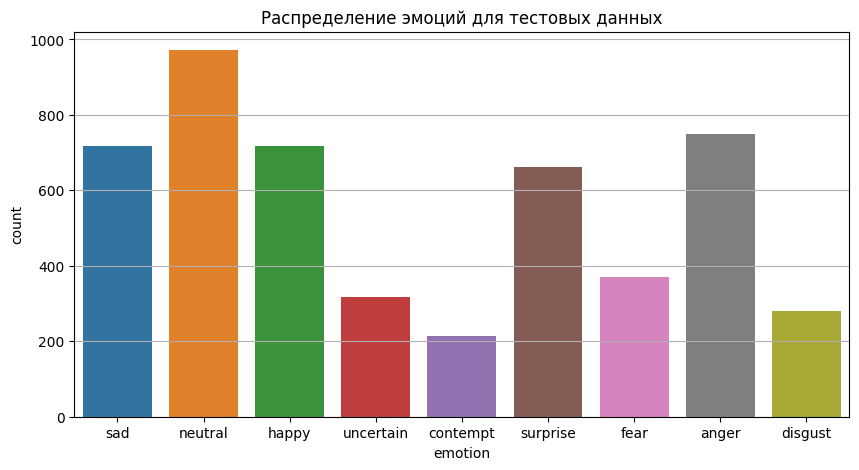

In [22]:
# тест

submission_data = []
for file in tqdm(df_test.image_path):
    img = image.load_img(PATH_TEST / file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = x / 255.
    x = np.expand_dims(x, axis=0)
    predicts = model_emotion.predict(x)
    emotion = emotion_mapping[np.argmax(predicts)]
    submission_data.append((file, emotion))

sample_submission = pd.DataFrame()
sample_submission['image_path'], sample_submission['emotion'] = zip(*submission_data)

fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot(data = sample_submission, x='emotion', ax=ax).set_title('Распределение эмоций для тестовых данных')
plt.grid(axis='y')
plt.show()

sample_submission.to_csv(BASE_DIR  / 'model_emotion/sample_submission_BiT.csv', index=False)